In [87]:
%load_ext autoreload
%autoreload 2
from covid_constants_and_util import *
from disease_model import * 
import helper_methods_for_aggregate_data_analysis as helper
from model_experiments import *
from model_results import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as tick
from collections import Counter 
import datetime
from scipy.stats import linregress 
import os
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model fit 

In [61]:
# Load models after grid search
min_timestring = '2020_07_16_10_4'
max_timestring = '2020_07_18'
df = evaluate_all_fitted_models_for_experiment('normal_grid_search', 
                                                min_timestring=min_timestring,
                                                max_timestring=max_timestring)
df['MSA_name'] = df['data_kwargs'].map(lambda x:x['MSA_name'])
ablation_df = df.loc[df['poi_psi'] == 0].copy()
non_ablation_df = df.loc[df['poi_psi'] > 0].copy()
df = None

Loading models with timestrings between 2020_07_16_10_4 and 2020_07_18
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 17000 fitted models for normal_grid_search
Loaded 1 models so far: 0.006s -> 0.006s per model
Loaded 1001 models so far: 3.467s -> 0.003s per model
Loaded 2001 models so far: 6.836s -> 0.003s per model
Loaded 3001 models so far: 10.193s -> 0.003s per model
Loaded 4001 models so far: 13.563s -> 0.003s per model
Loaded 5001 models so far: 18.340s -> 0.004s per model
Loaded 6001 models so far: 21.790s -> 0.004s per model
Loaded 7001 models so far: 25.168s -> 0.004s per model
Loaded 8001 models so far: 28.530s -> 0.004s per model
Loaded 9001 models so far: 31.869s -> 0.004s per model
Loaded 10001 models so far: 35.700s -> 0.004s per model
Loaded 11001 models so far: 39.076s -> 0.004s per model
Loaded 12001 models so far: 42.419s -> 0.004s per model
Loaded 13001 models so far: 45.729s -> 0.004s per model
Loaded 14001 mode

In [94]:
min_timestring = '2020_07_17_15_29_07_631477'
agg_gridsearch_df = evaluate_all_fitted_models_for_experiment('grid_search_aggregate_mobility', 
                                                              min_timestring=min_timestring)
agg_gridsearch_df['MSA_name'] = agg_gridsearch_df['data_kwargs'].map(lambda x:x['MSA_name'])

Loading models with timestrings between 2020_07_17_15_29_07_631477 and 2020_07_29_22_15_52_247037
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 15000 fitted models for grid_search_aggregate_mobility
Loaded 1 models so far: 0.005s -> 0.005s per model
Loaded 1001 models so far: 1.975s -> 0.002s per model
Loaded 2001 models so far: 3.829s -> 0.002s per model
Loaded 3001 models so far: 5.657s -> 0.002s per model
Loaded 4001 models so far: 7.480s -> 0.002s per model
Loaded 5001 models so far: 9.298s -> 0.002s per model
Loaded 6001 models so far: 11.084s -> 0.002s per model
Loaded 7001 models so far: 12.905s -> 0.002s per model
Loaded 8001 models so far: 14.671s -> 0.002s per model
Loaded 9001 models so far: 16.430s -> 0.002s per model
Loaded 10001 models so far: 18.719s -> 0.002s per model
Loaded 11001 models so far: 20.511s -> 0.002s per model
Loaded 12001 models so far: 22.289s -> 0.002s per model
Loaded 13001 models so far: 24.003s -

## Grid search parameter table

In [64]:
print(f'Loss tolerance: {ACCEPTABLE_LOSS_TOLERANCE}')
model_df = get_summary_of_best_models(
    non_ablation_df, 
    MSAS,
    ACCEPTABLE_LOSS_TOLERANCE, 
    MAX_MODELS_TO_TAKE_PER_MSA)
keys = ['home_beta', 'poi_psi', 'p_sick_at_t0']
table_df = pd.DataFrame(columns=['MSA', '# models within RMSE threshold'] + keys)
for idx in range(len(model_df)):
    model_dict = {}
    model_dict['MSA'] = MSAS_TO_PRETTY_NAMES[model_df.iloc[idx]['MSA']]
    model_dict['# models within RMSE threshold'] = model_df.iloc[idx]['n_models']
    for key in keys:
        min_key = f'{key}_min'
        max_key = f'{key}_max'
        if key == 'home_beta':
            fmt_string = '%2.3f (%2.3f, %2.3f)'
        elif key == 'poi_psi':
            fmt_string = '%i (%i, %i)'
        else:
            fmt_string = "%2.0e (%2.0e, %2.0e)"
        model_dict[key] = fmt_string % (model_df.iloc[idx][key], 
                                            model_df.iloc[idx][min_key], 
                                            model_df.iloc[idx][max_key])        
    table_df = table_df.append(model_dict, ignore_index=True)
table_df

Loss tolerance: 1.2
Spearman correlation matrix for best-fit models
              home_beta   poi_psi  p_sick_at_t0
home_beta      1.000000 -0.957253      0.648152
poi_psi       -0.957253  1.000000     -0.816216
p_sick_at_t0   0.648152 -0.816216      1.000000
Atlanta_Sandy_Springs_Roswell_GA                  :  16
Spearman correlation matrix for best-fit models
              home_beta   poi_psi  p_sick_at_t0
home_beta      1.000000 -0.948683      0.544331
poi_psi       -0.948683  1.000000     -0.774597
p_sick_at_t0   0.544331 -0.774597      1.000000
Chicago_Naperville_Elgin_IL_IN_WI                 :   4
Spearman correlation matrix for best-fit models
              home_beta   poi_psi  p_sick_at_t0
home_beta      1.000000 -0.974679      0.544107
poi_psi       -0.974679  1.000000     -0.707107
p_sick_at_t0   0.544107 -0.707107      1.000000
Dallas_Fort_Worth_Arlington_TX                    :   5
Spearman correlation matrix for best-fit models
              home_beta   poi_psi  p_sick_at

MSA # models within RMSE threshold             home_beta            poi_psi          p_sick_at_t0
0        Atlanta                             16  0.004 (0.001, 0.014)   2388 (515, 3325)  5e-04 (1e-04, 2e-03)
1        Chicago                              4  0.009 (0.006, 0.011)  1764 (1139, 2076)  2e-04 (2e-04, 5e-04)
2         Dallas                              5  0.009 (0.004, 0.011)  1452 (1139, 2388)  2e-04 (1e-04, 2e-04)
3        Houston                              8  0.001 (0.001, 0.009)  2076 (1139, 2076)  2e-04 (1e-04, 5e-04)
4    Los Angeles                             25  0.006 (0.001, 0.016)   2076 (515, 3637)  2e-04 (2e-05, 1e-03)
5          Miami                              7  0.001 (0.001, 0.011)   2388 (515, 2388)  2e-04 (2e-04, 2e-03)
6  New York City                              7  0.001 (0.001, 0.009)  2700 (1452, 3013)  1e-04 (5e-05, 1e-03)
7   Philadelphia                              3  0.009 (0.001, 0.009)    827 (827, 1452)  5e-04 (1e-04, 5e-04)
8  San Francisco                              5  0.006 (0.001, 0.009)   1139 (827, 1764)  5e-04 (2e-04, 1e-03)
9  Washington DC                             17  0.016 (0.001, 0.019)    515 (515, 3949)  5e-04 (2e-05, 5e-04)

In [65]:
table_df.to_latex()

'\\begin{tabular}{llllll}\n\\toprule\n{} &            MSA & \\# models within RMSE threshold &             home\\_beta &            poi\\_psi &          p\\_sick\\_at\\_t0 \\\\\n\\midrule\n0 &        Atlanta &                             16 &  0.004 (0.001, 0.014) &   2388 (515, 3325) &  5e-04 (1e-04, 2e-03) \\\\\n1 &        Chicago &                              4 &  0.009 (0.006, 0.011) &  1764 (1139, 2076) &  2e-04 (2e-04, 5e-04) \\\\\n2 &         Dallas &                              5 &  0.009 (0.004, 0.011) &  1452 (1139, 2388) &  2e-04 (1e-04, 2e-04) \\\\\n3 &        Houston &                              8 &  0.001 (0.001, 0.009) &  2076 (1139, 2076) &  2e-04 (1e-04, 5e-04) \\\\\n4 &    Los Angeles &                             25 &  0.006 (0.001, 0.016) &   2076 (515, 3637) &  2e-04 (2e-05, 1e-03) \\\\\n5 &          Miami &                              7 &  0.001 (0.001, 0.011) &   2388 (515, 2388) &  2e-04 (2e-04, 2e-03) \\\\\n6 &  New York City &                             

## Ablation params and do we beat ablations

In [31]:
# compare train loss

def get_best_model_per_msa(df, version, mode, metric, use_train_loss=True):
    if use_train_loss:
        key_to_sort_by = 'train_loss_dict_%s_%s_%s' % (version, mode, metric)
    else:
        key_to_sort_by = 'loss_dict_%s_%s_%s' % (version, mode, metric)
    print('Key:', key_to_sort_by)
    subdfs = []
    for msa_name in sorted(list(set(df['MSA_name']))):
        subdf = df[df['MSA_name'] == msa_name].copy()
        subdf = subdf.sort_values(by=key_to_sort_by)
        subdfs.append(subdf.iloc[:1])
    concat_df = pd.concat(subdfs)
    for k in ['poi_psi', 'home_beta', 'p_sick_at_t0']:
        on_lower_boundary = (concat_df[k] == df[k].min()).sum()
        on_upper_boundary = (concat_df[k] == df[k].max()).sum()
        print("Searched over range %2.5f-%2.5f for %s (on lower boundary for %i MSAs, upper for %i MSAs)" % (df[k].min(), 
                                                                                    df[k].max(), 
                                                                                    k, 
                                                                                    on_lower_boundary, 
                                                                                    on_upper_boundary))
    return concat_df

print("Comparing ablation and non-ablation on train loss")
ablation_plus_nonablation = pd.concat([ablation_df, non_ablation_df])
version = 'daily'
metric = 'RMSE'
mode = 'cases'
concat_df = get_best_model_per_msa(ablation_plus_nonablation, version, mode, metric)

cols = ['MSA_name', 
        'train_loss_dict_%s_%s_%s' % (version, mode, metric),
        'test_loss_dict_%s_%s_%s' % (version, mode, metric),
        'loss_dict_%s_%s_%s' % (version, mode, metric),
        
        'poi_psi', 'home_beta', 'p_sick_at_t0']
concat_df[cols]


Comparing ablation and non-ablation on train loss
Key: train_loss_dict_daily_cases_RMSE
Searched over range 0.00000-4886.41660 for poi_psi (on lower boundary for 0 MSAs, upper for 0 MSAs)
Searched over range 0.00120-0.04000 for home_beta (on lower boundary for 2 MSAs, upper for 0 MSAs)
Searched over range 0.00001-0.01000 for p_sick_at_t0 (on lower boundary for 0 MSAs, upper for 0 MSAs)


MSA_name  train_loss_dict_daily_cases_RMSE  test_loss_dict_daily_cases_RMSE  loss_dict_daily_cases_RMSE      poi_psi  home_beta  p_sick_at_t0
12975             Atlanta_Sandy_Springs_Roswell_GA                        117.762430                       617.802064                  399.833447   515.402485   0.016376       0.00050
13225            Chicago_Naperville_Elgin_IL_IN_WI                        205.095810                       405.595306                  301.511908  2076.478953   0.006257       0.00020
2440                Dallas_Fort_Worth_Arlington_TX                         45.537036                        68.495009                   56.035895  1452.048366   0.008787       0.00020
16887          Houston_The_Woodlands_Sugar_Land_TX                        113.843837                       304.401547                  211.307259  1452.048366   0.008787       0.00020
14846            Los_Angeles_Long_Beach_Anaheim_CA                        144.852254                       553.207062                  366.284247  2388.694247   0.001198       0.00020
2325      Miami_Fort_Lauderdale_West_Palm_Beach_FL                        120.782148                       522.414348                  342.247157  2076.478953   0.006257       0.00020
3000          New_York_Newark_Jersey_City_NY_NJ_PA                        829.087118                      1483.694223                 1135.399741  3013.124834   0.001198       0.00005
2685    Philadelphia_Camden_Wilmington_PA_NJ_DE_MD                        139.735304                       251.760245                  192.224973   827.617779   0.008787       0.00050
493               San_Francisco_Oakland_Hayward_CA                         37.642000                        44.585252                   40.634378  1139.833073   0.006257       0.00050
14541  Washington_Arlington_Alexandria_DC_VA_MD_WV                        106.970862                       810.419971                  517.331588   827.617779   0.018905       0.00020

In [32]:
# compare full loss [ablation vs non-ablation]
print("Comparing ablation and non-ablation on full loss")
concat_df_using_full_loss = get_best_model_per_msa(ablation_plus_nonablation, version, mode, metric, use_train_loss=False)
concat_df_using_full_loss[cols]

Comparing ablation and non-ablation on full loss
Key: loss_dict_daily_cases_RMSE
Searched over range 0.00000-4886.41660 for poi_psi (on lower boundary for 0 MSAs, upper for 0 MSAs)
Searched over range 0.00120-0.04000 for home_beta (on lower boundary for 3 MSAs, upper for 0 MSAs)
Searched over range 0.00001-0.01000 for p_sick_at_t0 (on lower boundary for 0 MSAs, upper for 0 MSAs)


MSA_name  train_loss_dict_daily_cases_RMSE  test_loss_dict_daily_cases_RMSE  loss_dict_daily_cases_RMSE      poi_psi  home_beta  p_sick_at_t0
12783             Atlanta_Sandy_Springs_Roswell_GA                        141.082025                       128.177041                  136.123175  2388.694247   0.003728        0.0005
13698            Chicago_Naperville_Elgin_IL_IN_WI                        207.359336                       387.223632                  292.526622  1764.263660   0.008787        0.0002
2440                Dallas_Fort_Worth_Arlington_TX                         45.537036                        68.495009                   56.035895  1452.048366   0.008787        0.0002
12873          Houston_The_Woodlands_Sugar_Land_TX                        117.215022                        76.206853                  103.227208  2076.478953   0.001198        0.0002
1623             Los_Angeles_Long_Beach_Anaheim_CA                        188.067196                       380.527735                  281.046450  2076.478953   0.006257        0.0002
5345      Miami_Fort_Lauderdale_West_Palm_Beach_FL                        144.941498                       202.735789                  170.586723  2388.694247   0.001198        0.0002
4936          New_York_Newark_Jersey_City_NY_NJ_PA                        883.098827                      1231.663597                 1035.817910  2700.909540   0.001198        0.0001
2685    Philadelphia_Camden_Wilmington_PA_NJ_DE_MD                        139.735304                       251.760245                  192.224973   827.617779   0.008787        0.0005
493               San_Francisco_Oakland_Hayward_CA                         37.642000                        44.585252                   40.634378  1139.833073   0.006257        0.0005
16482  Washington_Arlington_Alexandria_DC_VA_MD_WV                        142.450415                       295.457856                  216.550758   515.402485   0.016376        0.0005

In [33]:
print("Comparing ablation and non-ablation on OOS")
for k1 in ['daily']:
    for k2 in ['cases']:
        for k3 in ['RMSE']:
            
            combined_key = 'train_loss_dict_%s_%s_%s' % (k1, k2, k3)
            
            ablation_comparison = []
            for msa_name in MSAS_TO_PRETTY_NAMES:
                ablation_subdf = ablation_df[(ablation_df['MSA_name'] == msa_name)].sort_values(by=combined_key)
                non_ablation_subdf = non_ablation_df[(non_ablation_df['MSA_name'] == msa_name)].sort_values(by=combined_key)
                ablation_train_loss = ablation_subdf.iloc[0][combined_key]
                non_ablation_train_loss = non_ablation_subdf.iloc[0][combined_key]
                ablation_test_loss = ablation_subdf.iloc[0][combined_key.replace('train', 'test')]
                non_ablation_test_loss = non_ablation_subdf.iloc[0][combined_key.replace('train', 'test')]
                ablation_comparison.append({'MSA_name':msa_name[:15], 
                                            'abl_train_loss':ablation_train_loss, 
                                            'our_train_loss':non_ablation_train_loss,
                                            'abl_test_loss':ablation_test_loss, 
                                            'our_test_loss':non_ablation_test_loss})
            ablation_comparison = pd.DataFrame(ablation_comparison)
            ablation_comparison['we_win_train'] = (ablation_comparison['our_train_loss'] < 
                                             ablation_comparison['abl_train_loss'])
            ablation_comparison['we_win_test'] = (ablation_comparison['our_test_loss'] < 
                                             ablation_comparison['abl_test_loss'])
            print("Sorting by %s: non-ablation wins train %i/%i, test %i/%i" % (
                combined_key,
                ablation_comparison['we_win_train'].sum(), 
                len(ablation_comparison),
                ablation_comparison['we_win_test'].sum(),
                len(ablation_comparison)))
            print(ablation_comparison[['MSA_name',
                                        'our_train_loss', 'abl_train_loss', 'we_win_train', 
                                        'our_test_loss', 'abl_test_loss', 'we_win_test']])

Comparing ablation and non-ablation on OOS
Sorting by train_loss_dict_daily_cases_RMSE: non-ablation wins train 10/10, test 9/10
          MSA_name  our_train_loss  abl_train_loss  we_win_train  our_test_loss  abl_test_loss  we_win_test
0  Atlanta_Sandy_S      117.762430      121.910936          True     617.802064    1521.297509         True
1  Chicago_Napervi      205.095810      243.355148          True     405.595306    3186.924167         True
2  Dallas_Fort_Wor       45.537036       55.873925          True      68.495009     131.988753         True
3  Houston_The_Woo      113.843837      123.078154          True     304.401547     734.985564         True
4  Los_Angeles_Lon      144.852254      167.830042          True     553.207062    1057.653719         True
5  Miami_Fort_Laud      120.782148      180.397808          True     522.414348     847.278281         True
6  New_York_Newark      829.087118     1714.141935          True    1483.694223    6447.609521         True
7  Phil

In [34]:
# look at ablation params and check if we're on the boundary. 
print("Looking at ablation models only to check if we are on the boundary")
get_best_model_per_msa(ablation_df, version, mode, metric, use_train_loss=False)[cols]

Looking at ablation models only to check if we are on the boundary
Key: loss_dict_daily_cases_RMSE
Searched over range 0.00000-0.00000 for poi_psi (on lower boundary for 10 MSAs, upper for 10 MSAs)
Searched over range 0.00500-0.04000 for home_beta (on lower boundary for 0 MSAs, upper for 0 MSAs)
Searched over range 0.00001-0.01000 for p_sick_at_t0 (on lower boundary for 0 MSAs, upper for 1 MSAs)


MSA_name  train_loss_dict_daily_cases_RMSE  test_loss_dict_daily_cases_RMSE  loss_dict_daily_cases_RMSE  poi_psi  home_beta  p_sick_at_t0
3220              Atlanta_Sandy_Springs_Roswell_GA                        156.123197                       186.229447                  168.750293      0.0   0.014211        0.0020
7227             Chicago_Naperville_Elgin_IL_IN_WI                        315.059747                       392.748942                  347.982707      0.0   0.016053        0.0020
13366               Dallas_Fort_Worth_Arlington_TX                         80.979819                        71.155733                   77.174047      0.0   0.014211        0.0010
12037          Houston_The_Woodlands_Sugar_Land_TX                        149.319395                        89.706072                  129.058225      0.0   0.014211        0.0010
5809             Los_Angeles_Long_Beach_Anaheim_CA                        210.172289                       420.140535                  310.953191      0.0   0.016053        0.0005
16273     Miami_Fort_Lauderdale_West_Palm_Beach_FL                        249.383039                       235.920607                  244.163486      0.0   0.014211        0.0020
10095         New_York_Newark_Jersey_City_NY_NJ_PA                       2300.270310                      3000.614275                 2600.882204      0.0   0.016053        0.0100
547     Philadelphia_Camden_Wilmington_PA_NJ_DE_MD                        385.372154                       281.434089                  347.868507      0.0   0.014211        0.0050
15611             San_Francisco_Oakland_Hayward_CA                         65.675243                        48.433049                   59.440911      0.0   0.014211        0.0005
9729   Washington_Arlington_Alexandria_DC_VA_MD_WV                        187.914696                       307.417086                  242.505861      0.0   0.016053        0.0020

In [35]:
# look at ablation params and check if we're on the boundary. 
print("Looking at NON-ablation models only to check if we are on the boundary")
get_best_model_per_msa(non_ablation_df, version, mode, metric, use_train_loss=False)[cols]

Looking at NON-ablation models only to check if we are on the boundary
Key: loss_dict_daily_cases_RMSE
Searched over range 515.40249-4886.41660 for poi_psi (on lower boundary for 1 MSAs, upper for 0 MSAs)
Searched over range 0.00120-0.02396 for home_beta (on lower boundary for 3 MSAs, upper for 0 MSAs)
Searched over range 0.00001-0.01000 for p_sick_at_t0 (on lower boundary for 0 MSAs, upper for 0 MSAs)


MSA_name  train_loss_dict_daily_cases_RMSE  test_loss_dict_daily_cases_RMSE  loss_dict_daily_cases_RMSE      poi_psi  home_beta  p_sick_at_t0
12783             Atlanta_Sandy_Springs_Roswell_GA                        141.082025                       128.177041                  136.123175  2388.694247   0.003728        0.0005
13698            Chicago_Naperville_Elgin_IL_IN_WI                        207.359336                       387.223632                  292.526622  1764.263660   0.008787        0.0002
2440                Dallas_Fort_Worth_Arlington_TX                         45.537036                        68.495009                   56.035895  1452.048366   0.008787        0.0002
12873          Houston_The_Woodlands_Sugar_Land_TX                        117.215022                        76.206853                  103.227208  2076.478953   0.001198        0.0002
1623             Los_Angeles_Long_Beach_Anaheim_CA                        188.067196                       380.527735                  281.046450  2076.478953   0.006257        0.0002
5345      Miami_Fort_Lauderdale_West_Palm_Beach_FL                        144.941498                       202.735789                  170.586723  2388.694247   0.001198        0.0002
4936          New_York_Newark_Jersey_City_NY_NJ_PA                        883.098827                      1231.663597                 1035.817910  2700.909540   0.001198        0.0001
2685    Philadelphia_Camden_Wilmington_PA_NJ_DE_MD                        139.735304                       251.760245                  192.224973   827.617779   0.008787        0.0005
493               San_Francisco_Oakland_Hayward_CA                         37.642000                        44.585252                   40.634378  1139.833073   0.006257        0.0005
16482  Washington_Arlington_Alexandria_DC_VA_MD_WV                        142.450415                       295.457856                  216.550758   515.402485   0.016376        0.0005

## Figure 1c: OOS and full fit in highlighted MSA

trajectory_cases_oos_vs_full_fit_Chicago_Naperville_Elgin_IL_IN_WI
Found 14 best fit models within threshold for Chicago
Found 4 best fit models within threshold for Chicago


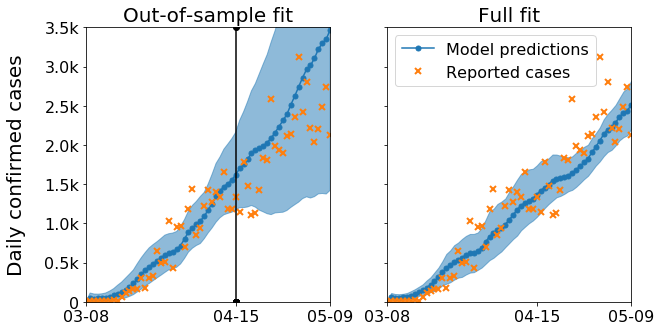

In [8]:
df, df_str = non_ablation_df, 'non_ablation'
thing_to_plot, plot_daily_not_cumulative = 'cases', True
prefix_to_save_plot_with = f'trajectory_{thing_to_plot}_oos_vs_full_fit_{HIGHLIGHT_MSA}'
print(prefix_to_save_plot_with)

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
for idx, ax in enumerate(axes):
    if idx == 0:
        title = 'Out-of-sample fit'
        plot_legend = False
        train_test_partition = TRAIN_TEST_PARTITION
        key_to_sort_by = 'train_loss_dict_daily_cases_RMSE'
    else:
        title = 'Full fit'
        plot_legend = True
        train_test_partition = None
        key_to_sort_by = 'loss_dict_daily_cases_RMSE'
    other_plotting_kwargs =  {
            'plot_log':False, 
            'plot_legend':plot_legend,
            'plot_errorbars':True,
            'xticks':[datetime.datetime(2020, 3, 8), 
                      datetime.datetime(2020, 4, 15),  
                      datetime.datetime(2020, 5, 9)],                                                                             
            'x_range':[datetime.datetime(2020, 3, 8),
                       datetime.datetime(2020, 5, 9)],        
            'y_range': (0, 3500),
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
            'model_line_label': 'Model predictions',
            'true_line_label': 'Reported cases',
            'title':title,
            'title_fontsize':20,
            'marker_size':5,
            'real_data_color':'tab:orange',
            'model_color':'tab:blue',
            'only_two_yticks':False,
            'plot_mode':thing_to_plot,
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
    }
    plot_best_models_fit_for_msa(df, HIGHLIGHT_MSA, ax, key_to_sort_by, train_test_partition, 
                                 other_plotting_kwargs)
    
ax = fig.add_subplot(111, frame_on=False)
ax.tick_params(labelcolor="none", bottom=False, left=False)
ax.set_ylabel('Daily confirmed cases', fontsize=20)
ax.yaxis.set_label_coords(-0.11,0.5)

if prefix_to_save_plot_with is not None:
    for ext in ['svg']:
        plt.savefig('covid_figures_for_paper/trajectories/%s.%s' % 
                (prefix_to_save_plot_with,
                ext), 
                bbox_inches='tight',
                dpi=600)

plt.tight_layout()
plt.show()

## Figure 1d: full fits for all other MSAs

Atlanta_Sandy_Springs_Roswell_GA
Found 16 best fit models within threshold for Atlanta
Dallas_Fort_Worth_Arlington_TX
Found 5 best fit models within threshold for Dallas
Houston_The_Woodlands_Sugar_Land_TX
Found 8 best fit models within threshold for Houston
Los_Angeles_Long_Beach_Anaheim_CA
Found 25 best fit models within threshold for Los Angeles
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Found 7 best fit models within threshold for Miami
New_York_Newark_Jersey_City_NY_NJ_PA
Found 7 best fit models within threshold for New York City
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Found 3 best fit models within threshold for Philadelphia
San_Francisco_Oakland_Hayward_CA
Found 5 best fit models within threshold for San Francisco
Washington_Arlington_Alexandria_DC_VA_MD_WV
Found 17 best fit models within threshold for Washington DC
trajectory_3x3_grid_cases_full_fit_non_ablation_without_Chicago


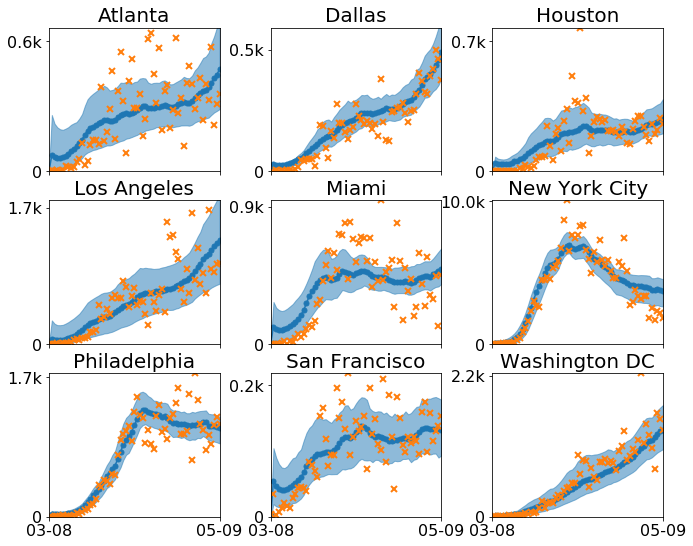

In [9]:
df, df_str = non_ablation_df, 'non_ablation'
train_test_partition, train_test_partition_str, key_to_sort_by = None, 'full_fit', 'loss_dict_daily_cases_RMSE'
thing_to_plot, plot_daily_not_cumulative = 'cases', True
other_plotting_kwargs =  { 
            'plot_log':False, 
            'plot_legend':False,
            'plot_errorbars':True,
            'xticks':[datetime.datetime(2020, 3, 8),                                   
                      datetime.datetime(2020, 5, 9)],                                                                             
            'x_range':[datetime.datetime(2020, 3, 8),
                       datetime.datetime(2020, 5, 9)],                                            
            'title_fontsize':20,
            'marker_size':5,
            'only_two_yticks':True,
            'real_data_color':'tab:orange',
            'model_color':'tab:blue',
            'plot_mode':thing_to_plot,
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
}
prefix_to_save_plot_with = f'trajectory_3x3_grid_{thing_to_plot}_{train_test_partition_str}_{df_str}_without_{MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA]}'
          
fig, axes = plt.subplots(3, 3, figsize=(11,9), sharex=True)
fig.subplots_adjust(wspace=0.3)
axes_list = [ax for axes_row in axes for ax in axes_row]
msas_to_plot_small = [msa for msa in MSAS if msa != HIGHLIGHT_MSA]
for ax, msa_name in zip(axes_list, msas_to_plot_small):
    print(msa_name)
    plot_best_models_fit_for_msa(df, msa_name, ax, key_to_sort_by, train_test_partition, 
                                 other_plotting_kwargs)

if prefix_to_save_plot_with is not None:
    for ext in ['svg']:
        plt.savefig('covid_figures_for_paper/trajectories/%s.%s' % 
                (prefix_to_save_plot_with,
                ext), 
                dpi=600)
print(prefix_to_save_plot_with)
plt.show()

## Supplement: OOS for all MSAs, comparison to baseline models

trajectory_2x5_grid_cases_oos_fit_non_ablation
Found 43 best fit models within threshold for Atlanta
Found 14 best fit models within threshold for Chicago
Found 16 best fit models within threshold for Dallas
Found 51 best fit models within threshold for Houston
Found 24 best fit models within threshold for Los Angeles
Found 7 best fit models within threshold for Miami
Found 9 best fit models within threshold for New York City
Found 5 best fit models within threshold for Philadelphia
Found 9 best fit models within threshold for San Francisco
Found 13 best fit models within threshold for Washington DC


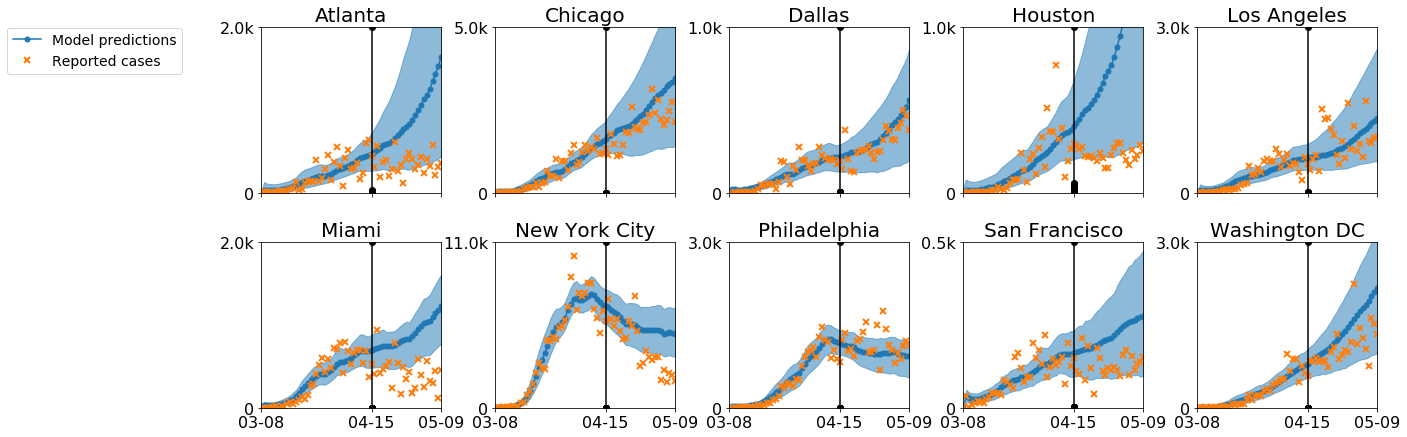

In [99]:
# full network model
y_maxes = [2000, 5000, 1000, 1000, 3000, 2000, 11000, 3000, 500, 3000]
plot_best_models_fit_for_all_msas(non_ablation_df, 'non_ablation', TRAIN_TEST_PARTITION, 'train_loss_dict_daily_cases_RMSE', 
                                  'cases', plot_daily_not_cumulative=True, save_fig=False, y_maxes=y_maxes)

trajectory_2x5_grid_cases_oos_fit_agg_mobility
Found 20 best fit models within threshold for Atlanta
Found 7 best fit models within threshold for Chicago
Found 9 best fit models within threshold for Dallas
Found 30 best fit models within threshold for Houston
Found 12 best fit models within threshold for Los Angeles
Found 8 best fit models within threshold for Miami
Found 5 best fit models within threshold for New York City
Found 19 best fit models within threshold for Philadelphia
Found 11 best fit models within threshold for San Francisco
Found 17 best fit models within threshold for Washington DC


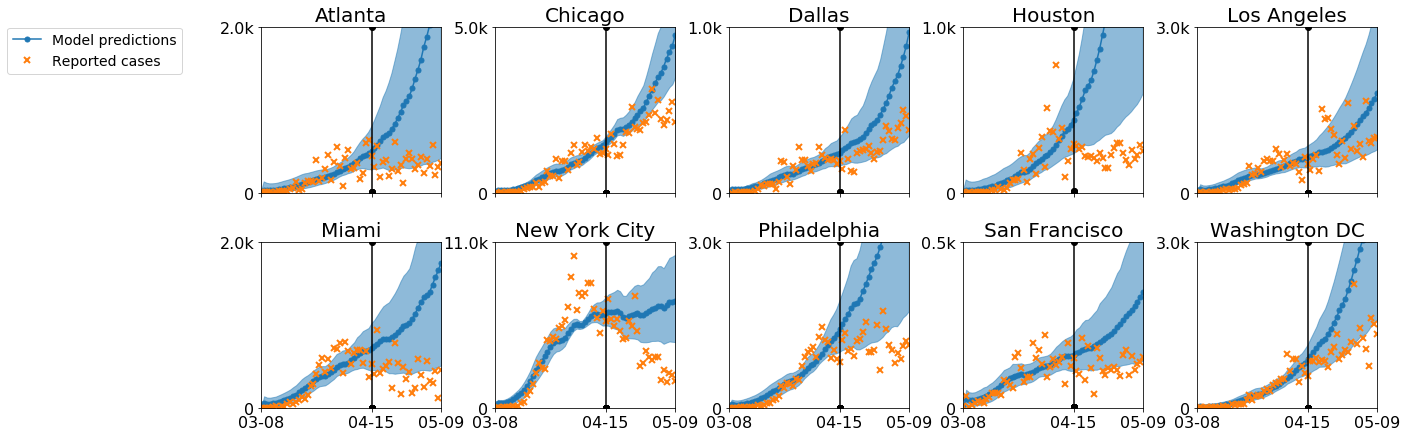

In [98]:
# aggregate mobility model
y_maxes = [2000, 5000, 1000, 1000, 3000, 2000, 11000, 3000, 500, 3000]
plot_best_models_fit_for_all_msas(agg_gridsearch_df, 'agg_mobility', TRAIN_TEST_PARTITION, 'train_loss_dict_daily_cases_RMSE', 
                                  'cases', plot_daily_not_cumulative=True, save_fig=False, y_maxes=y_maxes)

trajectory_2x5_grid_cases_oos_fit_ablation
Found 7 best fit models within threshold for Atlanta
Found 2 best fit models within threshold for Chicago
Found 3 best fit models within threshold for Dallas
Found 6 best fit models within threshold for Houston
Found 2 best fit models within threshold for Los Angeles
Found 3 best fit models within threshold for Miami
Found 2 best fit models within threshold for New York City
Found 3 best fit models within threshold for Philadelphia
Found 4 best fit models within threshold for San Francisco
Found 5 best fit models within threshold for Washington DC


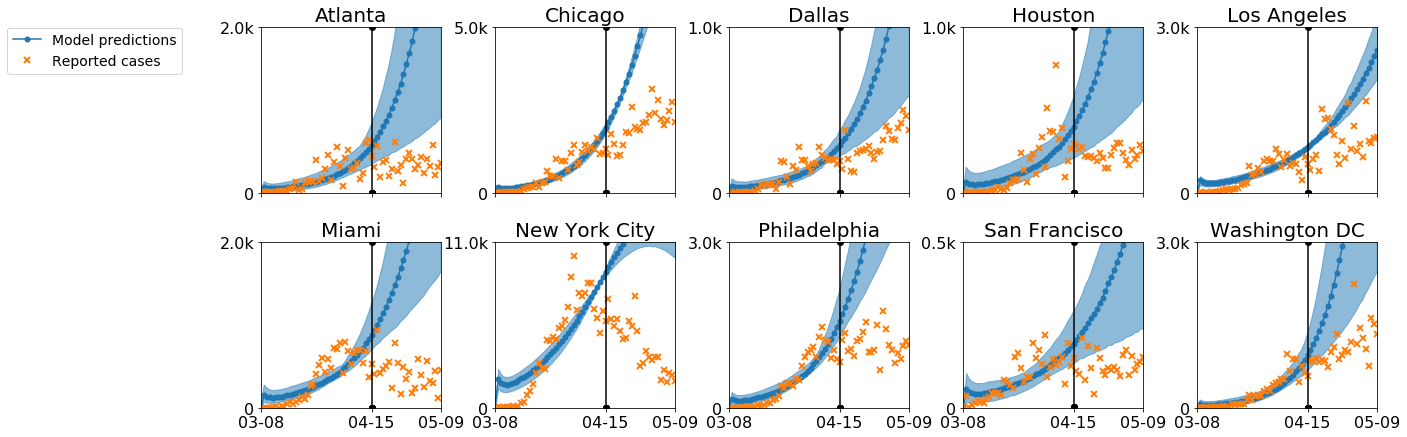

In [97]:
# model without mobility, aka ablation
y_maxes = [2000, 5000, 1000, 1000, 3000, 2000, 11000, 3000, 500, 3000]
plot_best_models_fit_for_all_msas(ablation_df, 'ablation', TRAIN_TEST_PARTITION, 'train_loss_dict_daily_cases_RMSE', 
                                  'cases', plot_daily_not_cumulative=True, save_fig=False, y_maxes=y_maxes)

Atlanta_Sandy_Springs_Roswell_GA
Found 27 best fit models within threshold for Atlanta
Chicago_Naperville_Elgin_IL_IN_WI
Found 12 best fit models within threshold for Chicago
Dallas_Fort_Worth_Arlington_TX
Found 23 best fit models within threshold for Dallas
Houston_The_Woodlands_Sugar_Land_TX
Found 16 best fit models within threshold for Houston
Los_Angeles_Long_Beach_Anaheim_CA
Found 12 best fit models within threshold for Los Angeles
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Found 20 best fit models within threshold for Miami
New_York_Newark_Jersey_City_NY_NJ_PA
Found 31 best fit models within threshold for New York City
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Found 45 best fit models within threshold for Philadelphia
San_Francisco_Oakland_Hayward_CA
Found 44 best fit models within threshold for San Francisco
Washington_Arlington_Alexandria_DC_VA_MD_WV
Found 21 best fit models within threshold for Washington DC


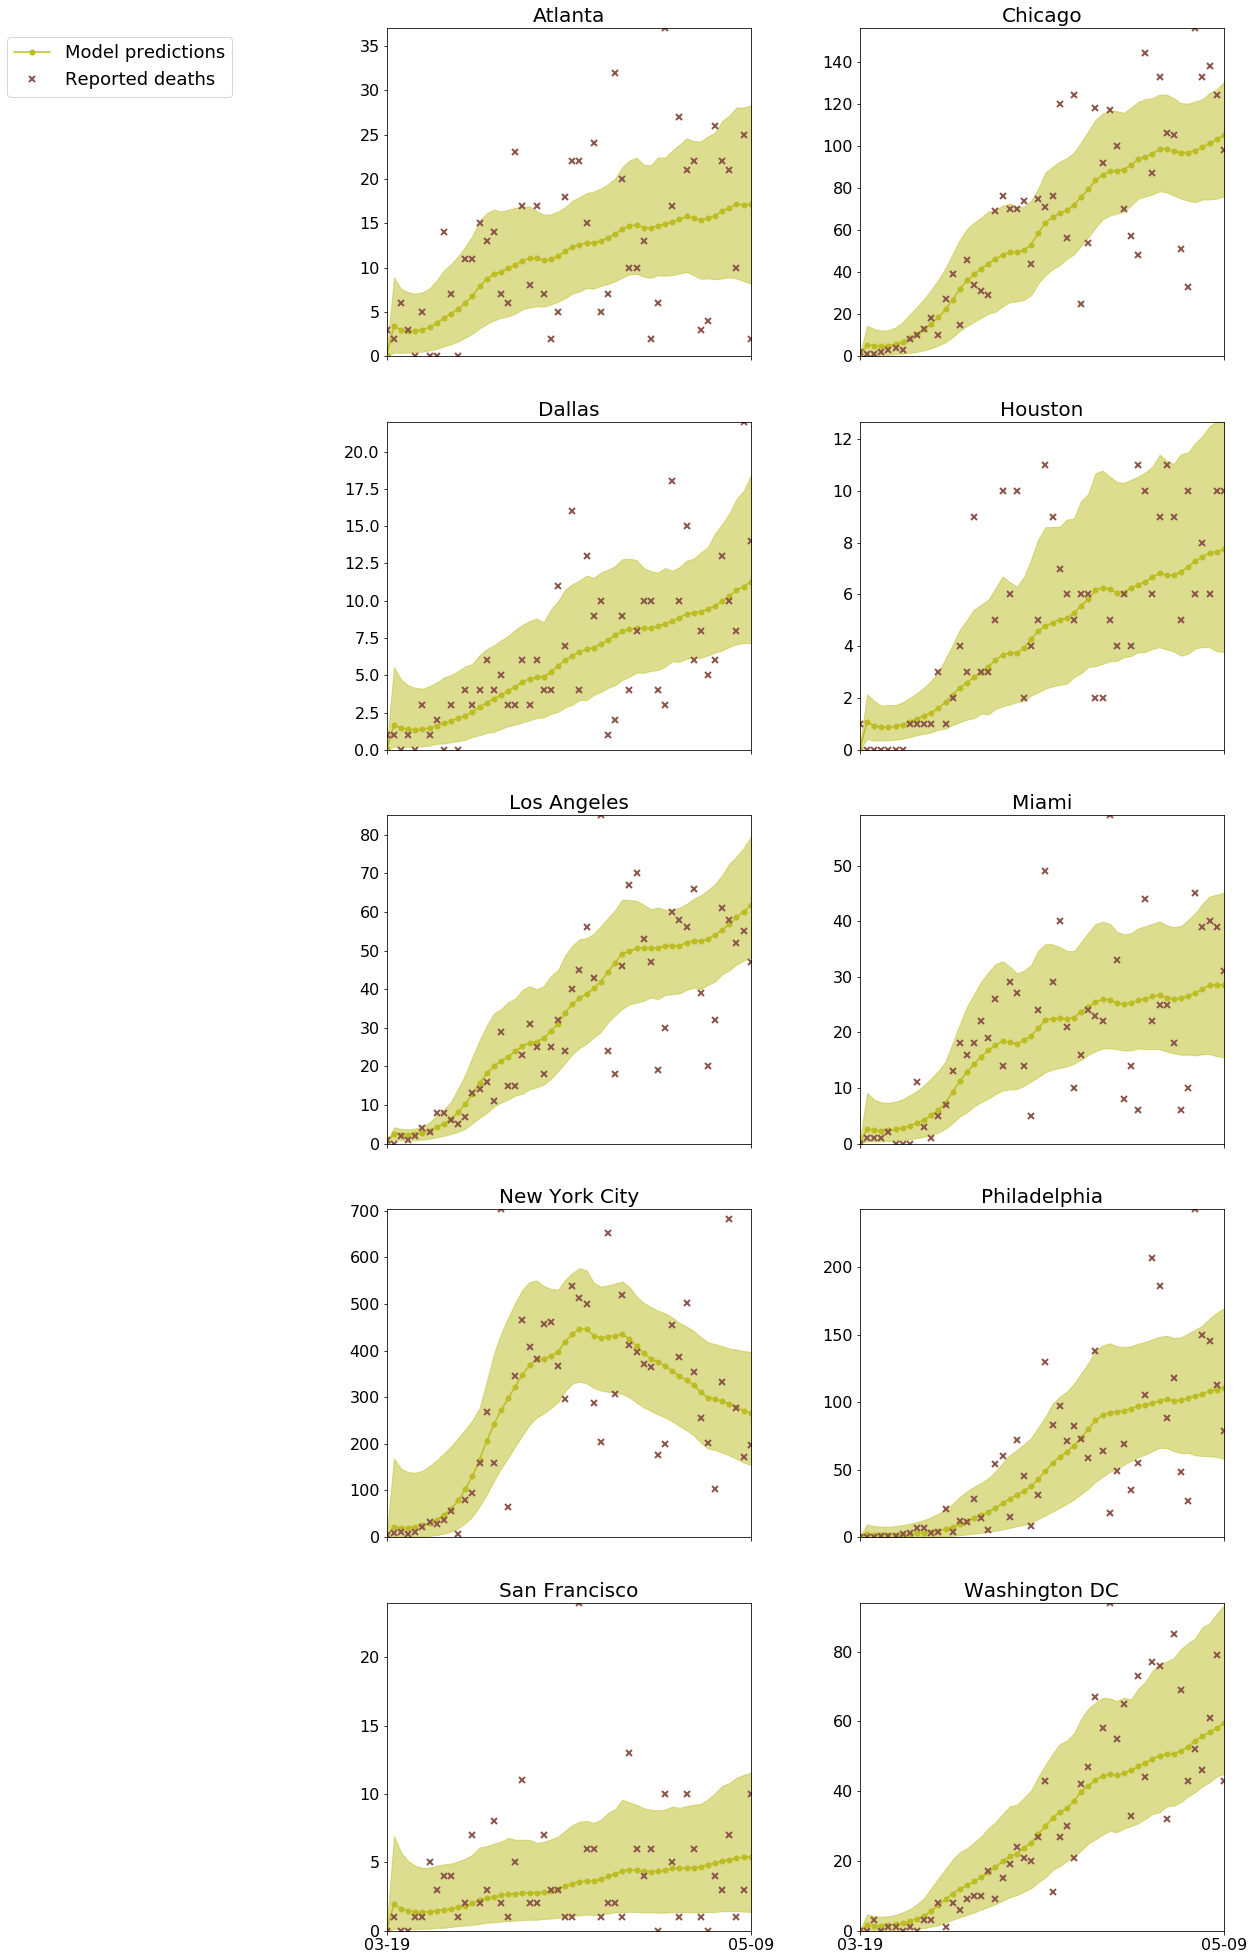

In [15]:
fig, axes = plt.subplots(5, 2, figsize=[15, 35], sharex=True)
fig.subplots_adjust(wspace=0.3)
axes = [ax for axes_row in axes for ax in axes_row]
df, df_str = non_ablation_df, 'non_ablation'
thing_to_plot, plot_daily_not_cumulative = 'deaths', True
plot_legend = False
train_test_partition = None
key_to_sort_by = 'loss_dict_daily_deaths_RMSE'
for i, (msa, ax) in enumerate(zip(MSAS, axes)):
    print(msa)
    title = MSAS_TO_PRETTY_NAMES[msa]
    other_plotting_kwargs =  {
            'plot_log':False, 
            'plot_legend':plot_legend,
            'plot_errorbars':True,
            'xticks':[datetime.datetime(2020, 3, 19), 
                      datetime.datetime(2020, 5, 9)],                                                                             
            'x_range':[datetime.datetime(2020, 3, 19),
                       datetime.datetime(2020, 5, 9)],        
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
            'model_line_label': 'Model predictions',
            'true_line_label': 'Reported deaths',
            'title':title,
            'title_fontsize':20,
            'marker_size':5,
            'real_data_color':'tab:brown',
            'model_color':'tab:olive',
            'only_two_yticks':False,
            'plot_mode':thing_to_plot,
            'plot_daily_not_cumulative':plot_daily_not_cumulative,
    }
    plot_best_models_fit_for_msa(df, msa, ax, key_to_sort_by, train_test_partition, 
                                 other_plotting_kwargs)
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.4, 1), fontsize=18)

## Supplement: calibrating grid search range by estimating R0

In [8]:
all_r0_results = []
min_r0_timestring='2020_07_10'
for msa in MSAS:
    all_r0_results.append(evaluate_all_fitted_models_for_msa(msa, 
                                                             min_timestring=min_r0_timestring, 
                                                             required_properties={'experiment_to_run':'calibrate_r0'},
                                                             key_to_sort_by=None))
r0_df = pd.concat(all_r0_results)
r0_df['MSA_name'] = r0_df['data_kwargs'].map(lambda x:x['MSA_name'])
assert len(r0_df) == 260, len(r0_df)
r0_df['R0'] = r0_df['estimated_R0_R0'].map(lambda x:x.mean())
r0_df['R0_base'] = r0_df['estimated_R0_R0_base'].map(lambda x:x.mean())
r0_df['R0_POI'] = r0_df['estimated_R0_R0_POI'].map(lambda x:x.mean())
assert np.allclose(r0_df['R0'], r0_df['R0_base'] + r0_df['R0_POI'])

Loading models with timestrings between 2020_07_10 and 2020_07_28_11_19_21_416445
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 26 fitted models for Atlanta_Sandy_Springs_Roswell_GA
Time to load and score all models: 0.091s -> 0.004s per model
Loading models with timestrings between 2020_07_10 and 2020_07_28_11_19_45_187039
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 26 fitted models for Chicago_Naperville_Elgin_IL_IN_WI
Time to load and score all models: 0.203s -> 0.008s per model
Loading models with timestrings between 2020_07_10 and 2020_07_28_11_20_02_858808
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 26 fitted models for Dallas_Fort_Worth_Arlington_TX
Time to load and score all models: 0.106s -> 0.004s per model
Loading models with timestrings between 2020_07_10 and 2020_07_28_11_20_19_047879
83235 files in directo

In [29]:
# reviewer question: how much variation across seeds. 

r0_df['R0_base_std_across_seeds'] = r0_df['estimated_R0_R0_base'].map(np.std)
r0_df['R0_POI_std_across_seeds'] = r0_df['estimated_R0_R0_POI'].map(np.std)

# filter for experiments we actually use. 

r0_df_to_use = r0_df.loc[(r0_df['poi_psi'] >= 500) & (r0_df['poi_psi'] <= 5000)].copy()
print(r0_df_to_use[['R0_base_std_across_seeds', 'R0_POI_std_across_seeds']].describe())


poi_range_across_cities = r0_df_to_use[['R0_POI', 'poi_psi']].groupby('poi_psi').agg(['min', 'max']).reset_index()
poi_range_across_cities.columns = ['poi_psi', 'min', 'max']

poi_range_across_cities['range'] = poi_range_across_cities['max'] - poi_range_across_cities['min']
print("Range in R_POI across cities")
print(poi_range_across_cities)
print("Aggregate stats about range")
print(poi_range_across_cities['range'].describe())

       R0_base_std_across_seeds  R0_POI_std_across_seeds
count                190.000000               190.000000
mean                   0.021468                 0.131093
std                    0.035335                 0.063676
min                    0.000000                 0.019976
25%                    0.007047                 0.087261
50%                    0.010410                 0.118529
75%                    0.012875                 0.168458
max                    0.203518                 0.367482
Range in R_POI across cities
   poi_psi       min       max     range
0      500  0.307390  0.978344  0.670954
1     1000  0.610649  1.981697  1.371049
2     1500  0.916325  2.933129  2.016804
3     2000  1.218791  3.932159  2.713368
4     2500  1.491213  4.900178  3.408965
5     3000  1.862433  5.875046  4.012614
6     3500  2.129408  6.851556  4.722148
7     4000  2.445150  7.784103  5.338953
8     4500  2.717199  8.763034  6.045835
9     5000  3.008952  9.695218  6.686266
Aggrega

R0_base lies in plausible range (0.10000-2.00000) for home_beta 0.00120-0.02396
    poi_psi       min       mean        max  n_models_fit
0       100  0.061318   0.089591   0.198000            10
1       250  0.148292   0.224010   0.488227            10
2       500  0.307390   0.443685   0.978344            10
3      1000  0.610649   0.891590   1.981697            10
4      1500  0.916325   1.332236   2.933129            10
5      2000  1.218791   1.772149   3.932159            10
6      2500  1.491213   2.229226   4.900178           100
7      3000  1.862433   2.681215   5.875046            10
8      3500  2.129408   3.124726   6.851556            10
9      4000  2.445150   3.561207   7.784103            10
10     4500  2.717199   3.991165   8.763034            10
11     5000  3.008952   4.441060   9.695218            10
12     6000  3.717316   5.334923  11.635333            10
13     7500  4.577455   6.675238  14.628326            10
14    10000  6.011597   8.871962  19.586977       

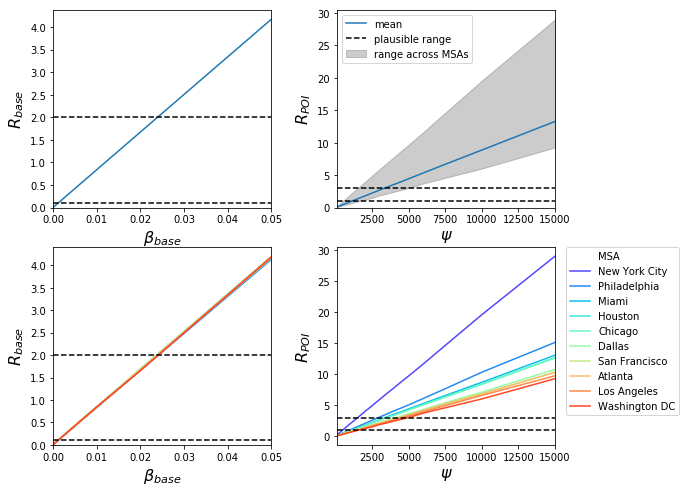

In [30]:
plausible_param_ranges = make_param_plausibility_plot(r0_df)
print(json.dumps(plausible_param_ranges))

# Set-up code for analyzing experimental results

In [ ]:
## Run either this cell (to generate the characteristics) or the cell below (to load a saved version, for speed)
# compute and save relevant characteristics for later analysis
poi_and_cbg_characteristics = {}
for msa_name in MSAS:
    df = helper.load_dataframe_for_individual_msa(MSA_name=msa_name)
    data_kwargs = {'MSA_name':msa_name}
    model_kwargs = {'min_datetime':MIN_DATETIME,
                    'max_datetime':MAX_DATETIME,
                    'exogenous_model_kwargs': {
                        'home_beta':1e-2,
                        'poi_psi':1000,
                        'p_sick_at_t0':1e-4,
                        'just_compute_r0':False},
                    'poi_attributes_to_clip':{
                        'clip_areas':True,
                        'clip_dwell_times':True,
                        'clip_visits':True},
                    'correct_poi_visits':True,
                    'return_model_and_data_without_fitting':True}
    # modify fit_ane_save_one_model temporarily to return these things
    m = fit_and_save_one_model(None, model_kwargs, data_kwargs, d=df)
    poi_and_cbg_characteristics[msa_name] = {'poi_categories':m.POI_SUBCATEGORY_TYPES,
                                  'poi_areas':m.POI_AREAS,
                                  'poi_dwell_times':m.d['avg_median_dwell'].values,
                                  'poi_dwell_time_correction_factors':m.DWELL_TIME_CORRECTION_FACTORS,
                                  'cbg_idx_groups_to_track':m.cbg_idx_groups_to_track,
                                  'cbg_sizes':m.CBG_SIZES}
f = open(PATH_TO_SAVED_CHARACTERISTICS, 'wb')
pickle.dump(poi_and_cbg_characteristics, f)
f.close()

In [6]:
# reloads poi_and_cbg_characteristics
f = open(PATH_TO_SAVED_CHARACTERISTICS, 'rb')
poi_and_cbg_characteristics = pickle.load(f)
f.close()
print(poi_and_cbg_characteristics.keys())
print(poi_and_cbg_characteristics[HIGHLIGHT_MSA].keys())

dict_keys(['Atlanta_Sandy_Springs_Roswell_GA', 'Chicago_Naperville_Elgin_IL_IN_WI', 'Dallas_Fort_Worth_Arlington_TX', 'Houston_The_Woodlands_Sugar_Land_TX', 'Los_Angeles_Long_Beach_Anaheim_CA', 'Miami_Fort_Lauderdale_West_Palm_Beach_FL', 'New_York_Newark_Jersey_City_NY_NJ_PA', 'Philadelphia_Camden_Wilmington_PA_NJ_DE_MD', 'San_Francisco_Oakland_Hayward_CA', 'Washington_Arlington_Alexandria_DC_VA_MD_WV'])
dict_keys(['poi_categories', 'poi_areas', 'poi_dwell_times', 'poi_dwell_time_correction_factors', 'cbg_idx_groups_to_track', 'cbg_sizes'])


In [43]:
# add IPF output(i.e., hourly POI-CBG networks) to characteristics
for msa_name in MSAS:
    print(msa_name)
    fn = get_ipf_filename(msa_name, MIN_DATETIME, MAX_DATETIME, True, True)
    print(fn)
    f = open(fn, 'rb')
    poi_cbg_visits_list = pickle.load(f)
    f.close()
    poi_and_cbg_characteristics[msa_name]['poi_cbg_visits_list'] = poi_cbg_visits_list

Atlanta_Sandy_Springs_Roswell_GA
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Atlanta_Sandy_Springs_Roswell_GA_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Chicago_Naperville_Elgin_IL_IN_WI
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Dallas_Fort_Worth_Arlington_TX
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Dallas_Fort_Worth_Arlington_TX_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Houston_The_Woodlands_Sugar_Land_TX
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Houston_The_Woodlands_Sugar_Land_TX_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Los_Angeles_Long_Beach_Anaheim_CA
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Los_Angeles_Long_Beach_Anaheim_CA_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Miami_Fort_Lauderdale_West_Palm_Be

In [23]:
top_categories = get_list_of_poi_subcategories_with_most_visits(n_poi_categories=20)
pretty_top_categories = [SUBCATEGORIES_TO_PRETTY_NAMES[cat] for cat in top_categories]

Reading chunk 0 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 0 in 24.198 seconds
Reading chunk 1 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 1 in 21.752 seconds
Reading chunk 2 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 2 in 21.044 seconds
Reading chunk 3 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annotations/chunk_1.2017-3.2020_c2.h5
Dates range from 2019-01-01 00:00:00 to 2020-05-02 00:00:00
Loaded chunk 3 in 22.750 seconds
Reading chunk 4 from /dfs/scratch1/safegraph_homes/all_aggregate_data/chunks_with_demographic_annota

# Mobility reductions + reopening analysis

## Figure 2a: counterfactual results for highlighted MSA

In [68]:
# load models
min_timestring = '2020_07_22'
counterfactual_df = evaluate_all_fitted_models_for_experiment('test_retrospective_counterfactuals', 
                                                               min_timestring=min_timestring)
counterfactual_df['MSA_name'] = counterfactual_df['data_kwargs'].map(lambda x:x['MSA_name'])
for k in ['distancing_degree', 'shift_in_days']:
    counterfactual_df['counterfactual_%s' % k] = counterfactual_df['counterfactual_retrospective_experiment_kwargs'].map(lambda x:x[k] if k in x else np.nan)
counterfactual_df['counterfactual_baseline_model'] = counterfactual_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
counterfactual_df['how_to_select_best_grid_search_models'] = counterfactual_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])
assert (counterfactual_df['poi_psi'] > 0).all()

counterfactual_df_cases = counterfactual_df.loc[counterfactual_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
counterfactual_df_deaths = counterfactual_df.loc[counterfactual_df['how_to_select_best_grid_search_models'] == 'daily_deaths_rmse'].copy()
print('Found %d models for selecting with cases, found %d for selecting with deaths' % 
       (len(counterfactual_df_cases), len(counterfactual_df_deaths)))


Loading models with timestrings between 2020_07_22 and 2020_07_29_19_56_36_702271
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 3200 fitted models for test_retrospective_counterfactuals
Loaded 1 models so far: 0.005s -> 0.005s per model
Loaded 1001 models so far: 3.156s -> 0.003s per model
Loaded 2001 models so far: 6.310s -> 0.003s per model
Loaded 3001 models so far: 9.401s -> 0.003s per model
Time to load and score all models: 10.016s -> 0.003s per model
Found 776 models for selecting with cases, found 2008 for selecting with deaths


Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120


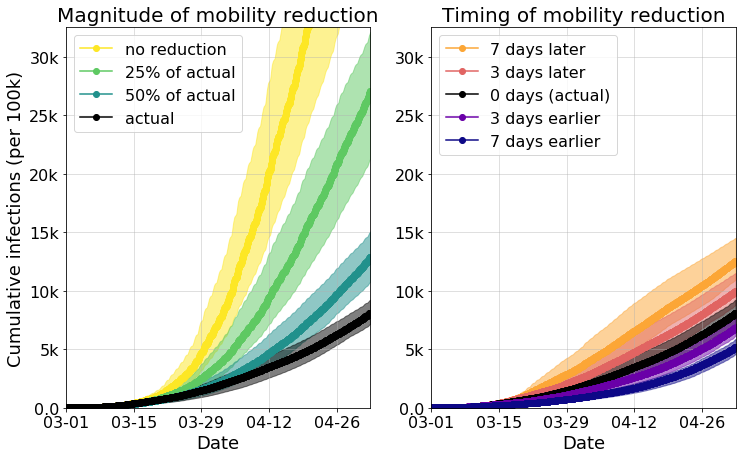

In [8]:
# Figure 2a, middle + right
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
degree_means, degree_colors = make_counterfactual_line_plots(counterfactual_df_cases, HIGHLIGHT_MSA, axes[0], 'degree')
y_max = degree_means[1][-1] * 1.2
axes[0].set_ylim(0, y_max)
shift_means, shift_colors = make_counterfactual_line_plots(counterfactual_df_cases, HIGHLIGHT_MSA, axes[1], 'shift', 
                                                           cmap_str='plasma', y_lim=(0, y_max))
axes[1].set_ylabel('')
plt.show()

In [2]:
fn = get_ipf_filename(HIGHLIGHT_MSA, MIN_DATETIME, MAX_DATETIME, True, True)
print(fn)
f = open(fn, 'rb')
poi_cbg_visits_list = pickle.load(f)
f.close()

/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl


In [3]:
# how much did mobility drop btwn first weeks of March and April?
model_hours = helper.list_hours_in_range(MIN_DATETIME, MAX_DATETIME)

mar_week_start = model_hours.index(datetime.datetime(2020, 3, 1, 0))
mar_week_end = model_hours.index(datetime.datetime(2020, 3, 8, 0))
mar_total = 0
for i in range(mar_week_start, mar_week_end):
    mar_total += poi_cbg_visits_list[i].sum()

apr_week_start = model_hours.index(datetime.datetime(2020, 4, 1, 0))
apr_week_end = model_hours.index(datetime.datetime(2020, 4, 7, 23))
apr_total = 0
for j in range(apr_week_start, apr_week_end):
    apr_total += poi_cbg_visits_list[j].sum()

print('Total num visits in first week of March:', mar_total)
print('Total num visits in first week of April:', apr_total)
print('Percent change:', (mar_total - apr_total) / mar_total)

Total num visits in first week of March: 44528903.22909312
Total num visits in first week of April: 20110403.740469713
Percent change: 0.5483741506723097


/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl


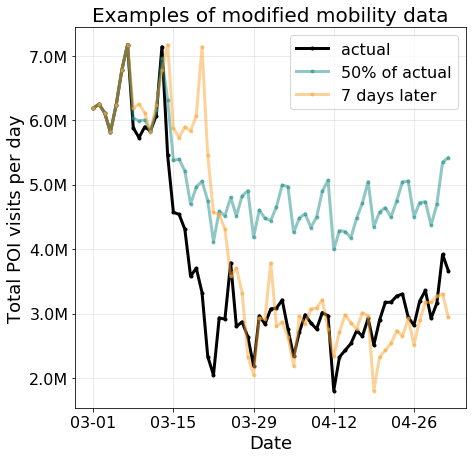

In [9]:
# Figure 2a, left - need to do this after middle and right plots, bc it uses the colors from those plots
lesser_extent = apply_distancing_degree(poi_cbg_visits_list, 0.5)
shifted = apply_shift_in_days(poi_cbg_visits_list, 7)
colors = ['black', degree_colors[2], shift_colors[0]]
fig, ax = plt.subplots(figsize=(7, 7))
make_schematic(poi_cbg_visits_list, lesser_extent, shifted, colors, ax)

## Supplement: counterfactual results for all MSAs

In [72]:
all_ratios = []
cols = None
for msa in MSAS:
    print(msa)
    cols, ratios = get_counterfactual_ratios_at_datetime(counterfactual_df_cases, msa)
    ratios_as_str = []
    for (m, (l,u)) in ratios:
        ratios_as_str.append('%s (%s, %s)' % (m, l, u))
    ratios_as_str.insert(0, MSAS_TO_PRETTY_NAMES[msa])
    all_ratios.append(ratios_as_str)
cols.insert(0, 'MSA_name')
ratios_df = pd.DataFrame(all_ratios, columns=cols)
ratios_df

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


MSA_name         distancing_deg=0   distancing_deg=0.25    distancing_deg=0.5       shift_in_days=7       shift_in_days=3      shift_in_days=-3      shift_in_days=-7
0        Atlanta   16.593 (3.088, 30.532)  7.714 (1.73, 15.833)   2.265 (1.17, 3.673)  1.981 (1.189, 2.761)  1.359 (1.075, 1.741)  0.803 (0.639, 0.956)  0.586 (0.397, 0.834)
1        Chicago       6.202 (5.2, 7.088)  3.329 (2.761, 3.759)  1.587 (1.421, 1.704)  1.542 (1.446, 1.639)  1.226 (1.143, 1.365)  0.848 (0.769, 0.933)  0.641 (0.563, 0.711)
2         Dallas  18.026 (10.361, 27.273)   5.908 (3.75, 8.857)   1.87 (1.532, 2.349)  1.722 (1.487, 1.966)   1.298 (1.09, 1.577)  0.855 (0.693, 1.013)  0.642 (0.495, 0.782)
3        Houston  18.964 (11.949, 32.755)  5.725 (3.761, 9.233)  1.659 (1.362, 2.109)  1.731 (1.493, 2.064)  1.288 (1.079, 1.541)  0.848 (0.663, 1.021)    0.656 (0.5, 0.812)
4    Los Angeles    12.926 (3.15, 24.207)  5.097 (1.779, 9.721)  1.665 (1.176, 2.309)  1.692 (1.216, 2.137)  1.265 (1.041, 1.554)  0.816 (0.639, 0.984)  0.608 (0.407, 0.848)
5          Miami   10.781 (3.382, 15.935)   4.85 (1.886, 7.405)    1.777 (1.208, 2.3)   1.856 (1.281, 2.27)  1.317 (1.117, 1.559)  0.792 (0.669, 0.919)  0.576 (0.424, 0.795)
6  New York City     2.037 (1.902, 2.174)   1.73 (1.603, 1.811)  1.333 (1.258, 1.389)   1.27 (1.246, 1.307)  1.113 (1.094, 1.133)   0.909 (0.89, 0.927)  0.818 (0.795, 0.856)
7   Philadelphia      2.976 (2.734, 3.39)  1.894 (1.747, 2.137)  1.211 (1.141, 1.305)  1.287 (1.246, 1.351)   1.12 (1.031, 1.206)  0.916 (0.823, 1.005)  0.799 (0.731, 0.868)
8  San Francisco    9.743 (7.089, 15.596)  4.282 (3.124, 6.781)  1.714 (1.427, 2.255)  1.689 (1.452, 2.029)  1.271 (1.048, 1.527)  0.815 (0.666, 1.012)  0.609 (0.408, 0.798)
9  Washington DC      5.85 (2.329, 9.713)  3.032 (1.541, 4.646)  1.509 (1.132, 1.959)  1.488 (1.158, 1.789)  1.207 (0.959, 1.586)  0.848 (0.627, 1.045)  0.671 (0.447, 0.879)

In [76]:
cols = ['MSA_name', 'shift_in_days=-7', 'shift_in_days=-3', 'shift_in_days=3', 'shift_in_days=7']
ratios_df[cols].to_latex()

'\\begin{tabular}{llllll}\n\\toprule\n{} &       MSA\\_name &      shift\\_in\\_days=-7 &      shift\\_in\\_days=-3 &       shift\\_in\\_days=3 &       shift\\_in\\_days=7 \\\\\n\\midrule\n0 &        Atlanta &  0.586 (0.397, 0.834) &  0.803 (0.639, 0.956) &  1.359 (1.075, 1.741) &  1.981 (1.189, 2.761) \\\\\n1 &        Chicago &  0.641 (0.563, 0.711) &  0.848 (0.769, 0.933) &  1.226 (1.143, 1.365) &  1.542 (1.446, 1.639) \\\\\n2 &         Dallas &  0.642 (0.495, 0.782) &  0.855 (0.693, 1.013) &   1.298 (1.09, 1.577) &  1.722 (1.487, 1.966) \\\\\n3 &        Houston &    0.656 (0.5, 0.812) &  0.848 (0.663, 1.021) &  1.288 (1.079, 1.541) &  1.731 (1.493, 2.064) \\\\\n4 &    Los Angeles &  0.608 (0.407, 0.848) &  0.816 (0.639, 0.984) &  1.265 (1.041, 1.554) &  1.692 (1.216, 2.137) \\\\\n5 &          Miami &  0.576 (0.424, 0.795) &  0.792 (0.669, 0.919) &  1.317 (1.117, 1.559) &   1.856 (1.281, 2.27) \\\\\n6 &  New York City &  0.818 (0.795, 0.856) &   0.909 (0.89, 0.927) &  1.113 (1.094, 1

In [78]:
cols = ['MSA_name', 'distancing_deg=0', 'distancing_deg=0.25', 'distancing_deg=0.5']
ratios_df[cols].to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} &       MSA\\_name &         distancing\\_deg=0 &   distancing\\_deg=0.25 &    distancing\\_deg=0.5 \\\\\n\\midrule\n0 &        Atlanta &   16.593 (3.088, 30.532) &  7.714 (1.73, 15.833) &   2.265 (1.17, 3.673) \\\\\n1 &        Chicago &       6.202 (5.2, 7.088) &  3.329 (2.761, 3.759) &  1.587 (1.421, 1.704) \\\\\n2 &         Dallas &  18.026 (10.361, 27.273) &   5.908 (3.75, 8.857) &   1.87 (1.532, 2.349) \\\\\n3 &        Houston &  18.964 (11.949, 32.755) &  5.725 (3.761, 9.233) &  1.659 (1.362, 2.109) \\\\\n4 &    Los Angeles &    12.926 (3.15, 24.207) &  5.097 (1.779, 9.721) &  1.665 (1.176, 2.309) \\\\\n5 &          Miami &   10.781 (3.382, 15.935) &   4.85 (1.886, 7.405) &    1.777 (1.208, 2.3) \\\\\n6 &  New York City &     2.037 (1.902, 2.174) &   1.73 (1.603, 1.811) &  1.333 (1.258, 1.389) \\\\\n7 &   Philadelphia &      2.976 (2.734, 3.39) &  1.894 (1.747, 2.137) &  1.211 (1.141, 1.305) \\\\\n8 &  San Francisco &    9.743 (7.089, 15.59

Atlanta_Sandy_Springs_Roswell_GA
Num params x seeds: 480
Num params x seeds: 480
Num params x seeds: 480
Num params x seeds: 480
Num params x seeds: 480
Num params x seeds: 480
Num params x seeds: 480
Num params x seeds: 480
Num params x seeds: 480
Chicago_Naperville_Elgin_IL_IN_WI
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Num params x seeds: 120
Dallas_Fort_Worth_Arlington_TX
Num params x seeds: 150
Num params x seeds: 150
Num params x seeds: 150
Num params x seeds: 150
Num params x seeds: 150
Num params x seeds: 150
Num params x seeds: 150
Num params x seeds: 150
Num params x seeds: 150
Houston_The_Woodlands_Sugar_Land_TX
Num params x seeds: 240
Num params x seeds: 240
Num params x seeds: 240
Num params x seeds: 240
Num params x seeds: 240
Num params x seeds: 240
Num params x seeds: 240
Num params x seeds: 240
Num params x seeds: 240
Lo

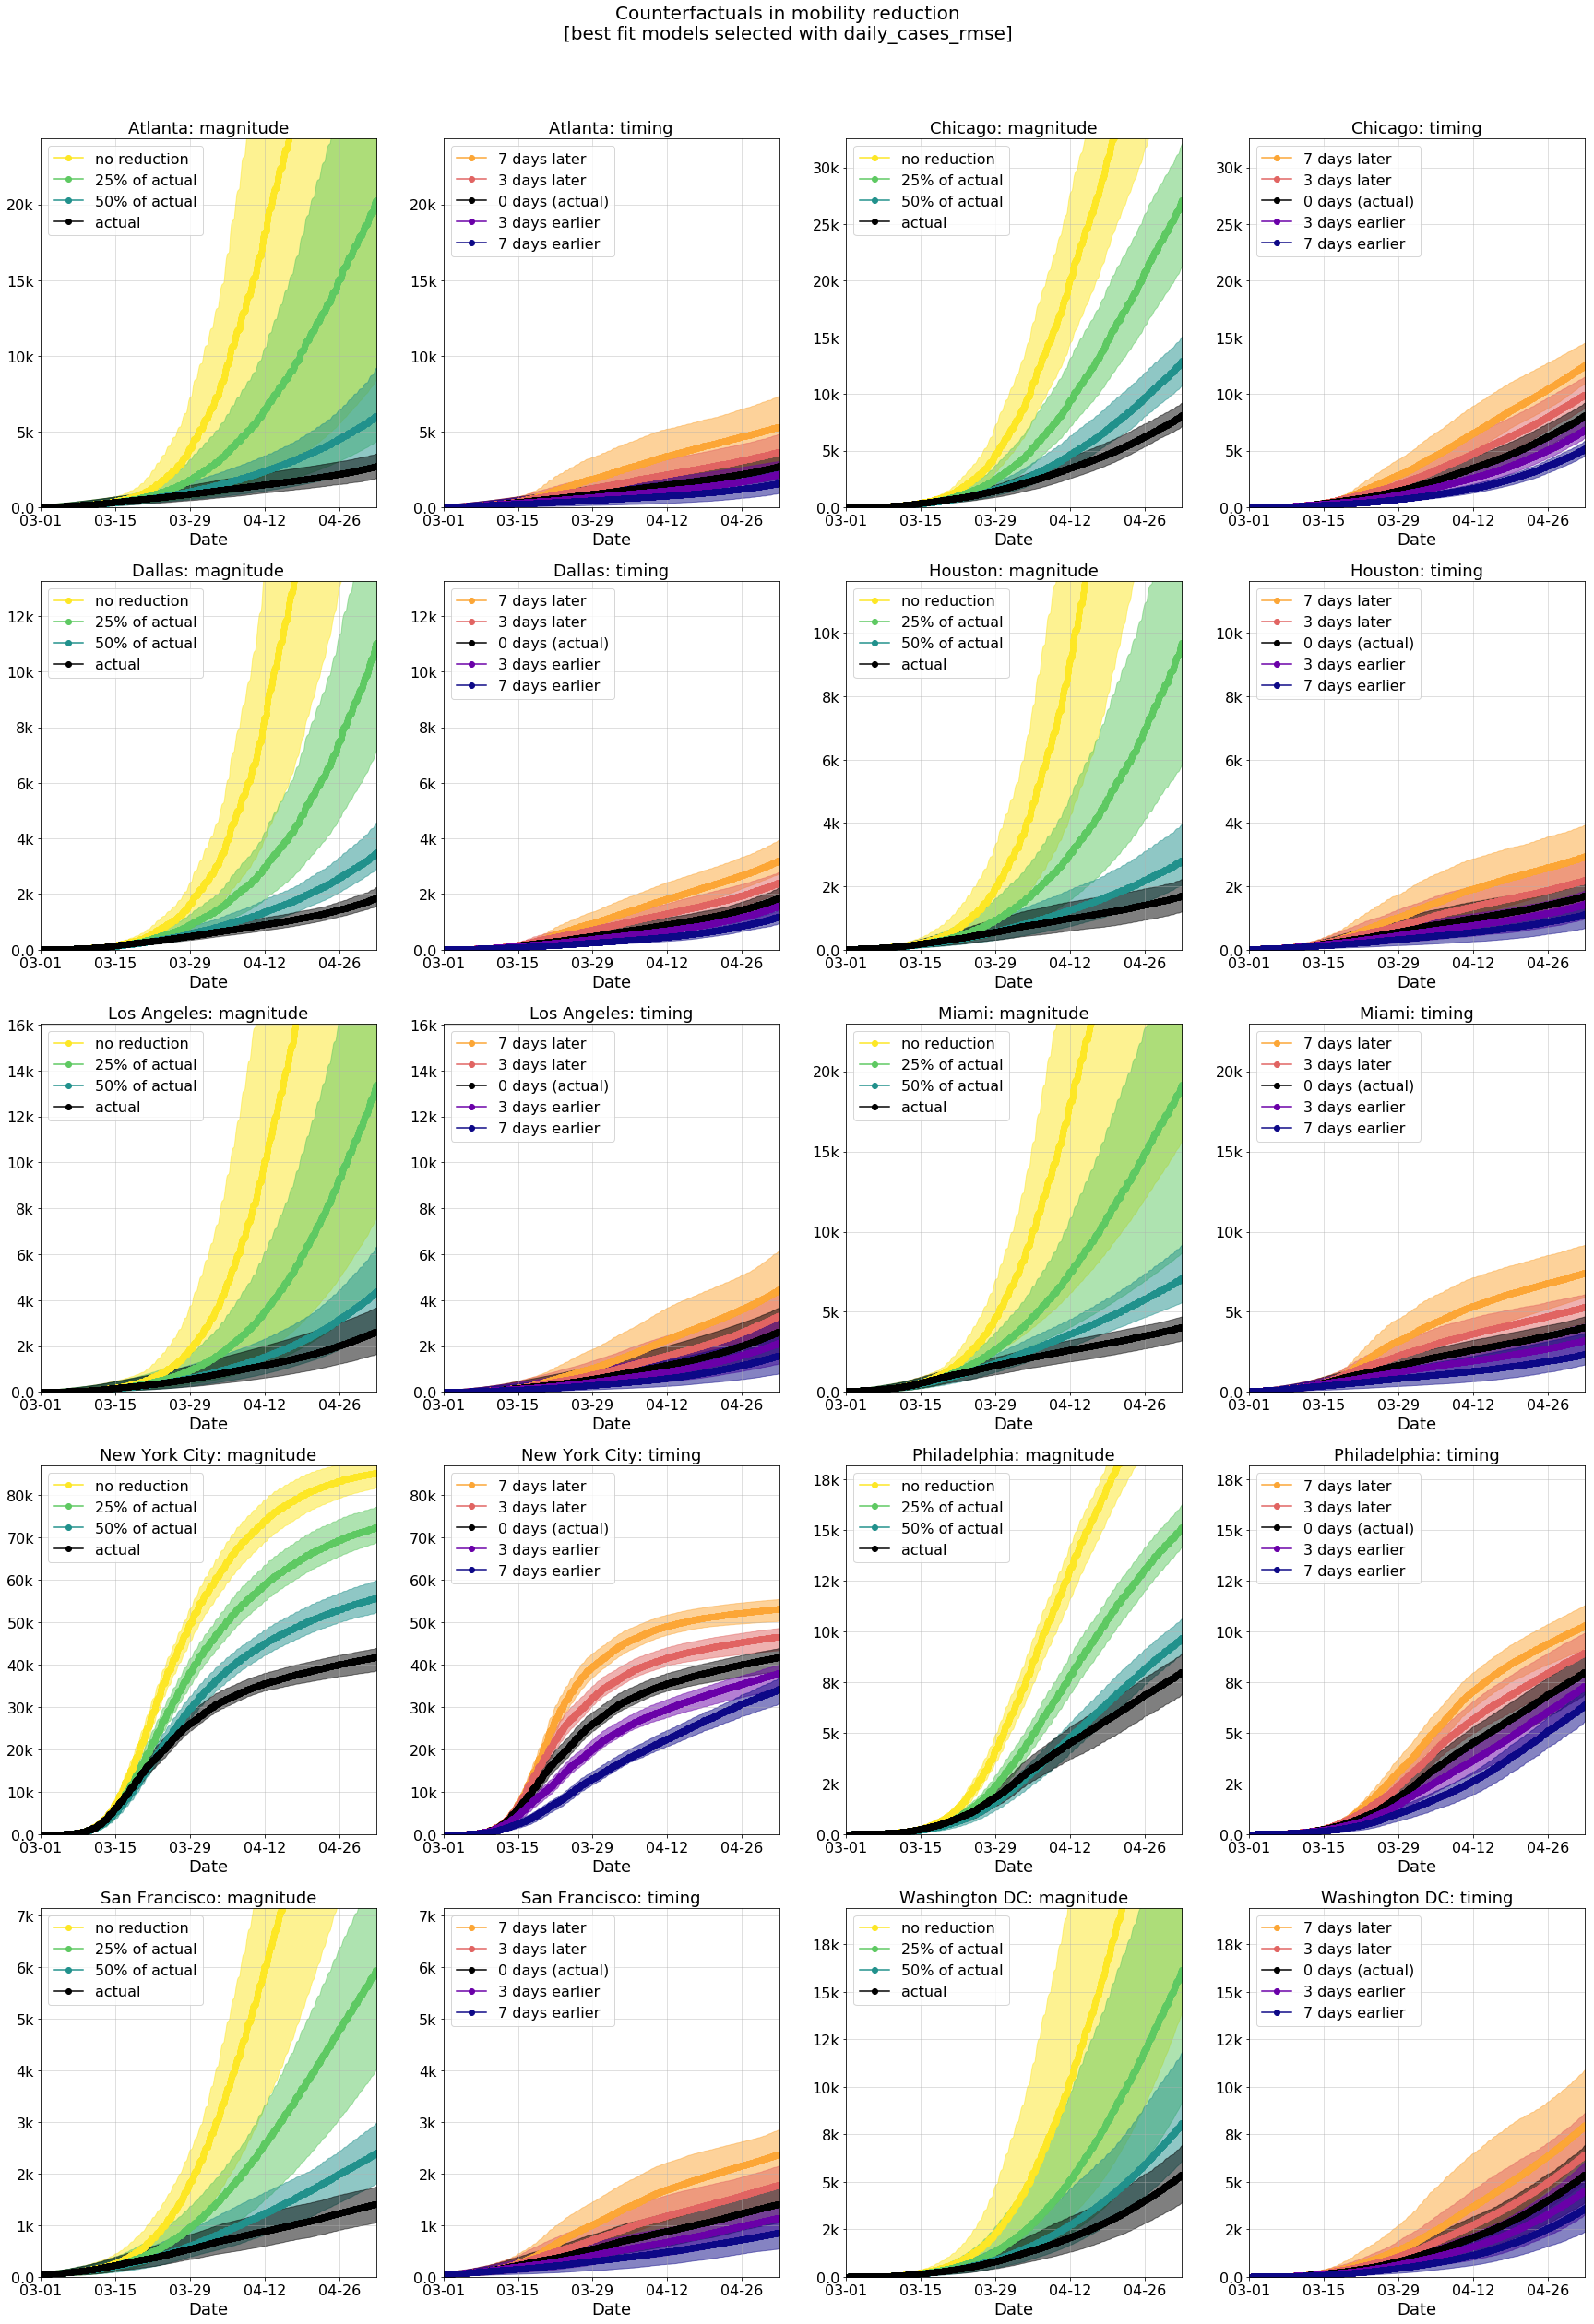

In [22]:
df = counterfactual_df_cases
fig, axes = plt.subplots(5, 4, figsize=(30, 40))
fig.suptitle('Counterfactuals in mobility reduction\n[best fit models selected with daily_cases_rmse]', fontsize=20)
plt.subplots_adjust(top=0.93)
axes = [ax for axes_row in axes for ax in axes_row]
for i, msa in enumerate(MSAS):
    print(msa)
    ax1 = axes[i*2]
    ax2 = axes[(i*2)+1]
    means, colors = make_counterfactual_line_plots(df, msa, ax1, 'degree')
    y_max = means[1][-1] * 1.2
    ax1.set_ylim(0, y_max)
    ax1.set_title('%s: magnitude' % MSAS_TO_PRETTY_NAMES[msa], fontsize=18)
    means, colors = make_counterfactual_line_plots(df, msa, ax2, 'shift', 
                                                   cmap_str='plasma', y_lim=(0, y_max))
    ax2.set_title('%s: timing' % MSAS_TO_PRETTY_NAMES[msa], fontsize=18)

## Figure 2b: super-spreader plot for highlighted MSA

In [4]:
min_timestring = '2020_07_22'
superspreader_df = evaluate_all_fitted_models_for_experiment('rerun_best_models_and_save_cases_per_poi', 
                                                              min_timestring=min_timestring)
superspreader_df['MSA_name'] = superspreader_df['data_kwargs'].map(lambda x:x['MSA_name'])
superspreader_df['original_timestring'] = superspreader_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
superspreader_df['how_to_select_best_grid_search_models'] = superspreader_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])

superspreader_df_cases = superspreader_df.loc[superspreader_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
superspreader_df_deaths = superspreader_df.loc[superspreader_df['how_to_select_best_grid_search_models'] == 'daily_deaths_rmse'].copy()
superspreader_df_poisson = superspreader_df.loc[superspreader_df['how_to_select_best_grid_search_models'] == 'daily_cases_poisson'].copy()

print('Found %d models for selecting with RMSE cases, %d for RMSE deaths, %d for Poisson cases' % 
       (len(superspreader_df_cases), len(superspreader_df_deaths), len(superspreader_df_poisson)))


Loading models with timestrings between 2020_07_22 and 2020_07_29_11_30_35_126402
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 400 fitted models for rerun_best_models_and_save_cases_per_poi
Loaded 1 models so far: 0.005s -> 0.005s per model
Time to load and score all models: 1.072s -> 0.003s per model
Found 97 models for selecting with RMSE cases, 251 for RMSE deaths, 52 for Poisson cases


In [33]:
superspreader_df_cases['rmse_ratio'] = superspreader_df_cases['model_kwargs'].map(lambda x:x['model_quality_dict']['ratio_of_loss_dict_daily_cases_RMSE_to_that_of_best_fitting_model'])
superspreader_df_cases_10 = superspreader_df_cases[superspreader_df_cases['rmse_ratio'] <= 1.10]
print('Found %d models for selecting with RMSE cases 10%% threshold' % len(superspreader_df_cases_10))

Found 45 models for selecting with RMSE cases 10% threshold


/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Spearman correlations (across POIs) between POI characteristics and fraction of total infections at POI
mean_frac_of_infections_at_poi     1.000000
density*dwell_time_factor          0.778464
visits^2*dwell_time_factor/area    0.879511
weighted_visits_over_area          0.514050
weighted_visits                    0.224283
dwell_time                         0.496902
Name: mean_frac_of_infections_at_poi, dtype: float64
infectiousness_group               bottom 90%    top 10%
mean_frac_of_infections_at_poi   7.535631e-07   0.000055
density*dwell_time_factor        8.678862e-05   0.001074
visits^2*dwell_time_factor/area  1.983717e-01   4.081145
weighted_visits_over_area        1.273242e-03   0.004108
weighted_visits                  9.284951e+00  10.708163
dwell_time                       2.300000e+01  81.000000


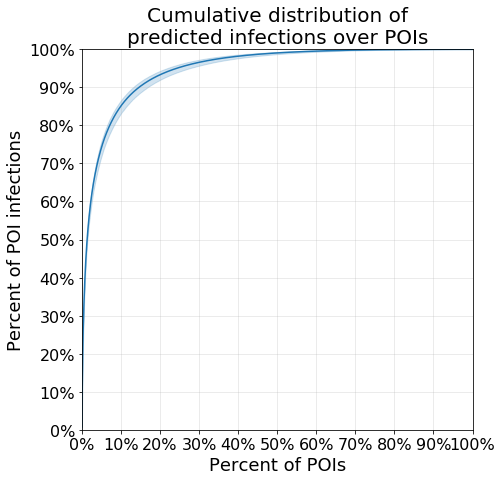

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
out = make_superspreader_plot_for_msa(superspreader_df_cases, HIGHLIGHT_MSA, ax, 
                                poi_and_cbg_characteristics=poi_and_cbg_characteristics)

In [14]:
print('top 10 / bottom 90 weighted_visits_over_area:', 0.004108 / 1.273242e-03)
print('top 10 / bottom 90 dwell_time:', 81.000000 / 2.300000e+01)

top 10 / bottom 90 weighted_visits_over_area: 3.2264094335562286
top 10 / bottom 90 dwell_time: 3.5217391304347827


In [11]:
# get mean and CI for 10% 
all_poi_fracs_for_city = out[1]
cumulative_poi_fracs = np.cumsum(all_poi_fracs_for_city, axis=1)
x = np.linspace(0, 1, cumulative_poi_fracs.shape[1])
lower_CI = np.percentile(cumulative_poi_fracs, LOWER_PERCENTILE, axis=0)
upper_CI = np.percentile(cumulative_poi_fracs, UPPER_PERCENTILE, axis=0)
y = np.mean(cumulative_poi_fracs, axis=0)

index = np.argmin(np.abs(x - 0.1))
indices = [index-1, index, index+1]
print('x', x[indices])
print('mean', y[indices])
print('lower', lower_CI[indices])
print('upper', upper_CI[indices])

x [0.09998558 0.1000016  0.10001762]
mean [0.85124669 0.85126936 0.85129202]
lower [0.83140651 0.83141254 0.8314342 ]
upper [0.86599221 0.86601499 0.86604302]


## Supplement: super-spreader plots for all MSAs, all model selection metrics

Atlanta_Sandy_Springs_Roswell_GA: mean=0.752, lower CI=0.651, upper CI=0.807
Chicago_Naperville_Elgin_IL_IN_WI: mean=0.851, lower CI=0.831, upper CI=0.866
Dallas_Fort_Worth_Arlington_TX: mean=0.848, lower CI=0.802, upper CI=0.875
Houston_The_Woodlands_Sugar_Land_TX: mean=0.859, lower CI=0.823, upper CI=0.892
Los_Angeles_Long_Beach_Anaheim_CA: mean=0.848, lower CI=0.744, upper CI=0.895
Miami_Fort_Lauderdale_West_Palm_Beach_FL: mean=0.814, lower CI=0.716, upper CI=0.855
New_York_Newark_Jersey_City_NY_NJ_PA: mean=0.777, lower CI=0.761, upper CI=0.789
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD: mean=0.956, lower CI=0.943, upper CI=0.968
San_Francisco_Oakland_Hayward_CA: mean=0.926, lower CI=0.893, upper CI=0.954
Washington_Arlington_Alexandria_DC_VA_MD_WV: mean=0.884, lower CI=0.795, upper CI=0.915
over means: min=0.752, mean=0.852, median=0.850, max=0.956
min lower CI = 0.651
max upper CI = 0.968


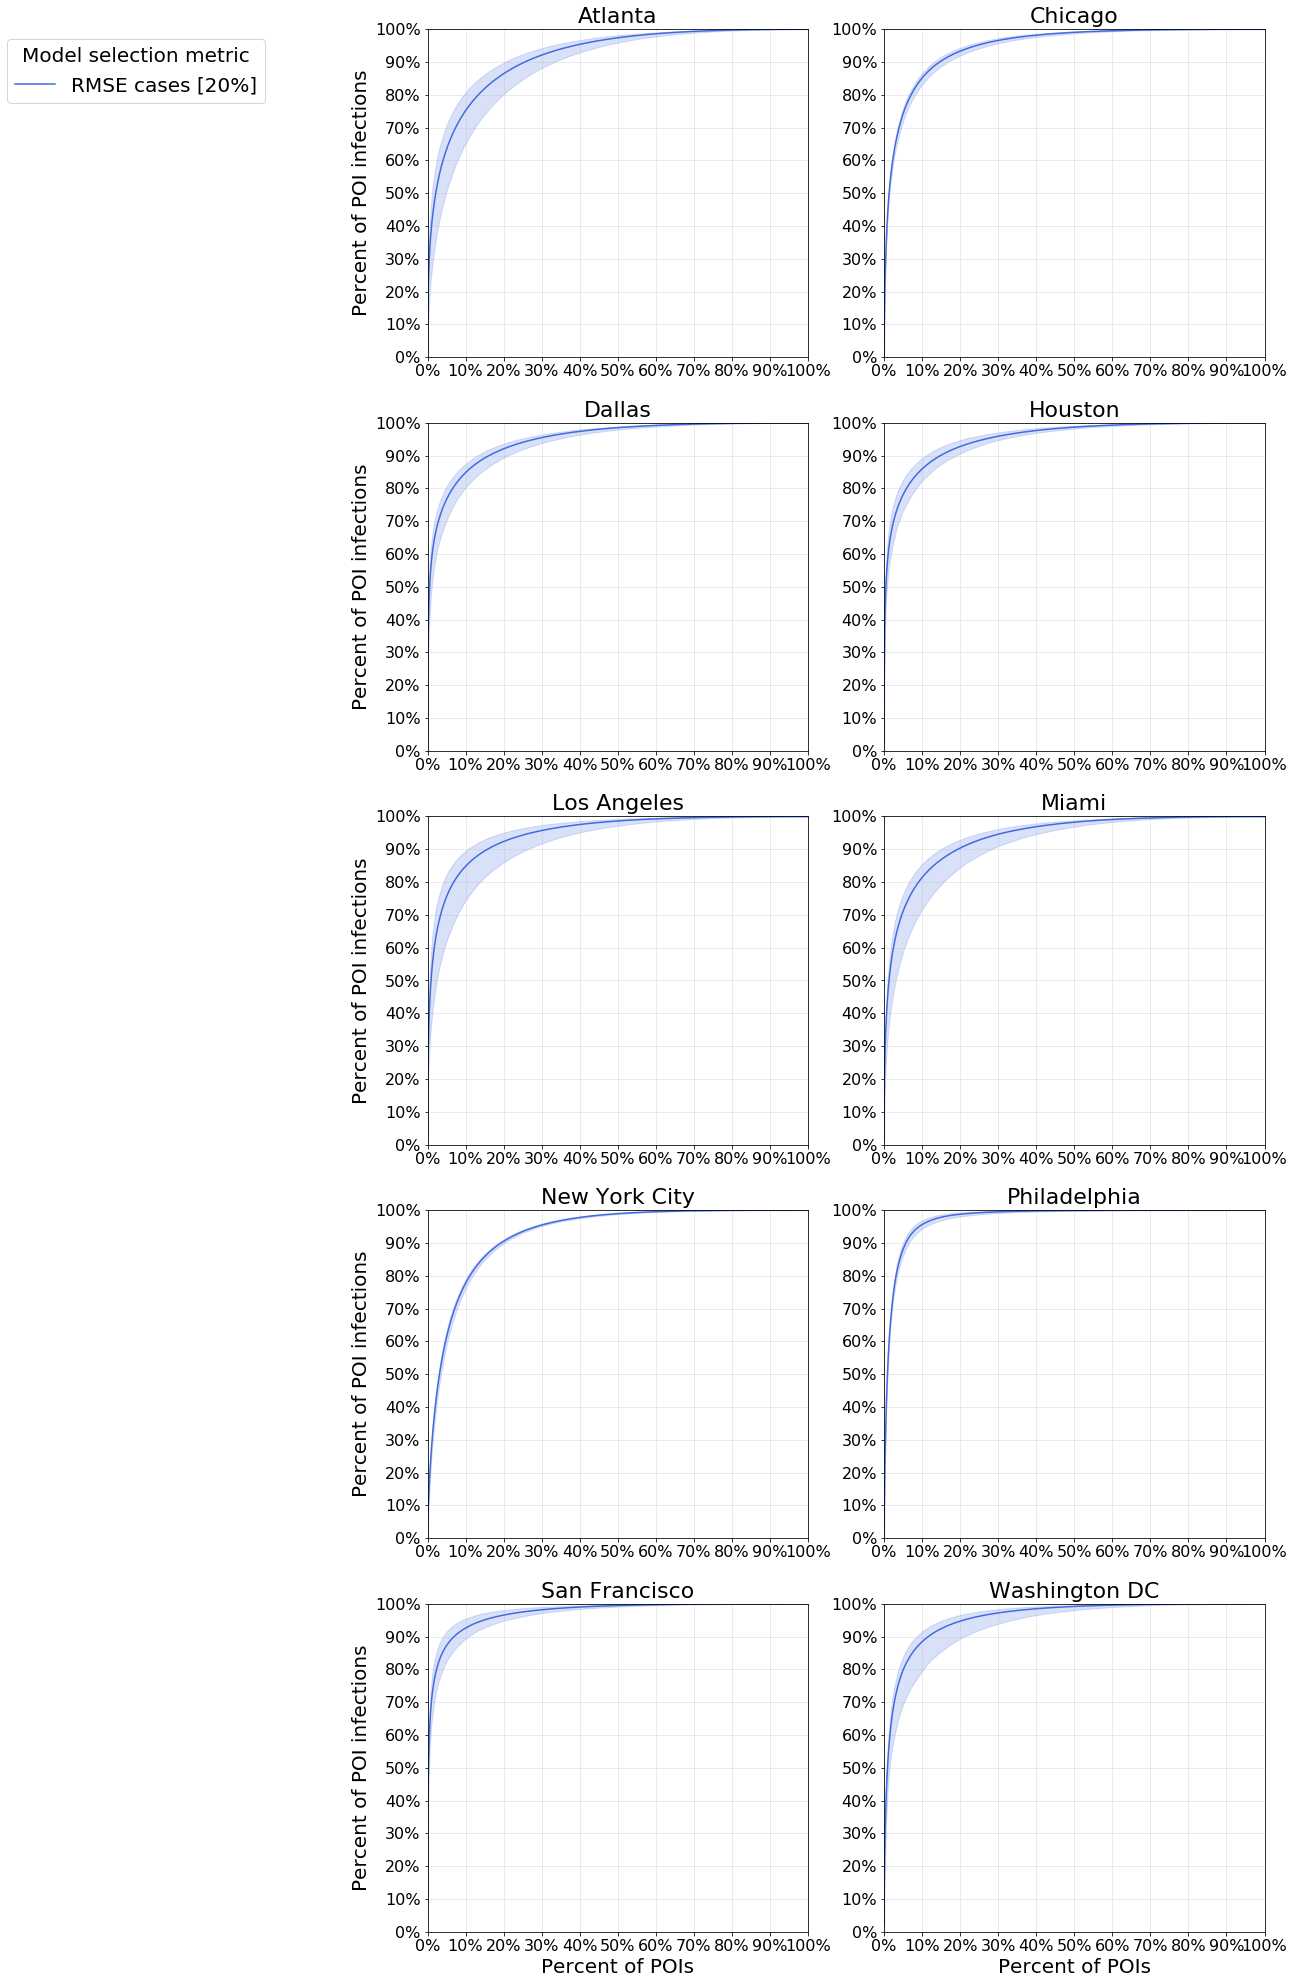

In [57]:
# only default metric
fig, axes = plt.subplots(5, 2, figsize=[15, 35])
axes = [ax for axes_row in axes for ax in axes_row]
means = []
lower_bounds = []
upper_bounds = []
for msa_idx, msa in enumerate(MSAS):
    ax = axes[msa_idx]
    prop_from_pois_df, all_poi_fracs_for_city = make_superspreader_plot_for_msa(superspreader_df_cases, msa, ax, set_labels=False, 
                                      line_label='RMSE cases [20%]', color='royalblue')
    cumulative_poi_fracs = np.cumsum(all_poi_fracs_for_city, axis=1)
    x = np.linspace(0, 1, cumulative_poi_fracs.shape[1])
    lower_CI = np.percentile(cumulative_poi_fracs, LOWER_PERCENTILE, axis=0)
    upper_CI = np.percentile(cumulative_poi_fracs, UPPER_PERCENTILE, axis=0)
    y = np.mean(cumulative_poi_fracs, axis=0)
    index = np.argmin(np.abs(x - 0.1))
    print('%s: mean=%.3f, lower CI=%.3f, upper CI=%.3f' % (msa, y[index], lower_CI[index], upper_CI[index]))
    means.append(y[index])
    lower_bounds.append(lower_CI[index])
    upper_bounds.append(upper_CI[index])
      
    if msa_idx % 2 == 0:
        ax.set_ylabel("Percent of POI infections", fontsize=20)   
    if msa_idx >= 8:
        ax.set_xlabel("Percent of POIs", fontsize=20)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=22)
    if msa_idx == 0:
        ax.legend(bbox_to_anchor=(-0.4, 1), title='Model selection metric', fontsize=20, title_fontsize=20)
print('over means: min=%.3f, mean=%.3f, median=%.3f, max=%.3f' % 
      (np.min(means), np.mean(means), np.median(means), np.max(means)))
print('min lower CI = %.3f' % np.min(lower_bounds))
print('max upper CI = %.3f' % np.max(upper_bounds))

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


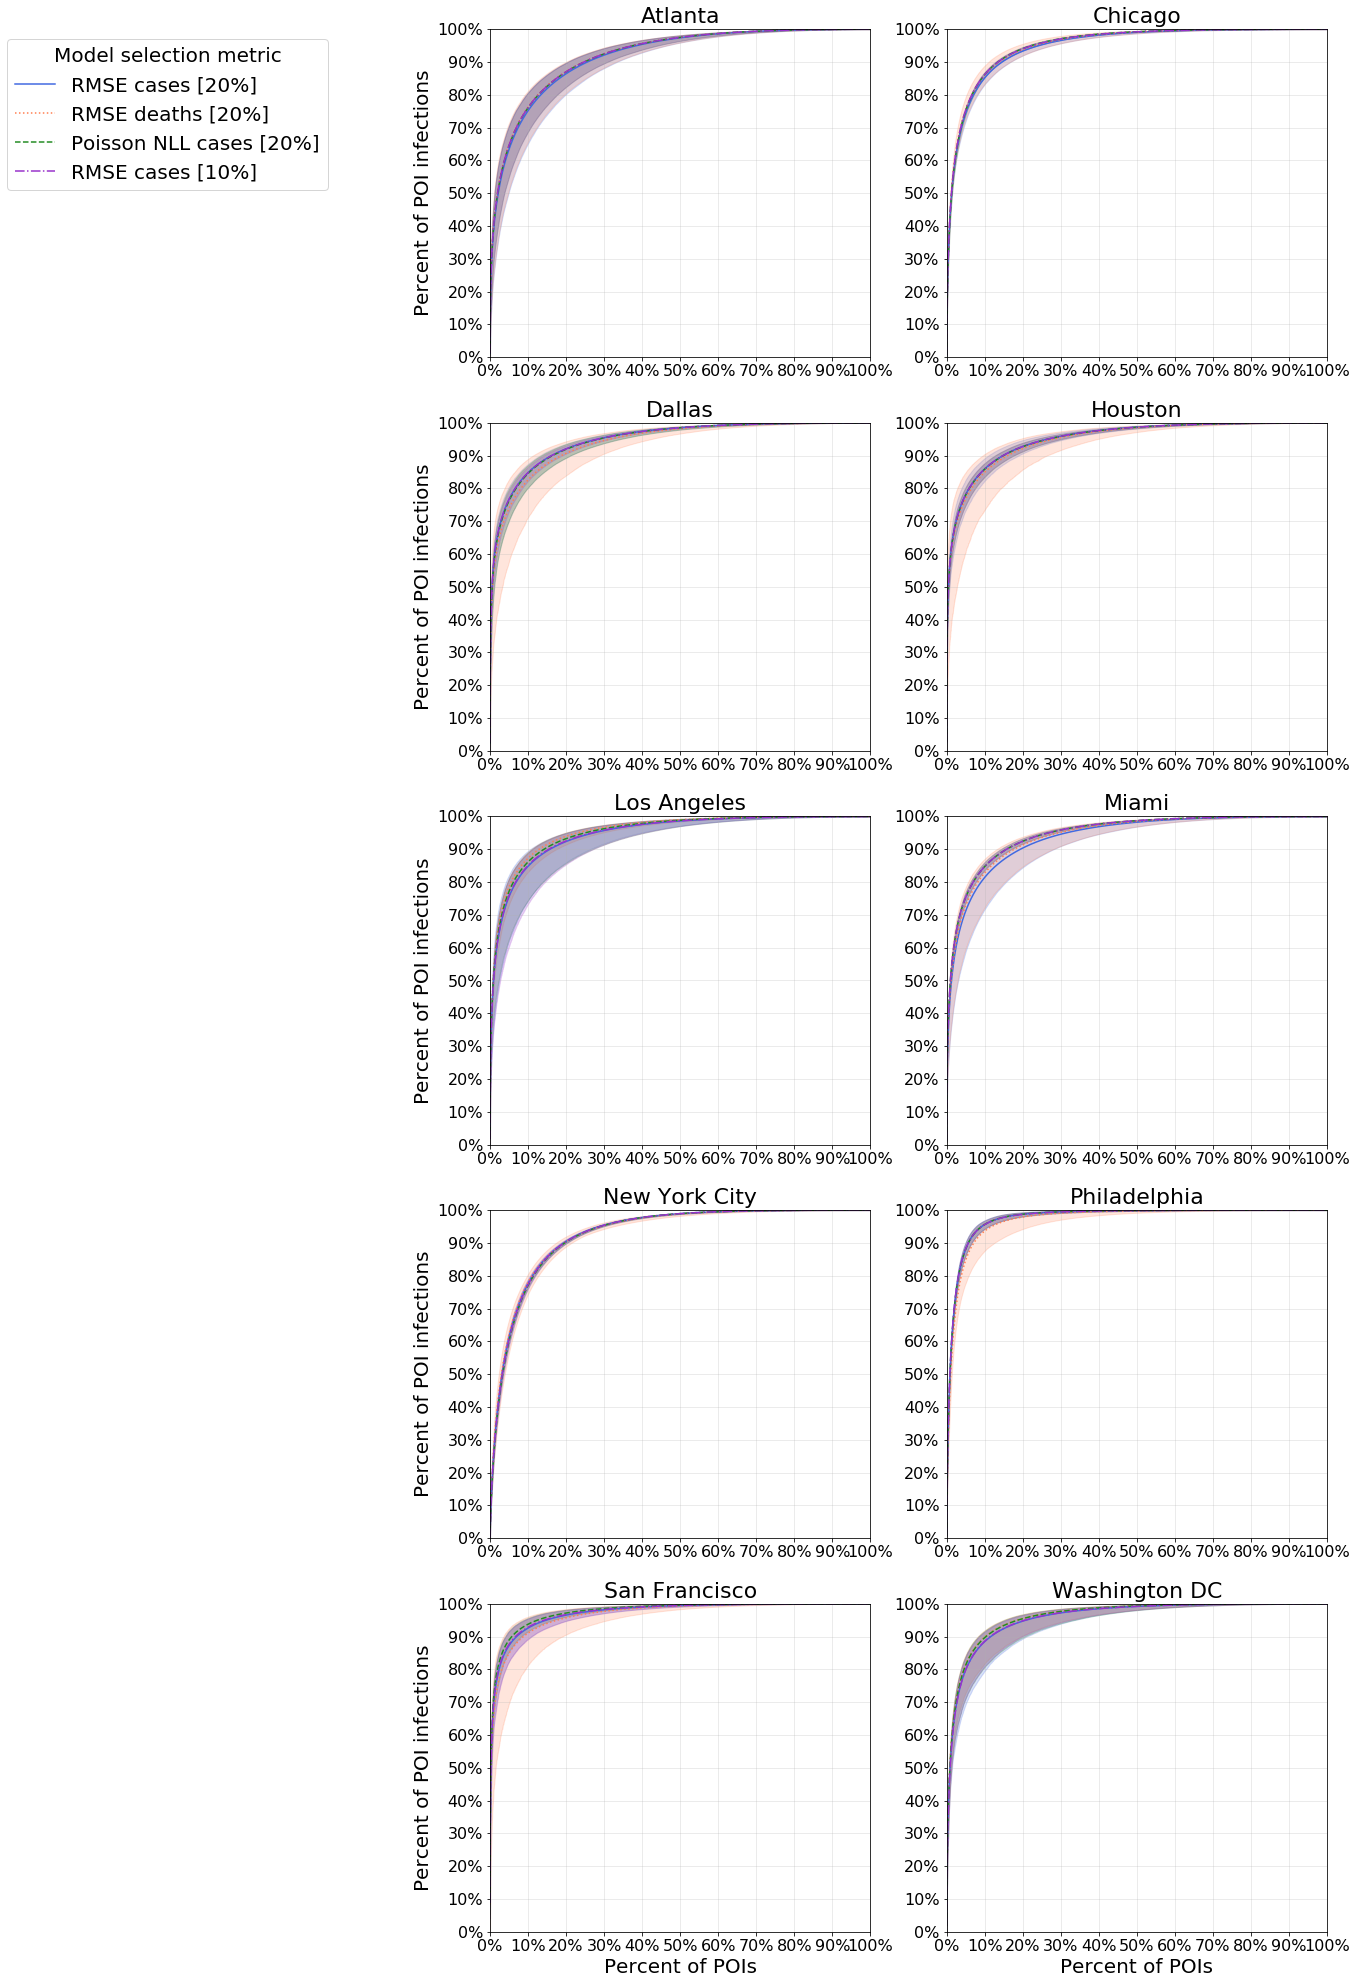

In [194]:
# all metrics
fig, axes = plt.subplots(5, 2, figsize=[15, 35])
axes = [ax for axes_row in axes for ax in axes_row]
all_proportions_of_total_infections_from_pois = []
for msa_idx, msa in enumerate(MSAS):
    print(msa)
    ax = axes[msa_idx]
    prop_from_pois_df, _ = make_superspreader_plot_for_msa(superspreader_df_cases, msa, ax, set_labels=False, 
                                      line_label='RMSE cases [20%]', color='royalblue')
    all_proportions_of_total_infections_from_pois.append(prop_from_pois_df)
    out = make_superspreader_plot_for_msa(superspreader_df_deaths, msa, ax, set_labels=False, 
                                      color='coral', line_label='RMSE deaths [20%]', linestyle='dotted')
    out = make_superspreader_plot_for_msa(superspreader_df_poisson, msa, ax, set_labels=False,
                                      color='forestgreen', line_label='Poisson NLL cases [20%]', linestyle='dashed')
    out = make_superspreader_plot_for_msa(superspreader_df_cases_10, msa, ax, set_labels=False,
                                      color='darkorchid', line_label='RMSE cases [10%]', linestyle='dashdot')
    
    if msa_idx % 2 == 0:
        ax.set_ylabel("Percent of POI infections", fontsize=20)   
    if msa_idx >= 8:
        ax.set_xlabel("Percent of POIs", fontsize=20)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=22)
    if msa_idx == 0:
        ax.legend(bbox_to_anchor=(-0.4, 1), title='Model selection metric', fontsize=20, title_fontsize=20)

In [46]:
prop_infections_from_pois_to_plot = pd.concat(all_proportions_of_total_infections_from_pois)
print(prop_infections_from_pois_to_plot.groupby('msa').agg(['min', 'mean', 'median', 'max', 'size']))
print("\nOverall stats for medians of MSAs")
print(prop_infections_from_pois_to_plot.groupby('msa').agg('median').agg(['min', 'mean', 'median', 'max', 'size']))

                                            prop_total_infections_from_pois  \
                                                                        min   
msa                                                                           
Atlanta_Sandy_Springs_Roswell_GA                                   0.111430   
Chicago_Naperville_Elgin_IL_IN_WI                                  0.408003   
Dallas_Fort_Worth_Arlington_TX                                     0.363840   
Houston_The_Woodlands_Sugar_Land_TX                                0.472596   
Los_Angeles_Long_Beach_Anaheim_CA                                  0.106390   
Miami_Fort_Lauderdale_West_Palm_Beach_FL                           0.198974   
New_York_Newark_Jersey_City_NY_NJ_PA                               0.648472   
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD                         0.590170   
San_Francisco_Oakland_Hayward_CA                                   0.427995   
Washington_Arlington_Alexandria_DC_VA_MD_WV         

## Figure 2c: partial reopening results for highlighted MSA

In [15]:
# load partial reopening with clipping models
min_timestring = '2020_07_22'
max_cap_df = evaluate_all_fitted_models_for_experiment('test_max_capacity_clipping', 
                                                       min_timestring=min_timestring)
max_cap_df['MSA_name'] = max_cap_df['data_kwargs'].map(lambda x:x['MSA_name'])

k = 'max_capacity_alpha'
max_cap_df['counterfactual_%s' % k] = max_cap_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k] if k in x else np.nan)
# counterfactual_baseline_models are best-fit models to real data.
max_cap_df['counterfactual_baseline_model'] = max_cap_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
max_cap_df['baseline_model_quality'] = max_cap_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])
max_cap_df['how_to_select_best_grid_search_models'] = max_cap_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])
max_cap_cases = max_cap_df.loc[max_cap_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
print('Found %d models for selecting with RMSE cases' % len(max_cap_cases))

Loading models with timestrings between 2020_07_22 and 2020_07_29_12_46_57_636597
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 5716 fitted models for test_max_capacity_clipping
Loaded 1 models so far: 0.006s -> 0.006s per model
Loaded 1001 models so far: 4.107s -> 0.004s per model
Loaded 2001 models so far: 8.307s -> 0.004s per model
Loaded 3001 models so far: 12.531s -> 0.004s per model
Loaded 4001 models so far: 16.676s -> 0.004s per model
Loaded 5001 models so far: 20.926s -> 0.004s per model
Time to load and score all models: 24.081s -> 0.004s per model
Found 970 models for selecting with RMSE cases


In [17]:
extra_weeks_to_simulate = max_cap_df.iloc[0]['counterfactual_poi_opening_experiment_kwargs']['extra_weeks_to_simulate']
intervention_datetime = max_cap_df.iloc[0]['counterfactual_poi_opening_experiment_kwargs']['intervention_datetime']
full_activity, intervention_idx = get_full_activity_num_visits(HIGHLIGHT_MSA, 
                                                               intervention_datetime=intervention_datetime,
                                                               extra_weeks_to_simulate=extra_weeks_to_simulate, 
                                                               min_datetime=MIN_DATETIME, 
                                                               max_datetime=MAX_DATETIME)
print(full_activity, intervention_idx)

192061262.77949613 1464


Num params * seeds: 120
Visits lost: [0.6635728796473398, 0.419164700164337, 0.2581554232757484, 0.15586810699022838, 0.09037350814386139, 0.050622170127604844, 0.026012676695889338, 0.011795055644529994, 0.003997263969516019, 1.5517091763533338e-16]
Visits kept: [0.33642712 0.5808353  0.74184458 0.84413189 0.90962649 0.94937783
 0.97398732 0.98820494 0.99600274 1.        ]
Infections: [10723.825255664653, 13871.1584336976, 18811.369178091554, 24196.371552994355, 29078.879255654232, 32901.88203221404, 35777.70388608569, 37724.216735225986, 38939.42406501088, 39655.43505298847]


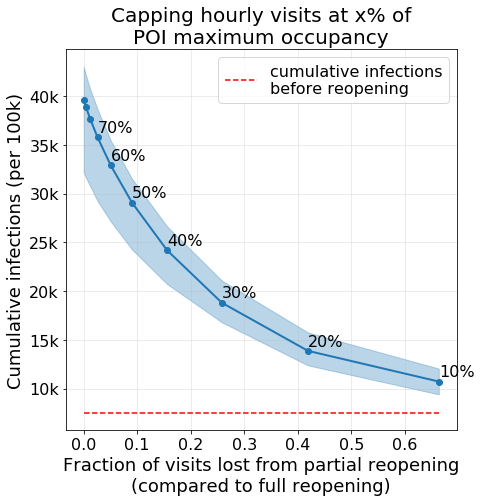

In [104]:
# Make figure 2c, left. 
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=False, 
                                           full_activity_num_visits=full_activity)
fig, ax = plt.subplots(figsize=(7, 7))
make_pareto_plot(X, Y_min, Y_mean, Y_max, ax, all_intervention_lir=all_intervention_lir, 
                 color='tab:blue', point_labels=vals, annotation_color='black')
print('Visits lost:', X)
print('Visits kept:', 1 - np.array(X))
print('Infections:', Y_mean)
x_lim = ax.get_xlim()
plt.show()

In [102]:
# load partial reopening with uniform reduction models
min_timestring = '2020_07_22'
uniform_df = evaluate_all_fitted_models_for_experiment('test_uniform_proportion_of_full_reopening', 
                                                       min_timestring=min_timestring)
uniform_df['MSA_name'] = uniform_df['data_kwargs'].map(lambda x:x['MSA_name'])
k = 'full_activity_alpha'
uniform_df['counterfactual_%s' % k] = uniform_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k] if k in x else np.nan)
uniform_df['counterfactual_baseline_model'] = uniform_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
uniform_df['baseline_model_quality'] = uniform_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])

Loading models with timestrings between 2020_07_22 and 2020_07_29_22_37_29_365151
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 970 fitted models for test_uniform_proportion_of_full_reopening
Loaded 1 models so far: 0.009s -> 0.009s per model
Time to load and score all models: 4.768s -> 0.005s per model


Found 40 rows for MSA in max cap and 40 rows for MSA in uniform
Comparing max_cap_alpha=0.10 to full_activity_alpha=0.34
Num params * seeds: 120
Comparing max_cap_alpha=0.20 to full_activity_alpha=0.58
Num params * seeds: 120
Comparing max_cap_alpha=0.30 to full_activity_alpha=0.74
Num params * seeds: 120
Comparing max_cap_alpha=0.40 to full_activity_alpha=0.84
Num params * seeds: 120
Comparing max_cap_alpha=0.50 to full_activity_alpha=0.91
Num params * seeds: 120
Comparing max_cap_alpha=0.60 to full_activity_alpha=0.95
Num params * seeds: 120
Comparing max_cap_alpha=0.70 to full_activity_alpha=0.97
Num params * seeds: 120
Comparing max_cap_alpha=0.80 to full_activity_alpha=0.99
Num params * seeds: 120
Comparing max_cap_alpha=0.90 to full_activity_alpha=1.00
Num params * seeds: 120
Comparing max_cap_alpha=1.00 to full_activity_alpha=1.00
Num params * seeds: 120
X [0.6635728796473398, 0.419164700164337, 0.2581554232757484, 0.15586810699022838, 0.09037350814386139, 0.050622170127604844, 

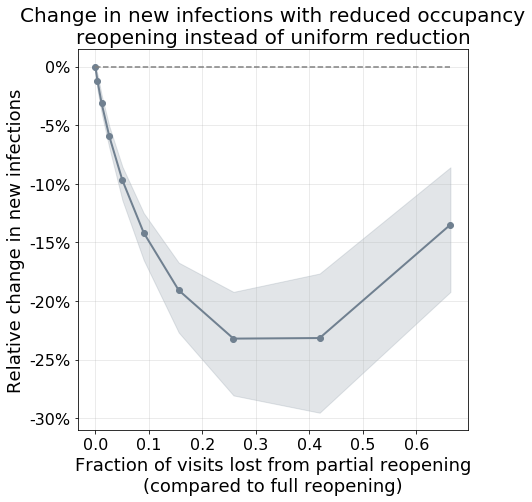

In [105]:
# Make figure 2c, right. 
fig, ax = plt.subplots(figsize=(7, 7))
X, Y_mean, Y_lower, Y_upper = plot_pairwise_comparison(max_cap_cases, uniform_df, HIGHLIGHT_MSA, full_activity, 
                                                      intervention_idx, ax, x_lim=x_lim, mode='percent_change')
plt.show()

## Figure 3f: disparities in partial reopening for highlighted MSA

Num params * seeds: 120
Overall X: [0.6635728796473398, 0.419164700164337, 0.2581554232757484, 0.15586810699022838, 0.09037350814386139, 0.050622170127604844, 0.026012676695889338, 0.011795055644529994, 0.003997263969516019, 1.5517091763533338e-16]
Overall Y lower: [1688.8100827382632, 4569.098953256386, 9794.963419679101, 13762.591893300178, 17271.374838131796, 20130.587286208352, 22203.47107179588, 23653.228037180445, 24626.428002291945, 25165.8499465905]
Overall Y means: [3202.3155949678085, 6348.444605011101, 11287.785431243901, 16672.329902728794, 21554.51892493193, 25377.409520071003, 28253.203431017544, 30199.652036013304, 31414.814050731966, 32130.80799434468]
Overall Y upper: [4552.281819264374, 8336.593477836113, 13785.670127229958, 19396.850978200684, 24293.463794179854, 28169.01213516168, 31088.679388515055, 32947.67737259279, 34390.19359677956, 35207.599135024706]
Num params * seeds: 120
Bottom decile Y lower: [3031.1037925544742, 7380.864593387752, 14151.629754190431, 189

Text(0.5, 1.0, 'Chicago MSA: predicted disparities\nof reduced occupancy reopening')

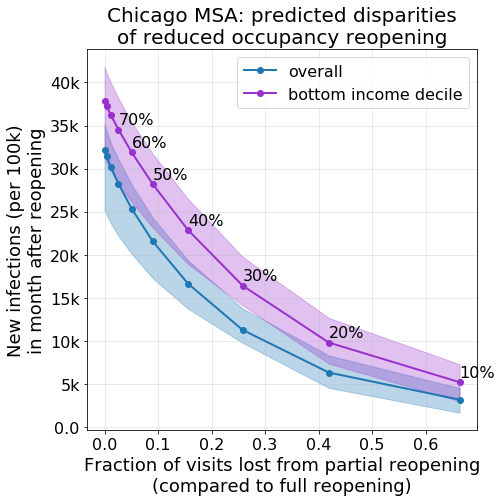

In [106]:
# we include Figure 3f here with Figure 2c bc they are both analyzing the impacts of the 
# clipping reopening strategy and they share code
fig, ax = plt.subplots(figsize=(7, 7))
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=full_activity, cbg_group='all')
make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                 color='tab:blue', set_axis_labels=False, line_label='overall')
print('Overall X:', X)
print('Overall Y lower:', Y_min)
print('Overall Y means:', Y_mean)
print('Overall Y upper:', Y_max)
X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, HIGHLIGHT_MSA, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=full_activity, cbg_group=LOWINCOME)

make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                 color='darkorchid', point_labels=vals, annotation_color='black', line_label='bottom income decile')
print('Bottom decile Y lower:', Y_min)
print('Bottom decile Y means:', Y_mean)
print('Bottom decile Y upper:', Y_max)
ax.set_title('%s MSA: predicted disparities\nof reduced occupancy reopening' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA], fontsize=20)

## Supplement: disparities in partial reopening for all MSAs

Atlanta_Sandy_Springs_Roswell_GA
Num params * seeds: 480
Num params * seeds: 480
Chicago_Naperville_Elgin_IL_IN_WI
Num params * seeds: 120
Num params * seeds: 120
Dallas_Fort_Worth_Arlington_TX
Num params * seeds: 150
Num params * seeds: 150
Houston_The_Woodlands_Sugar_Land_TX
Num params * seeds: 240
Num params * seeds: 240
Los_Angeles_Long_Beach_Anaheim_CA
Num params * seeds: 750
Num params * seeds: 750
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Num params * seeds: 210
Num params * seeds: 210
New_York_Newark_Jersey_City_NY_NJ_PA
Num params * seeds: 210
Num params * seeds: 210
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Num params * seeds: 90
Num params * seeds: 90
San_Francisco_Oakland_Hayward_CA
Num params * seeds: 150
Num params * seeds: 150
Washington_Arlington_Alexandria_DC_VA_MD_WV
Num params * seeds: 510
Num params * seeds: 510


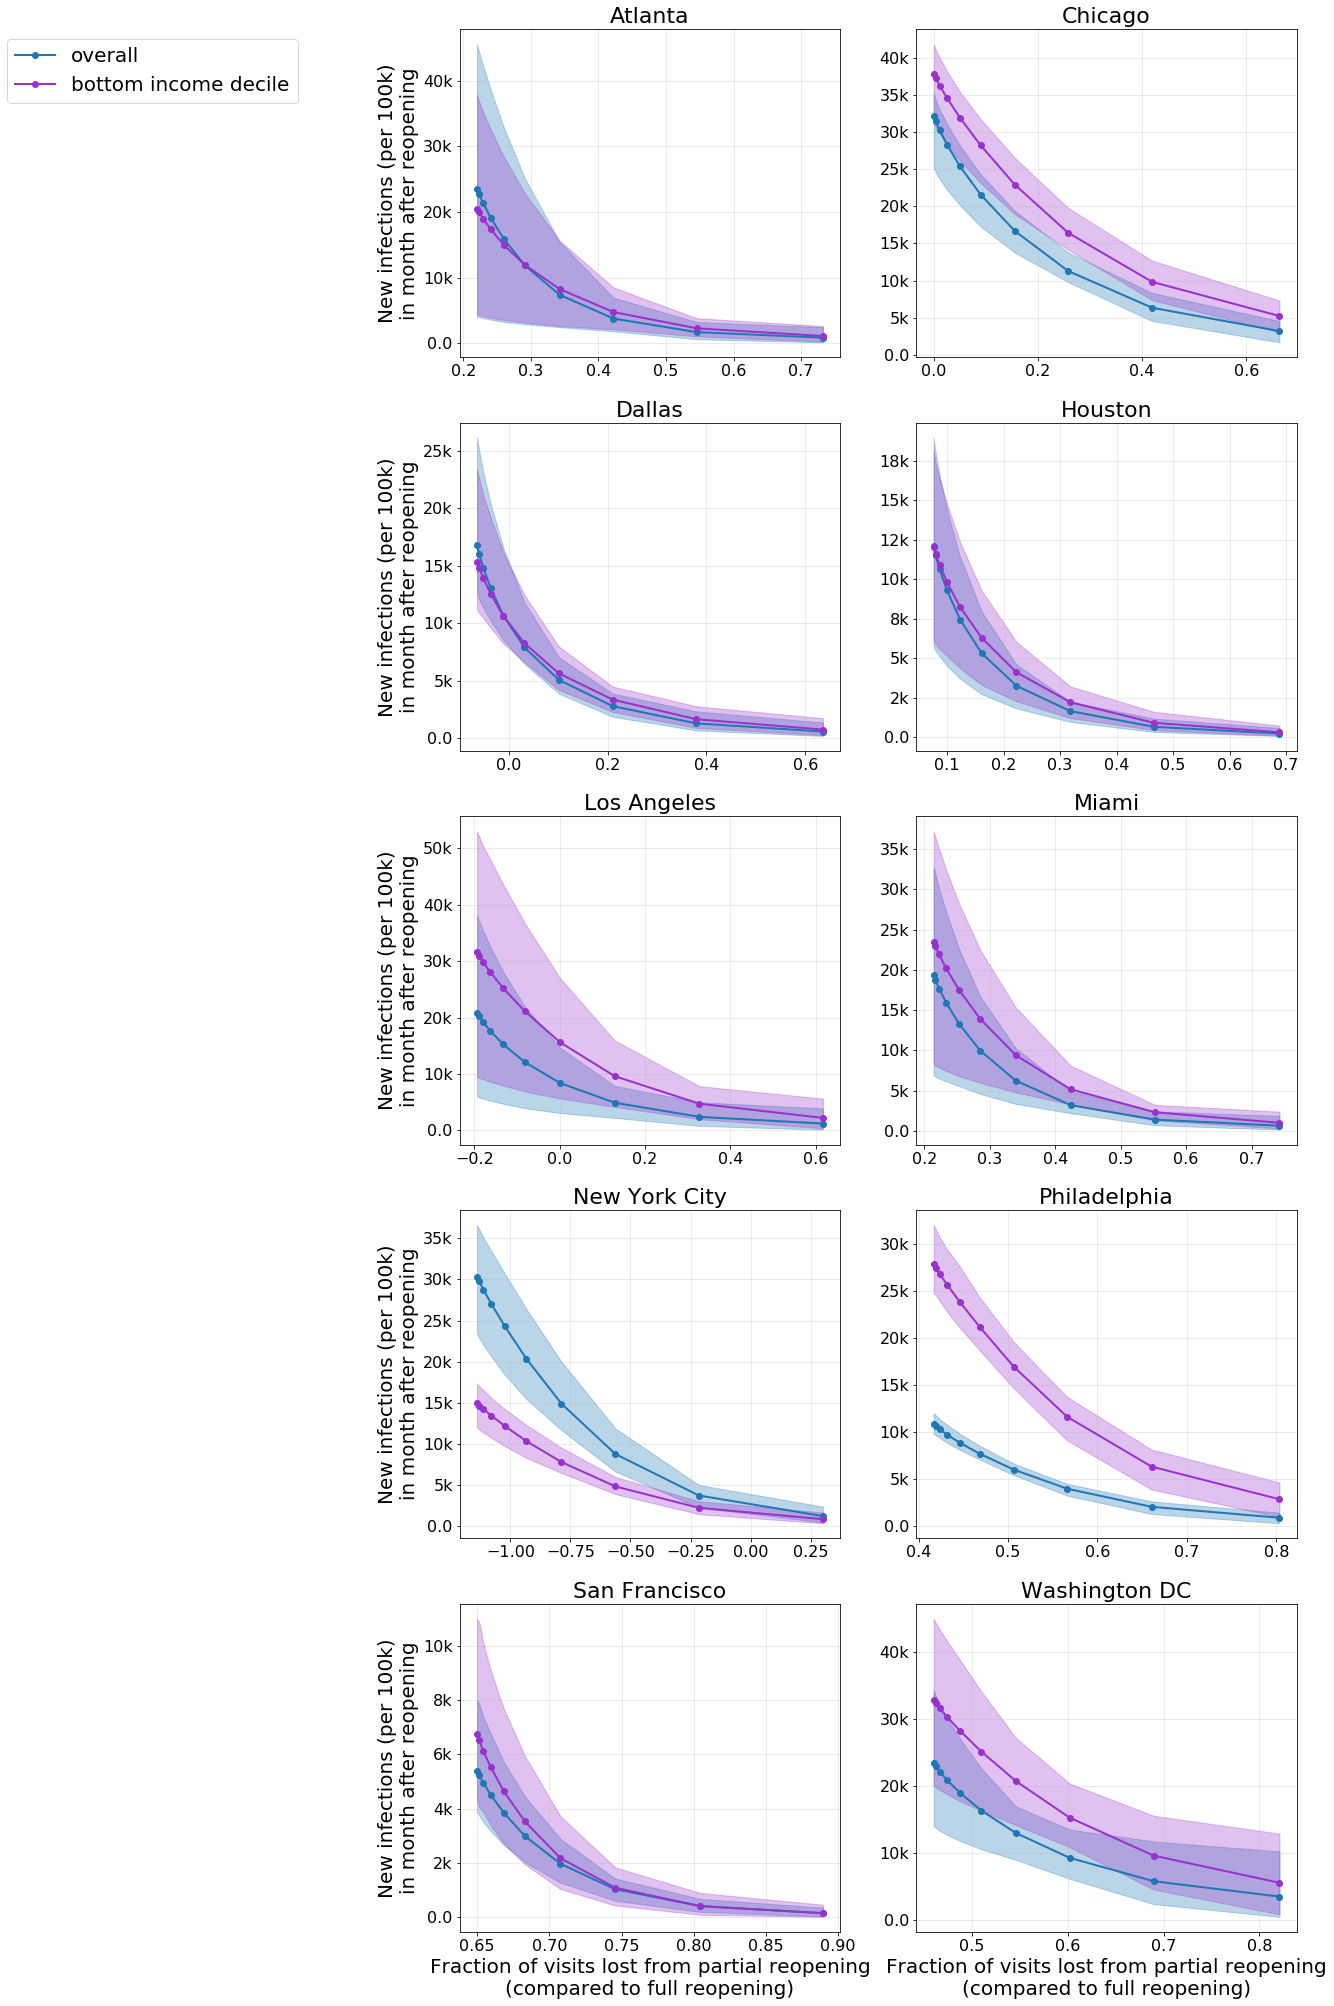

In [183]:
fig, axes = plt.subplots(5, 2, figsize=[15, 35])
axes = [ax for axes_row in axes for ax in axes_row]
for msa_idx, msa in enumerate(MSAS):
    print(msa)
    ax = axes[msa_idx]
    X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, msa, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=full_activity, cbg_group='all')
    make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                     color='tab:blue', set_axis_labels=False, line_label='overall')
    X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, msa, 'counterfactual_max_capacity_alpha', 
                                               intervention_idx, get_diff_in_infections=True, 
                                               full_activity_num_visits=full_activity, cbg_group=LOWINCOME)
    make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                     color='darkorchid', set_axis_labels=False, line_label='bottom income decile')

    if msa_idx % 2 == 0:
        ax.set_ylabel("New infections (per 100k)\nin month after reopening", fontsize=20)   
    if msa_idx >= 8:
        ax.set_xlabel("Fraction of visits lost from partial reopening\n(compared to full reopening)", fontsize=20)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=22)
    if msa_idx == 0:
        ax.legend(bbox_to_anchor=(-0.4, 1), fontsize=20)

In [55]:
# check if NYC is saturated for lower-income
for msa in MSAS:
    X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, msa, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=False, 
                                           full_activity_num_visits=full_activity, cbg_group=LOWINCOME)
    print(msa, np.percentile(all_intervention_lir, LOWER_PERCENTILE), np.mean(all_intervention_lir), np.percentile(all_intervention_lir, UPPER_PERCENTILE))

Num params * seeds: 480
Atlanta_Sandy_Springs_Roswell_GA 0.022739429807090428 0.0386483587184101 0.05555637861374302
Num params * seeds: 120
Chicago_Naperville_Elgin_IL_IN_WI 0.10966027529302393 0.13895207874368973 0.171728212333538
Num params * seeds: 150
Dallas_Fort_Worth_Arlington_TX 0.01582953435939876 0.024929895291445188 0.03452530421314121
Num params * seeds: 240
Houston_The_Woodlands_Sugar_Land_TX 0.013919622725974077 0.02339748693255884 0.034211977340265445
Num params * seeds: 750
Los_Angeles_Long_Beach_Anaheim_CA 0.02727811793545249 0.05298918708533928 0.07786965719844574
Num params * seeds: 210
Miami_Fort_Lauderdale_West_Palm_Beach_FL 0.04882510286275976 0.06364495664914076 0.08040779756260928
Num params * seeds: 210
New_York_Newark_Jersey_City_NY_NJ_PA 0.6170596157703334 0.650604532821649 0.6806896421320903
Num params * seeds: 90
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 0.2773618302166454 0.308359545999066 0.3495314308338917
Num params * seeds: 150
San_Francisco_Oakland_H

Atlanta_Sandy_Springs_Roswell_GA
Num params * seeds: 480
Num params * seeds: 480
Chicago_Naperville_Elgin_IL_IN_WI
Num params * seeds: 120
Num params * seeds: 120
Dallas_Fort_Worth_Arlington_TX
Num params * seeds: 150
Num params * seeds: 150
Houston_The_Woodlands_Sugar_Land_TX
Num params * seeds: 240
Num params * seeds: 240
Los_Angeles_Long_Beach_Anaheim_CA
Num params * seeds: 750
Num params * seeds: 750
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Num params * seeds: 210
Num params * seeds: 210
New_York_Newark_Jersey_City_NY_NJ_PA
Num params * seeds: 210
Num params * seeds: 210
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Num params * seeds: 90
Num params * seeds: 90
San_Francisco_Oakland_Hayward_CA
Num params * seeds: 150
Num params * seeds: 150
Washington_Arlington_Alexandria_DC_VA_MD_WV
Num params * seeds: 510
Num params * seeds: 510


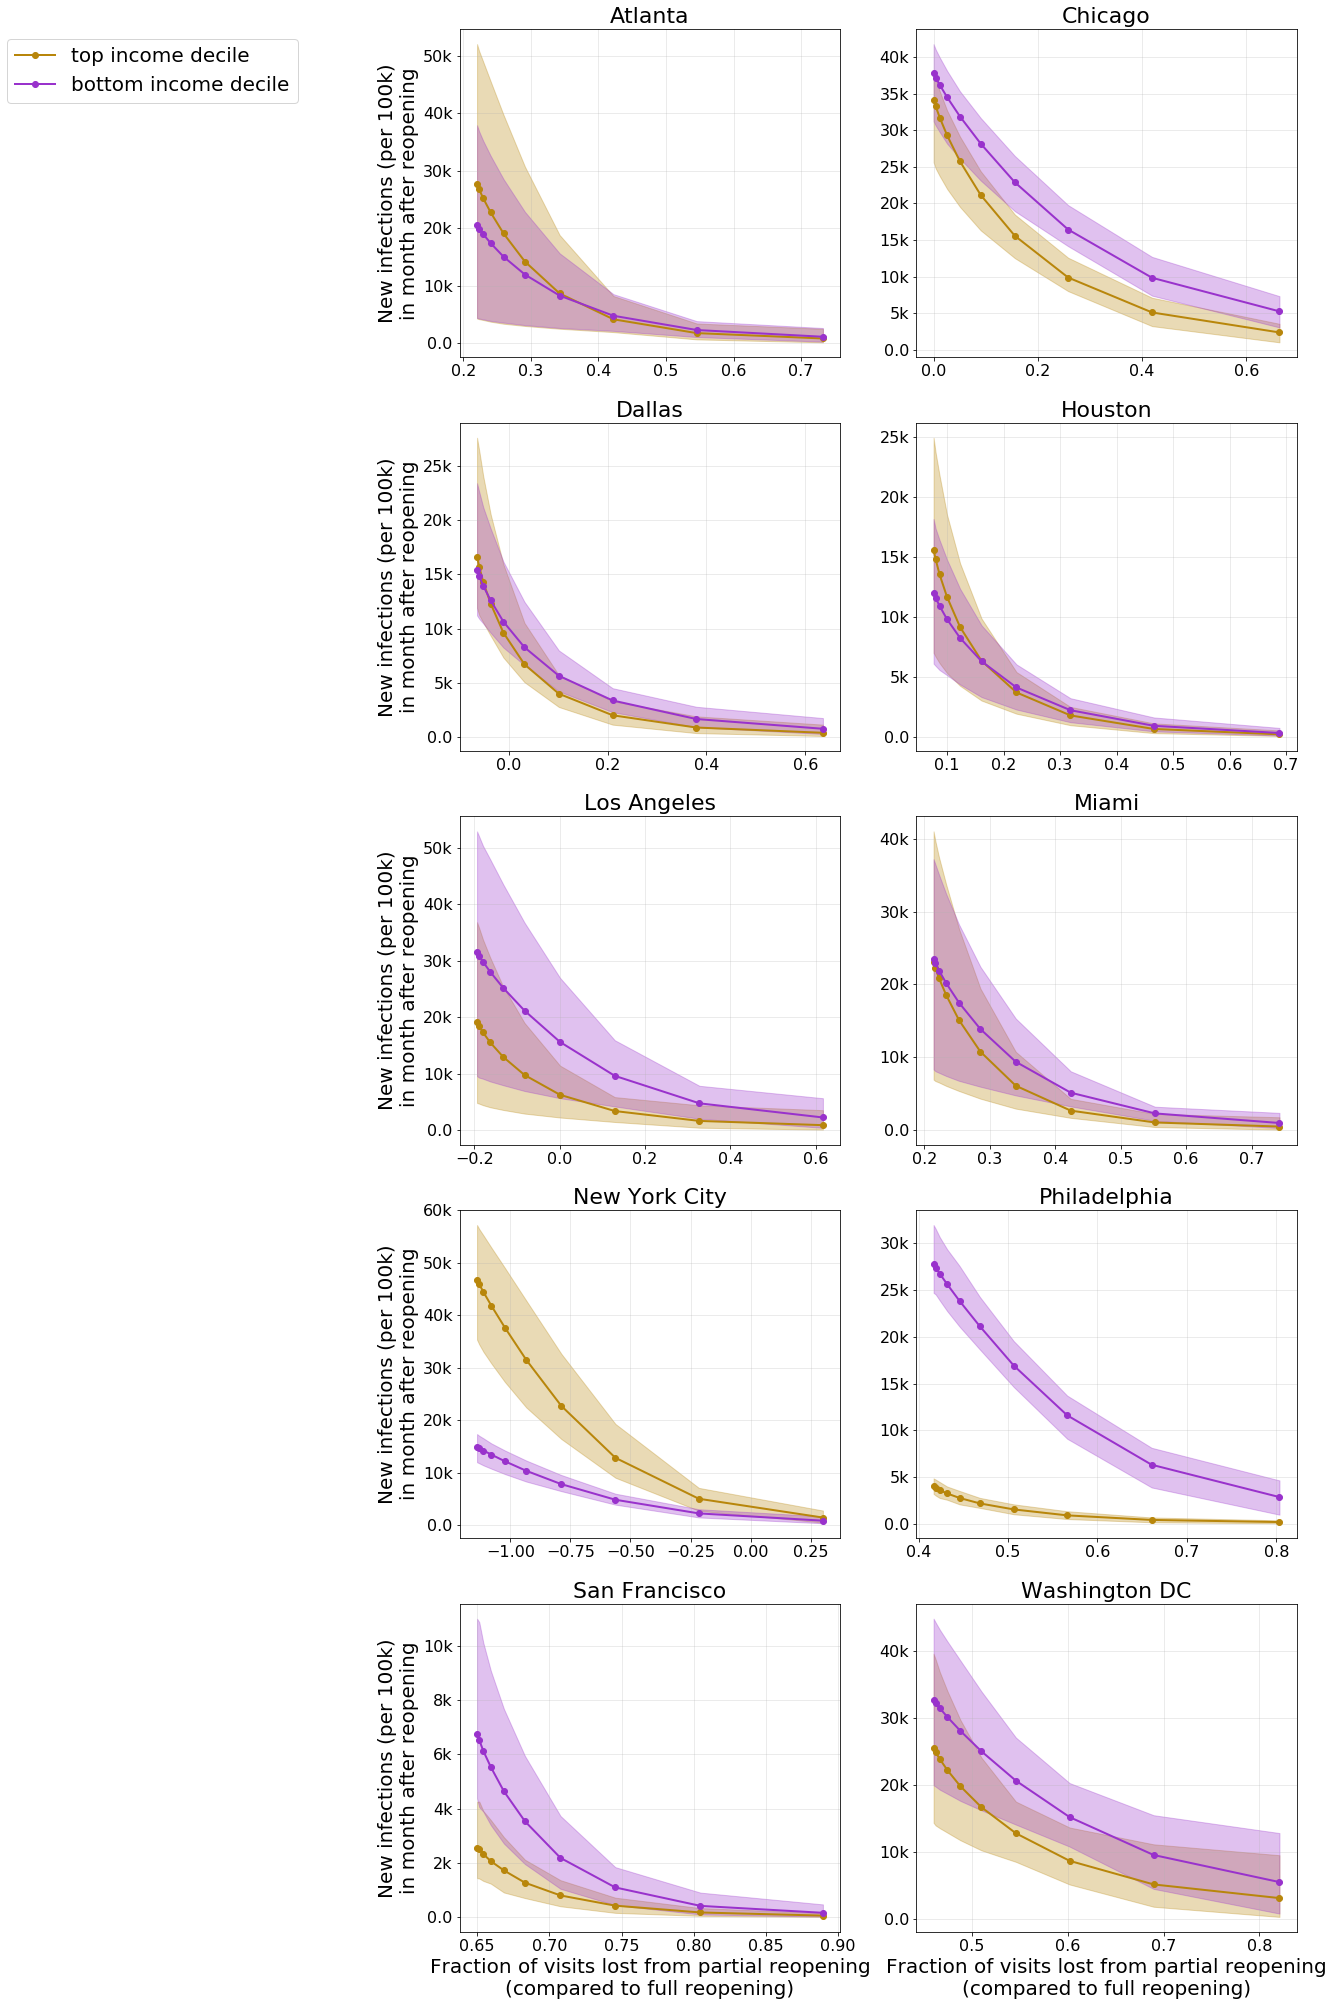

In [184]:
fig, axes = plt.subplots(5, 2, figsize=[15, 35])
axes = [ax for axes_row in axes for ax in axes_row]
for msa_idx, msa in enumerate(MSAS):
    print(msa)
    ax = axes[msa_idx]
    X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, msa, 'counterfactual_max_capacity_alpha', 
                                           intervention_idx, get_diff_in_infections=True, 
                                           full_activity_num_visits=full_activity, cbg_group=HIGHINCOME)
    make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                     color='darkgoldenrod', set_axis_labels=False, line_label='top income decile')
    X, Y_min, Y_mean, Y_max, all_intervention_lir, vals = get_pareto_curve(max_cap_cases, msa, 'counterfactual_max_capacity_alpha', 
                                               intervention_idx, get_diff_in_infections=True, 
                                               full_activity_num_visits=full_activity, cbg_group=LOWINCOME)
    make_pareto_plot(X, Y_min, Y_mean, Y_max, ax,
                     color='darkorchid', set_axis_labels=False, line_label='bottom income decile')

    if msa_idx % 2 == 0:
        ax.set_ylabel("New infections (per 100k)\nin month after reopening", fontsize=20)   
    if msa_idx >= 8:
        ax.set_xlabel("Fraction of visits lost from partial reopening\n(compared to full reopening)", fontsize=20)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa], fontsize=22)
    if msa_idx == 0:
        ax.legend(bbox_to_anchor=(-0.4, 1), fontsize=20)

## Figure 2d: Reopening different POI categories

In [19]:
min_timestring = '2020_07_22'
intervention_df = evaluate_all_fitted_models_for_experiment('test_interventions', 
                                                             min_timestring=min_timestring)
intervention_df['MSA_name'] = intervention_df['data_kwargs'].map(lambda x:x['MSA_name'])
for k in ['alpha', 
          'extra_weeks_to_simulate', 
          'intervention_datetime', 
          'top_category', 
          'sub_category']:
    intervention_df['counterfactual_%s' % k] = intervention_df['counterfactual_poi_opening_experiment_kwargs'].map(lambda x:x[k])
intervention_df['model_fit_rank_for_msa'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_fit_rank_for_msa'])
intervention_df['counterfactual_baseline_model'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['model_timestring'])
intervention_df['how_to_select_best_grid_search_models'] = intervention_df['model_kwargs'].map(lambda x:x['model_quality_dict']['how_to_select_best_grid_search_models'])
intervention_df_cases = intervention_df.loc[intervention_df['how_to_select_best_grid_search_models'] == 'daily_cases_rmse'].copy()
intervention_df_deaths = intervention_df.loc[intervention_df['how_to_select_best_grid_search_models'] == 'daily_deaths_rmse'].copy()
intervention_df_deaths = intervention_df_deaths[intervention_df_deaths['timestring'] >= '2020_07_22_20']  # necessary bc emma ran some experiments on the same day
intervention_df_poisson = intervention_df.loc[intervention_df['how_to_select_best_grid_search_models'] == 'daily_cases_poisson'].copy()

print('Found %d models for selecting with RMSE cases, %d for RMSE deaths, %d for Poisson cases' % 
       (len(intervention_df_cases), len(intervention_df_deaths), len(intervention_df_poisson)))
print(intervention_df_cases.groupby('MSA_name').size())

Loading models with timestrings between 2020_07_22 and 2020_07_29_13_09_38_459591
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 21732 fitted models for test_interventions
Loaded 1 models so far: 0.006s -> 0.006s per model
Loaded 1001 models so far: 4.166s -> 0.004s per model
Loaded 2001 models so far: 8.553s -> 0.004s per model
Loaded 3001 models so far: 12.717s -> 0.004s per model
Loaded 4001 models so far: 16.954s -> 0.004s per model
Loaded 5001 models so far: 21.067s -> 0.004s per model
Loaded 6001 models so far: 25.144s -> 0.004s per model
Loaded 7001 models so far: 29.079s -> 0.004s per model
Loaded 8001 models so far: 33.314s -> 0.004s per model
Loaded 9001 models so far: 37.320s -> 0.004s per model
Loaded 10001 models so far: 41.309s -> 0.004s per model
Loaded 11001 models so far: 45.467s -> 0.004s per model
Loaded 12001 models so far: 49.431s -> 0.004s per model
Loaded 13001 models so far: 53.389s -> 0.004s per model
Loaded

In [20]:
intervention_df_cases['rmse_ratio'] = intervention_df_cases['model_kwargs'].map(lambda x:x['model_quality_dict']['ratio_of_loss_dict_daily_cases_RMSE_to_that_of_best_fitting_model'])
intervention_df_cases_10 = intervention_df_cases[intervention_df_cases['rmse_ratio'] <= 1.10]
print('Found %d models for selecting with RMSE cases 10%% threshold' % len(intervention_df_cases_10))

Found 1800 models for selecting with RMSE cases 10% threshold


Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       5858.725913   
1               Fitness Centers       1465.203749   
2            Cafes & Snack Bars       1373.272590   
3               Hotels & Motels       1198.198447   
4   Limited-Service Restaurants        881.411553   
5       Religious Organizations        681.363400   
6         Offices of Physicians        314.651923   
7                Grocery Stores        210.296815   
8       Used Merchandise Stores        137.564168   
9                    Pet Stores        117.542529   
10        Sporting Goods Stores        109.727934   
11         Other General Stores        109.181776   
12           Hobby & Toy Stores         72.834996   
13              Hardware Stores         58.185856   
14      Automotive Part

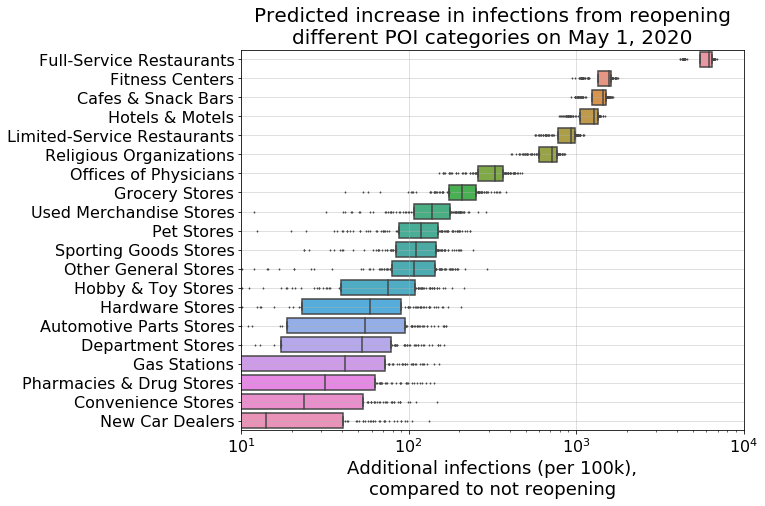

In [38]:
make_boxplot_of_poi_reopening_effects(
    intervention_df_cases, 
    [HIGHLIGHT_MSA], 
    poi_and_cbg_characteristics,
    titlestring='Predicted increase in infections from reopening\ndifferent POI categories on May 1, 2020', 
    cats_to_plot=top_categories, 
    filename=None,
    only_plot_reopening_impact=True)
plt.show()

## Supplement: Chicago reopening results for all selection metrics

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       5858.725913   
1               Fitness Centers       1465.203749   
2            Cafes & Snack Bars       1373.272590   
3               Hotels & Motels       1198.198447   
4   Limited-Service Restaurants        881.411553   
5       Religious Organizations        681.363400   
6         Offices of Physicians        314.651923   
7                Grocery Stores        210.296815   
8       Used Merchandise Stores        137.564168   
9                    Pet Stores        117.542529   
10        Sporting Goods Stores        109.727934   
11         Other Gener

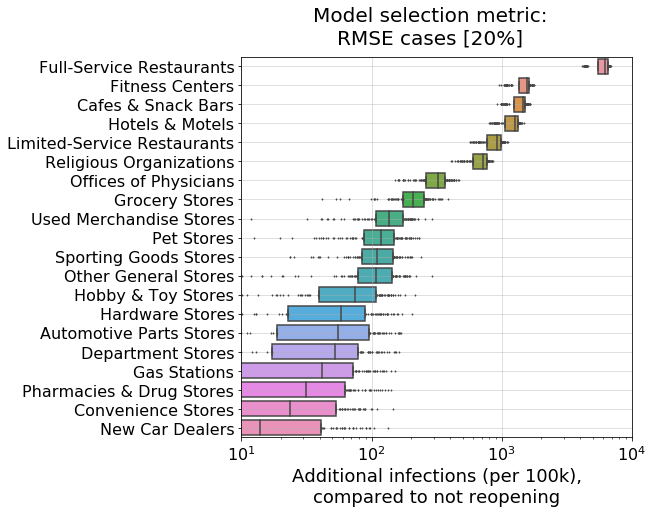

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       5625.344991   
1               Fitness Centers       1287.157549   
2            Cafes & Snack Bars       1281.794965   
3               Hotels & Motels       1110.546380   
4   Limited-Service Restaurants        809.730494   
5       Religious Organizations        637.593416   
6         Offices of Physicians        285.632717   
7                Grocery Stores        203.013272   
8       Used Merchandise Stores        122.659335   
9                    Pet Stores        100.969725   
10        Sporting Goods Stores         95.775837   
11         Other Gener

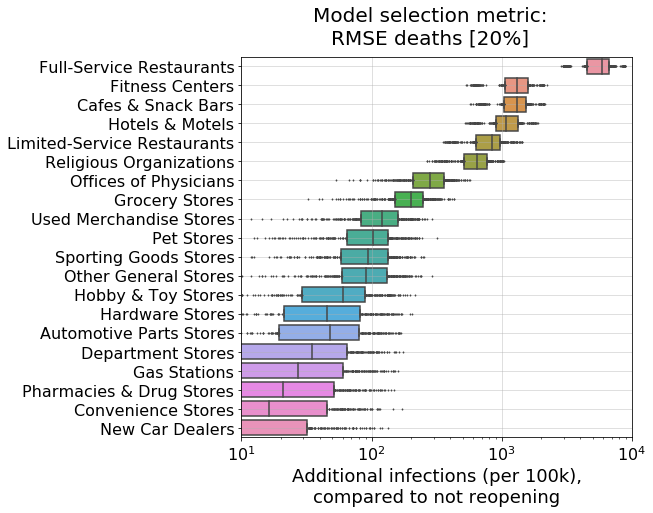

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       6996.736255   
1               Fitness Centers       1748.511904   
2            Cafes & Snack Bars       1615.692707   
3               Hotels & Motels       1450.864194   
4   Limited-Service Restaurants       1038.319218   
5       Religious Organizations        806.490835   
6         Offices of Physicians        378.936111   
7                Grocery Stores        240.066274   
8       Used Merchandise Stores        162.583793   
9                    Pet Stores        138.008222   
10         Other General Stores        127.917631   
11        Sporting Goo

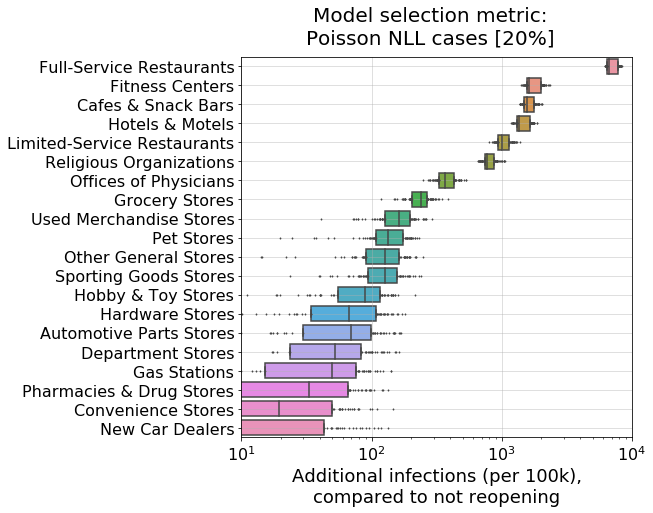

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
/dfs/scratch1/safegraph_homes/all_aggregate_data/ipf_output/Chicago_Naperville_Elgin_IL_IN_WI_2020-03-01_to_2020-05-02_clip_visits_True_correct_visits_True.pkl
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       6501.255367   
1               Fitness Centers       1579.515551   
2            Cafes & Snack Bars       1502.248365   
3               Hotels & Motels       1323.733226   
4   Limited-Service Restaurants        963.536138   
5       Religious Organizations        747.707607   
6         Offices of Physicians        351.214216   
7                Grocery Stores        237.814451   
8       Used Merchandise Stores        152.012299   
9                    Pet Stores        129.143842   
10         Other General Stores        123.996935   
11        Sporting Goo

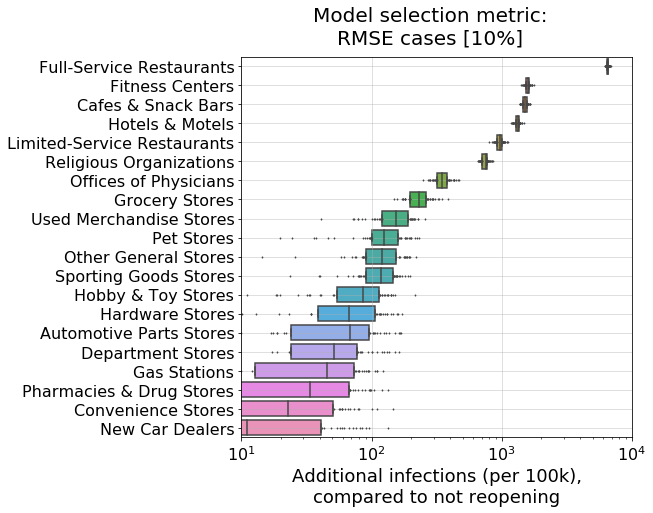

In [67]:
# only for Chicago
for df, metric in [(intervention_df_cases, 'RMSE cases [20%]'),
                  (intervention_df_deaths, 'RMSE deaths [20%]'),
                  (intervention_df_poisson, 'Poisson NLL cases [20%]'),
                  (intervention_df_cases_10, 'RMSE cases [10%]')]:
    make_boxplot_of_poi_reopening_effects(
        df, 
        [HIGHLIGHT_MSA], 
        poi_and_cbg_characteristics,
        titlestring='Model selection metric:\n%s' % metric, 
        cats_to_plot=top_categories, 
        filename=None,
        only_plot_reopening_impact=True)
    plt.show()

## Supplement: POI attributes and reopening results for all MSAs

Making plots using ['Atlanta_Sandy_Springs_Roswell_GA']
Atlanta_Sandy_Springs_Roswell_GA
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       2344.272544   
1               Fitness Centers       1276.461138   
2               Hotels & Motels       1073.336628   
3       Religious Organizations        754.704382   
4            Cafes & Snack Bars        610.810674   
5   Limited-Service Restaurants        293.803992   
6         Offices of Physicians        176.525472   
7            Hobby & Toy Stores         99.249444   
8       Used Merchandise Stores         62.052080   
9         Sporting Goods Stores         48.241020   
10         Other General Stores         44.685005   
11                   Pet Stores         36.344875   
12            Department Stores         24.495842   
13               Grocery Stores         22.713406   
14     Pharmacies & Drug 

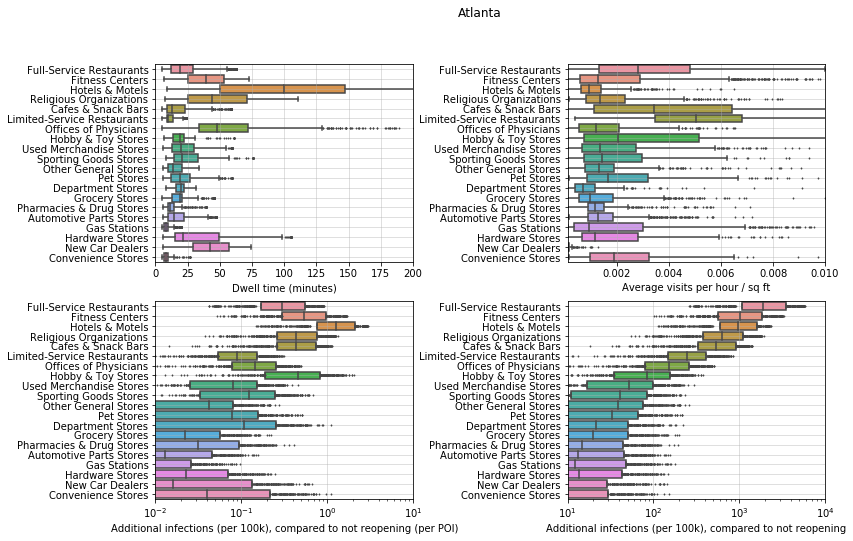

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       5858.725913   
1               Fitness Centers       1465.203749   
2            Cafes & Snack Bars       1373.272590   
3               Hotels & Motels       1198.198447   
4   Limited-Service Restaurants        881.411553   
5       Religious Organizations        681.363400   
6         Offices of Physicians        314.651923   
7                Grocery Stores        210.296815   
8       Used Merchandise Stores        137.564168   
9                    Pet Stores        117.542529   
10        Sporting Goods Stores        109.727934   
11         Other General Stores        109.181776   
12           Hobby & Toy Stores         72.834996   
13              Hardware Stores         58.185856   
14      Automotive Part

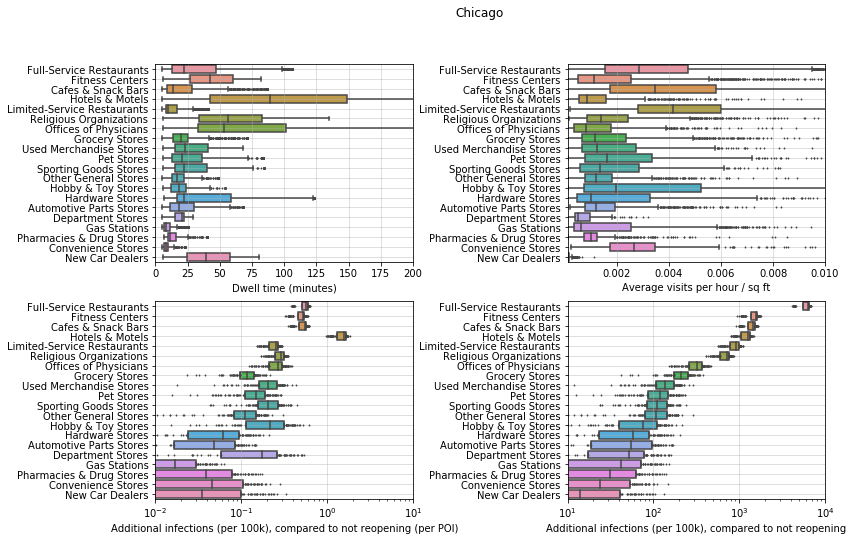

Making plots using ['Dallas_Fort_Worth_Arlington_TX']
Dallas_Fort_Worth_Arlington_TX
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       1605.273400   
1               Hotels & Motels        637.228467   
2       Religious Organizations        624.704395   
3               Fitness Centers        462.609410   
4   Limited-Service Restaurants        407.965765   
5            Cafes & Snack Bars        221.094618   
6         Offices of Physicians         98.723185   
7       Used Merchandise Stores         42.016868   
8         Sporting Goods Stores         39.080018   
9          Other General Stores         32.511183   
10                   Pet Stores         26.318176   
11           Hobby & Toy Stores         22.982477   
12            Department Stores         15.995120   
13                 Gas Stations         10.545645   
14              Hardware Stor

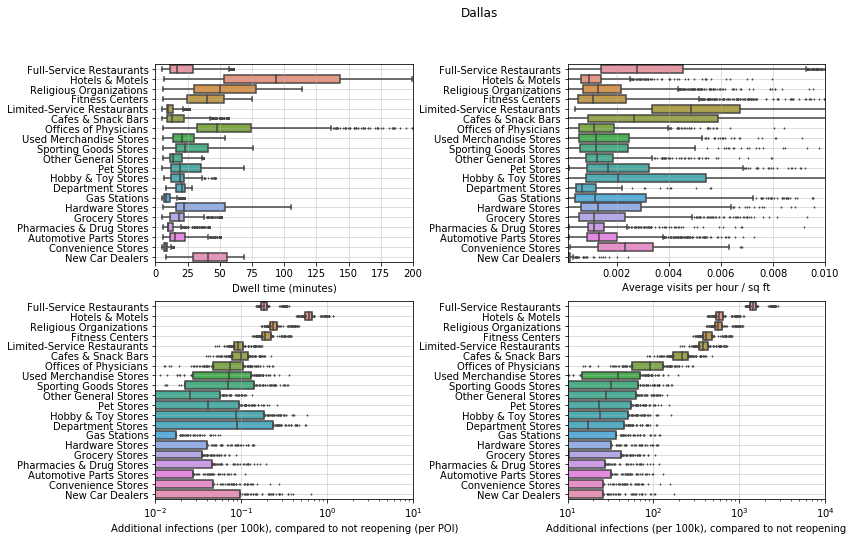

Making plots using ['Houston_The_Woodlands_Sugar_Land_TX']
Houston_The_Woodlands_Sugar_Land_TX
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       1278.850355   
1               Hotels & Motels        664.587221   
2               Fitness Centers        262.843225   
3       Religious Organizations        241.721840   
4            Cafes & Snack Bars        198.880876   
5         Offices of Physicians        128.758465   
6   Limited-Service Restaurants        122.320407   
7               Hardware Stores         40.873679   
8       Used Merchandise Stores         34.405662   
9                    Pet Stores         34.303704   
10               Grocery Stores         32.202204   
11        Sporting Goods Stores         23.439431   
12           Hobby & Toy Stores         22.449091   
13         Other General Stores         21.198141   
14      Automotive 

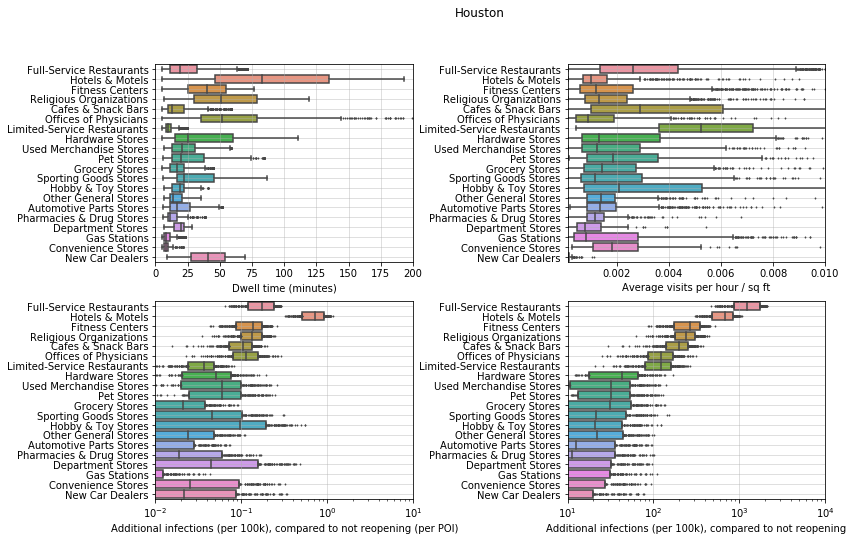

Making plots using ['Los_Angeles_Long_Beach_Anaheim_CA']
Los_Angeles_Long_Beach_Anaheim_CA
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       2752.530489   
1               Fitness Centers        778.802141   
2            Cafes & Snack Bars        626.298540   
3               Hotels & Motels        593.268193   
4       Religious Organizations        466.100939   
5   Limited-Service Restaurants        319.281460   
6          Other General Stores        203.723465   
7                Grocery Stores        147.503856   
8         Offices of Physicians        123.183163   
9               Hardware Stores        102.931019   
10      Used Merchandise Stores         71.647904   
11                   Pet Stores         60.562280   
12        Sporting Goods Stores         54.874341   
13      Automotive Parts Stores         50.787079   
14           Hobby & To

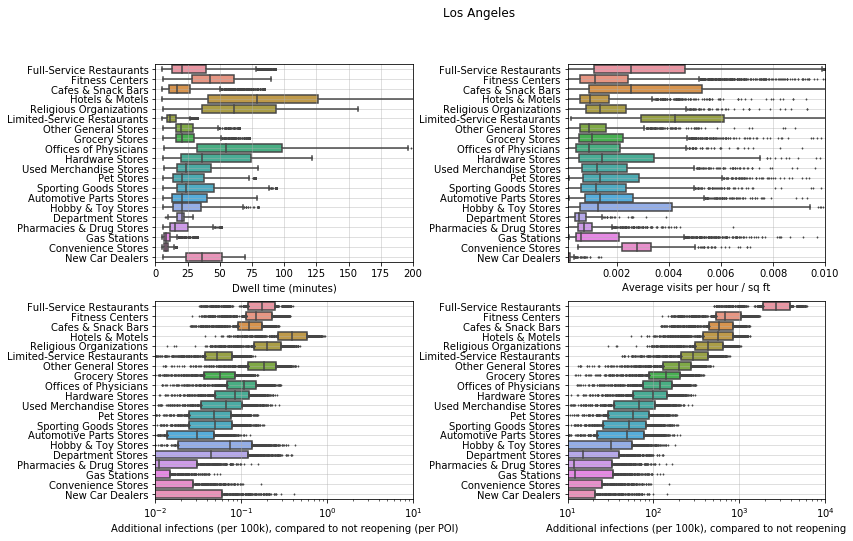

Making plots using ['Miami_Fort_Lauderdale_West_Palm_Beach_FL']
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       1847.074675   
1               Hotels & Motels       1386.643973   
2               Fitness Centers        694.078316   
3            Cafes & Snack Bars        498.709477   
4       Religious Organizations        195.405982   
5   Limited-Service Restaurants        172.364248   
6         Offices of Physicians        116.364316   
7         Sporting Goods Stores         87.088667   
8               Hardware Stores         61.616407   
9                Grocery Stores         59.279334   
10         Other General Stores         45.218077   
11      Used Merchandise Stores         42.412139   
12                   Pet Stores         26.650274   
13      Automotive Parts Stores         25.180614   
14       

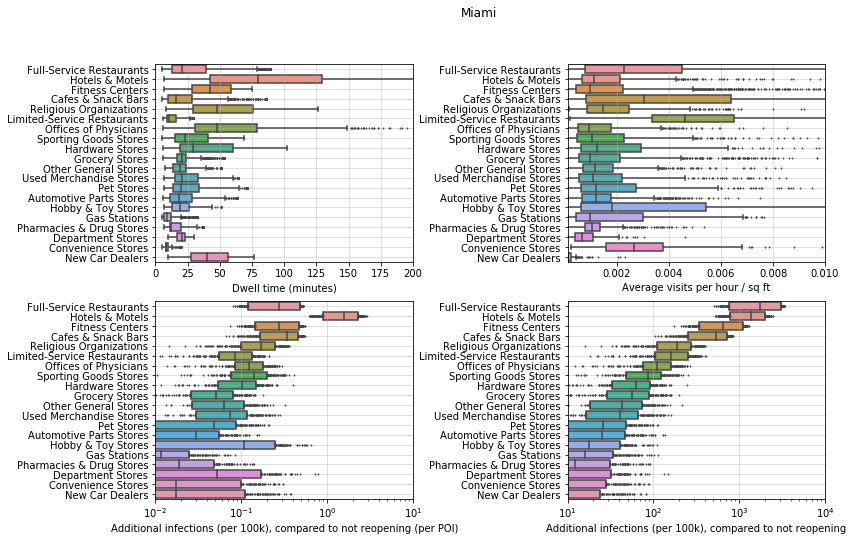

Making plots using ['New_York_Newark_Jersey_City_NY_NJ_PA']
New_York_Newark_Jersey_City_NY_NJ_PA
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       6257.030173   
1               Fitness Centers       1961.650932   
2            Cafes & Snack Bars       1467.018490   
3               Hotels & Motels        738.110088   
4       Religious Organizations        703.973130   
5   Limited-Service Restaurants        545.801297   
6         Offices of Physicians        476.329684   
7                Grocery Stores        222.093976   
8       Used Merchandise Stores        121.246598   
9         Sporting Goods Stores        104.477474   
10              Hardware Stores         96.636536   
11         Other General Stores         96.441346   
12                   Pet Stores         93.854669   
13                 Gas Stations         59.642340   
14           Hobb

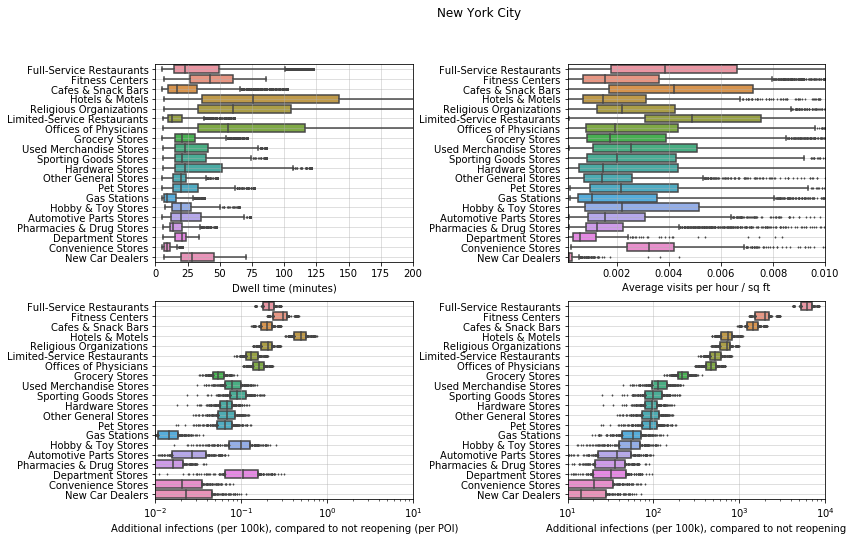

Making plots using ['Philadelphia_Camden_Wilmington_PA_NJ_DE_MD']
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       2562.917956   
1            Cafes & Snack Bars        450.008139   
2                Grocery Stores        311.822381   
3               Hotels & Motels        227.802783   
4       Religious Organizations        214.417782   
5               Fitness Centers        197.275518   
6   Limited-Service Restaurants        182.821170   
7         Offices of Physicians        128.077348   
8                    Pet Stores         44.082902   
9      Pharmacies & Drug Stores         31.708232   
10      Used Merchandise Stores         31.230683   
11              Hardware Stores         30.698229   
12         Other General Stores         23.692157   
13      Automotive Parts Stores         20.171779   
14   

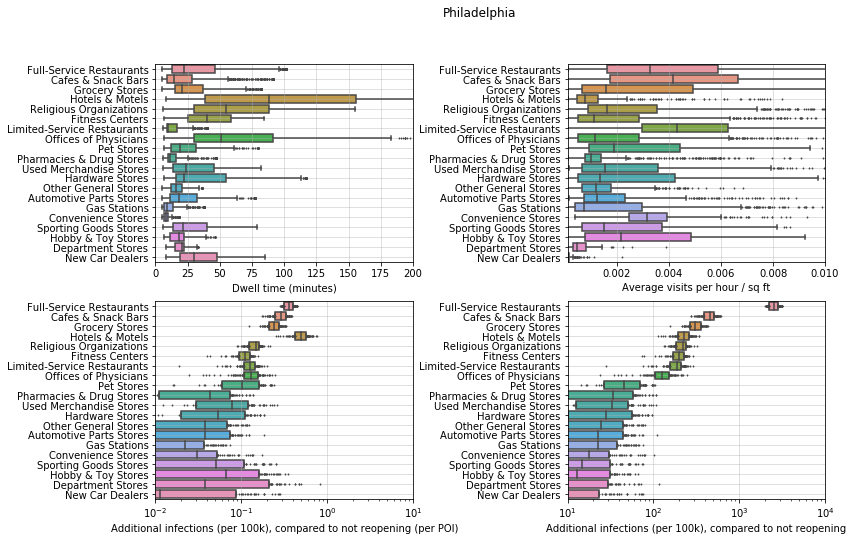

Making plots using ['San_Francisco_Oakland_Hayward_CA']
San_Francisco_Oakland_Hayward_CA
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants        972.516512   
1               Hotels & Motels        254.528008   
2            Cafes & Snack Bars        110.853154   
3               Fitness Centers        110.682523   
4               Hardware Stores         58.437593   
5       Religious Organizations         35.550625   
6         Offices of Physicians         32.102327   
7   Limited-Service Restaurants         24.867713   
8                Grocery Stores         15.777570   
9         Sporting Goods Stores          6.419090   
10         Other General Stores          4.809711   
11                   Pet Stores          3.383939   
12                 Gas Stations          2.472394   
13      Used Merchandise Stores          2.286322   
14           Hobby & Toy 

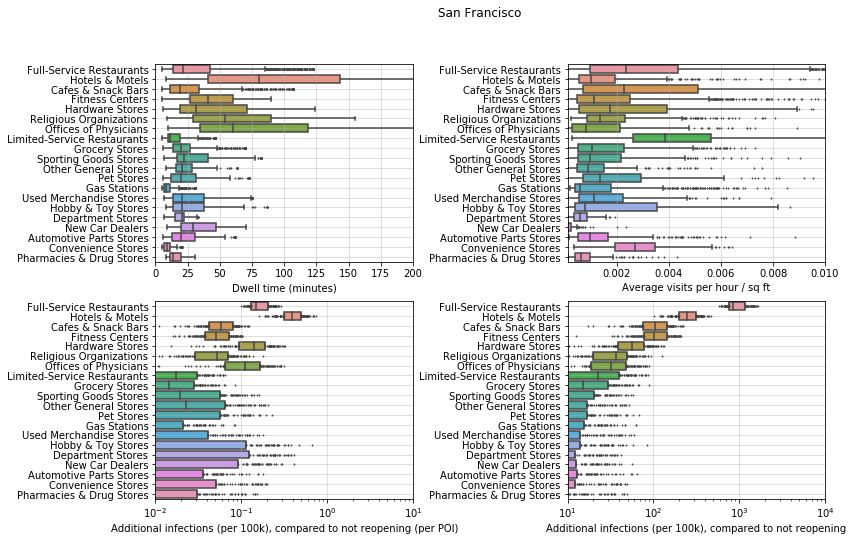

Making plots using ['Washington_Arlington_Alexandria_DC_VA_MD_WV']
Washington_Arlington_Alexandria_DC_VA_MD_WV
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       2513.971458   
1            Cafes & Snack Bars       1290.948874   
2               Hotels & Motels       1266.208408   
3               Fitness Centers       1055.757990   
4   Limited-Service Restaurants        729.932400   
5       Religious Organizations        409.783635   
6         Offices of Physicians        205.798964   
7               Hardware Stores        136.329080   
8                Grocery Stores        130.221632   
9       Used Merchandise Stores        102.315144   
10         Other General Stores         58.686690   
11                   Pet Stores         57.472997   
12           Convenience Stores         32.135754   
13      Automotive Parts Stores         29.560480   
14 

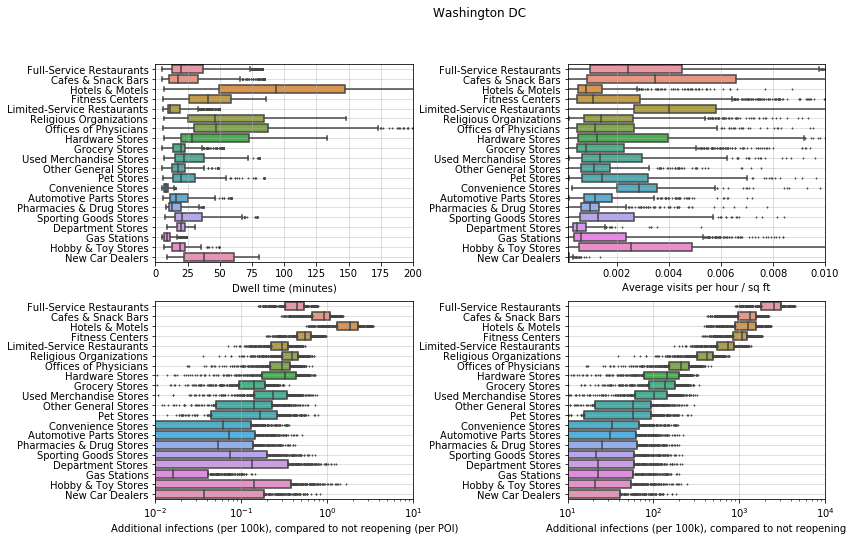

In [77]:
for msa in MSAS:
    make_boxplot_of_poi_reopening_effects(intervention_df_cases, 
                                          [msa], 
                                          poi_and_cbg_characteristics, 
                                          titlestring=MSAS_TO_PRETTY_NAMES[msa], 
                                          cats_to_plot=top_categories, 
                                          filename='covid_figures_for_paper/reopening_impact_boxplots_%s.pdf' % msa)
    plt.show()

Making plots using ['Chicago_Naperville_Elgin_IL_IN_WI']
Chicago_Naperville_Elgin_IL_IN_WI
Reopening impact quantifies cases per 100000
Stats on mean additional cases from reopening
               pretty_cat_names  reopening_impact  \
0      Full-Service Restaurants       5858.725913   
1               Fitness Centers       1465.203749   
2            Cafes & Snack Bars       1373.272590   
3               Hotels & Motels       1198.198447   
4   Limited-Service Restaurants        881.411553   
5       Religious Organizations        681.363400   
6         Offices of Physicians        314.651923   
7                Grocery Stores        210.296815   
8       Used Merchandise Stores        137.564168   
9                    Pet Stores        117.542529   
10        Sporting Goods Stores        109.727934   
11         Other General Stores        109.181776   
12           Hobby & Toy Stores         72.834996   
13              Hardware Stores         58.185856   
14      Automotive Part

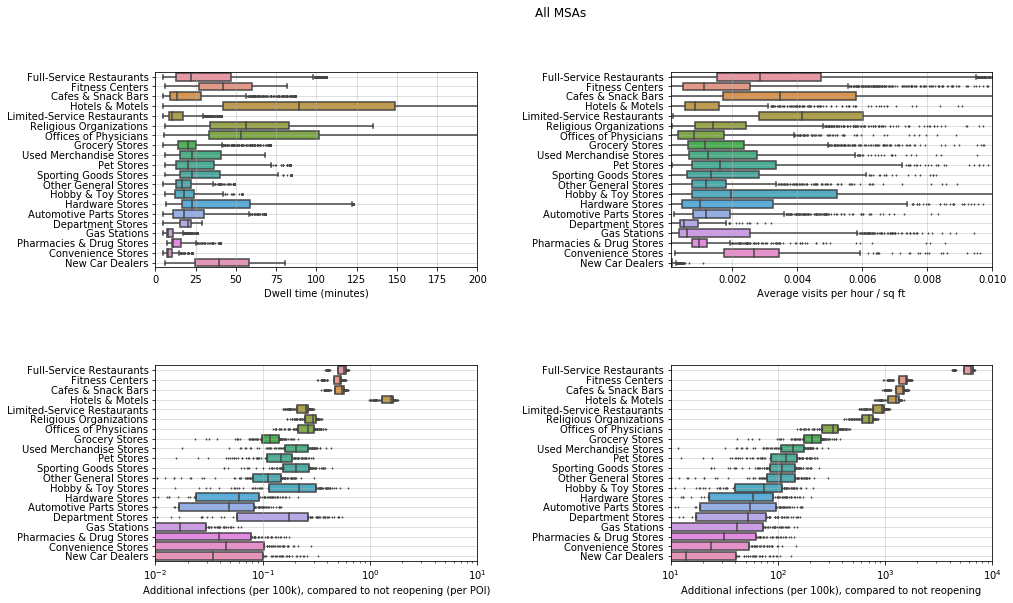

In [29]:
make_boxplot_of_poi_reopening_effects(intervention_df_cases, 
                                      [HIGHLIGHT_MSA],
                                      poi_and_cbg_characteristics, 
                                      titlestring='All MSAs', 
                                      cats_to_plot=top_categories, 
                                      filename='covid_figures_for_paper/reopening_impact_boxplots_all_MSAs.pdf')
plt.show()

Making plots using ['Atlanta_Sandy_Springs_Roswell_GA', 'Chicago_Naperville_Elgin_IL_IN_WI', 'Dallas_Fort_Worth_Arlington_TX', 'Houston_The_Woodlands_Sugar_Land_TX', 'Los_Angeles_Long_Beach_Anaheim_CA', 'Miami_Fort_Lauderdale_West_Palm_Beach_FL', 'New_York_Newark_Jersey_City_NY_NJ_PA', 'Philadelphia_Camden_Wilmington_PA_NJ_DE_MD', 'San_Francisco_Oakland_Hayward_CA', 'Washington_Arlington_Alexandria_DC_VA_MD_WV']
Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV
Reopening impact quantifies cases per 100000
Pearson correlations between attributes
reopening_impact_per_poi           1.000000
original_dwell_times               0.734545
weighted_visits_over_area          0.085111
d

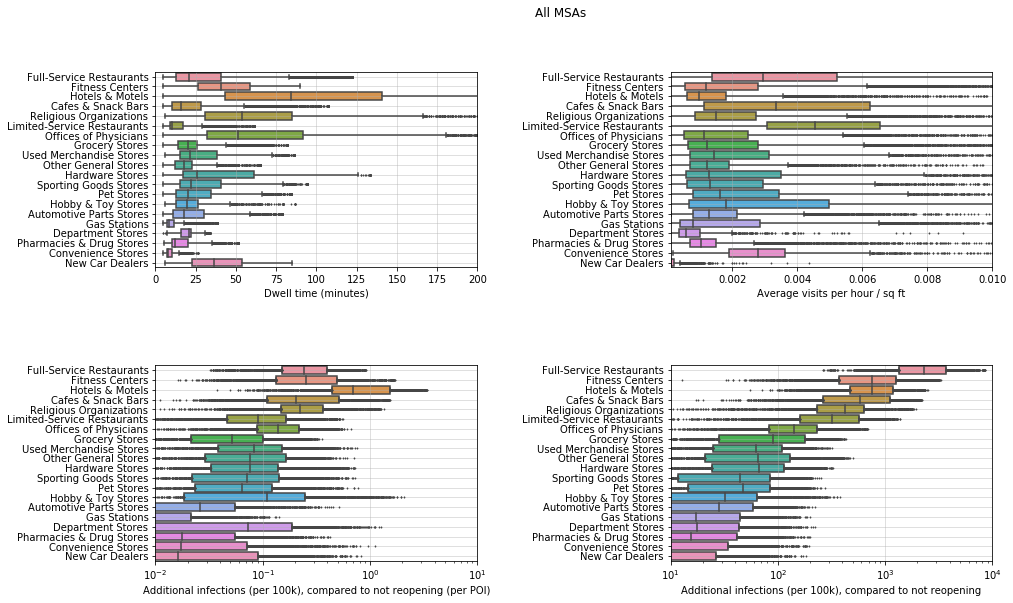

In [30]:
make_boxplot_of_poi_reopening_effects(intervention_df_cases, 
                                      MSAS,
                                      poi_and_cbg_characteristics, 
                                      titlestring='All MSAs', 
                                      cats_to_plot=top_categories, 
                                      filename='covid_figures_for_paper/reopening_impact_boxplots_all_MSAs.pdf')
plt.show()

## Supplement: disparate impacts of reopening POI categories

In [185]:
plot_reopening_effect_by_poi_category_with_disparate_impact(intervention_df_cases, 
                                      medians_or_deciles='deciles', 
                                      cats_to_plot=top_categories,
                                      filename='covid_figures_for_paper/reopening_by_poi_decile_income.pdf')
plt.show()

Analyzing results for rich and poor deciles
97 models to load for closed df; 1940 models to load for opened interventions
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270


KeyboardInterrupt: 

# Equity analysis

## Figure 3a/b: disparate impact plots 

Using parameters MAX_MODELS_TO_TAKE_PER_MSA=100, loss_tolerance=1.200, and key_to_sort_by=loss_dict_daily_cases_RMSE
Plotting 16 models for Atlanta_Sandy_Springs_Roswell_GA
Plotting 4 models for Chicago_Naperville_Elgin_IL_IN_WI
Plotting 5 models for Dallas_Fort_Worth_Arlington_TX
Plotting 8 models for Houston_The_Woodlands_Sugar_Land_TX
Plotting 25 models for Los_Angeles_Long_Beach_Anaheim_CA
Plotting 7 models for Miami_Fort_Lauderdale_West_Palm_Beach_FL
Plotting 7 models for New_York_Newark_Jersey_City_NY_NJ_PA
Plotting 3 models for Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Plotting 5 models for San_Francisco_Oakland_Hayward_CA
Plotting 17 models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Median of medians for p_white deciles 3.0411060218470354
Median of medians for median_household_income deciles 2.54431935015807


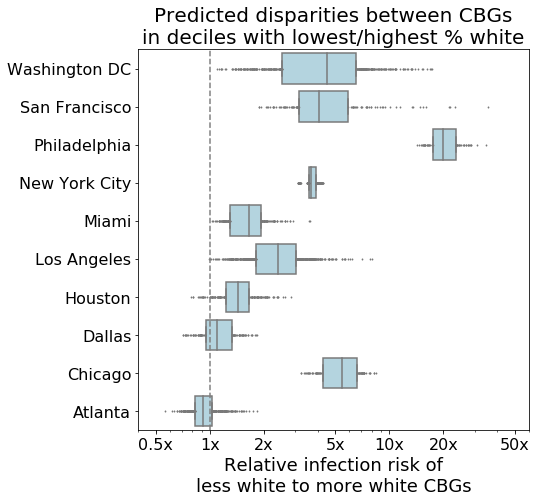

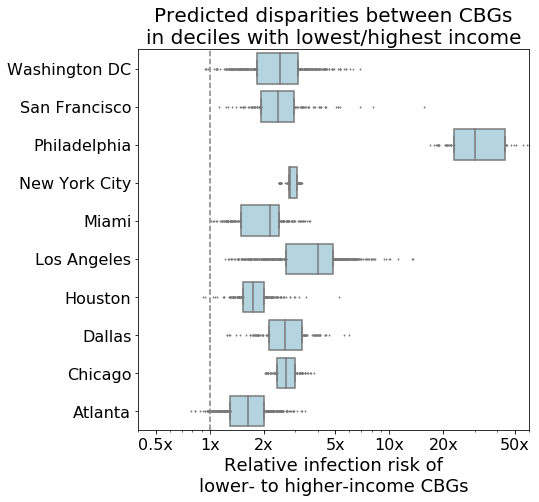

In [46]:
table_results, all_ratios = make_all_disparities_infection_ratio_plots(non_ablation_df, return_all_ratios=True)

In [44]:
# pull numbers for reviewer 
print("Ratios in philadelphia")
for demo in ['median_household_income', 'p_white']:
    for comparison in ['deciles']:
        ratios_of_interest= all_ratios.loc[(all_ratios['MSA'] == "Philadelphia") & 
                                           (all_ratios['comparison'] == comparison) & 
                                           (all_ratios['demo'] == demo)]
        print(demo, comparison)
        print(ratios_of_interest['ratio'].describe([0.025, 0.25, 0.50, 0.75, 0.975]))

Ratios in philadelphia
median_household_income deciles
count    90.000000
mean     37.939205
std      21.121552
min      16.809660
2.5%     18.200112
25%      23.024860
50%      29.967498
75%      44.261275
97.5%    93.111137
max      96.193934
Name: ratio, dtype: float64
p_white deciles
count    90.000000
mean     20.673173
std       4.190607
min      14.223834
2.5%     15.104163
25%      17.517653
50%      20.031099
75%      23.556322
97.5%    28.466960
max      34.626459
Name: ratio, dtype: float64


In [118]:
table_results.loc[(table_results['demo'] == 'median_household_income')].sort_values(by=['MSA_name', 'comparison'])

MSA_name comparison  \
3              Atlanta_Sandy_Springs_Roswell_GA    deciles   
2              Atlanta_Sandy_Springs_Roswell_GA    medians   
9             Chicago_Naperville_Elgin_IL_IN_WI    deciles   
8             Chicago_Naperville_Elgin_IL_IN_WI    medians   
15               Dallas_Fort_Worth_Arlington_TX    deciles   
14               Dallas_Fort_Worth_Arlington_TX    medians   
21          Houston_The_Woodlands_Sugar_Land_TX    deciles   
20          Houston_The_Woodlands_Sugar_Land_TX    medians   
27            Los_Angeles_Long_Beach_Anaheim_CA    deciles   
26            Los_Angeles_Long_Beach_Anaheim_CA    medians   
33     Miami_Fort_Lauderdale_West_Palm_Beach_FL    deciles   
32     Miami_Fort_Lauderdale_West_Palm_Beach_FL    medians   
39         New_York_Newark_Jersey_City_NY_NJ_PA    deciles   
38         New_York_Newark_Jersey_City_NY_NJ_PA    medians   
45   Philadelphia_Camden_Wilmington_PA_NJ_DE_MD    deciles   
44   Philadelphia_Camden_Wilmington_PA_NJ_DE_MD    medians   
51             San_Francisco_Oakland_Hayward_CA    deciles   
50             San_Francisco_Oakland_Hayward_CA    medians   
57  Washington_Arlington_Alexandria_DC_VA_MD_WV    deciles   
56  Washington_Arlington_Alexandria_DC_VA_MD_WV    medians   

                       demo  disadvantaged_group_is_more_sick  median_ratio  \
3   median_household_income                          0.968750      1.625140   
2   median_household_income                          0.947917      1.232754   
9   median_household_income                          1.000000      2.667129   
8   median_household_income                          1.000000      2.017313   
15  median_household_income                          1.000000      2.639519   
14  median_household_income                          1.000000      1.417964   
21  median_household_income                          0.991667      1.735490   
20  median_household_income                          1.000000      1.599249   
27  median_household_income                          1.000000      4.034546   
26  median_household_income                          1.000000      2.353727   
33  median_household_income                          1.000000      2.161475   
32  median_household_income                          1.000000      1.476416   
39  median_household_income                          1.000000      2.815037   
38  median_household_income                          1.000000      2.052064   
45  median_household_income                          1.000000     29.967498   
44  median_household_income                          1.000000      9.557234   
51  median_household_income                          1.000000      2.406054   
50  median_household_income                          1.000000      2.400435   
57  median_household_income                          0.992157      2.449120   
56  median_household_income                          0.998039      1.642814   

     n  
3   16  
2   16  
9    4  
8    4  
15   5  
14   5  
21   8  
20   8  
27  25  
26  25  
33   7  
32   7  
39   7  
38   7  
45   3  
44   3  
51   5  
50   5  
57  17  
56  17

## Supplement: disparity results for all model selection metrics

Using parameters MAX_MODELS_TO_TAKE_PER_MSA=100, loss_tolerance=1.100, and key_to_sort_by=loss_dict_daily_cases_RMSE
Plotting 8 models for Atlanta_Sandy_Springs_Roswell_GA
Plotting 2 models for Chicago_Naperville_Elgin_IL_IN_WI
Plotting 2 models for Dallas_Fort_Worth_Arlington_TX
Plotting 6 models for Houston_The_Woodlands_Sugar_Land_TX
Plotting 10 models for Los_Angeles_Long_Beach_Anaheim_CA
Plotting 3 models for Miami_Fort_Lauderdale_West_Palm_Beach_FL
Plotting 4 models for New_York_Newark_Jersey_City_NY_NJ_PA
Plotting 2 models for Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Plotting 4 models for San_Francisco_Oakland_Hayward_CA
Plotting 4 models for Washington_Arlington_Alexandria_DC_VA_MD_WV
Using parameters MAX_MODELS_TO_TAKE_PER_MSA=100, loss_tolerance=1.200, and key_to_sort_by=loss_dict_daily_deaths_RMSE
Plotting 27 models for Atlanta_Sandy_Springs_Roswell_GA
Plotting 12 models for Chicago_Naperville_Elgin_IL_IN_WI
Plotting 23 models for Dallas_Fort_Worth_Arlington_TX
Plotting 16

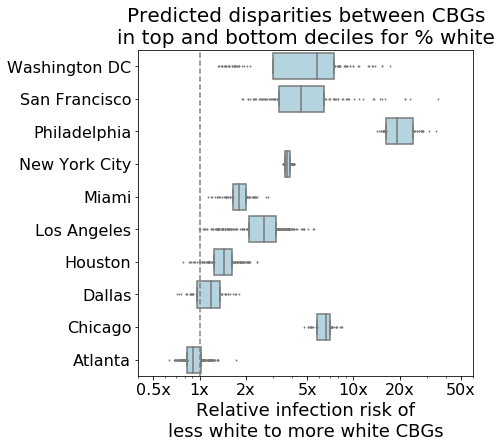

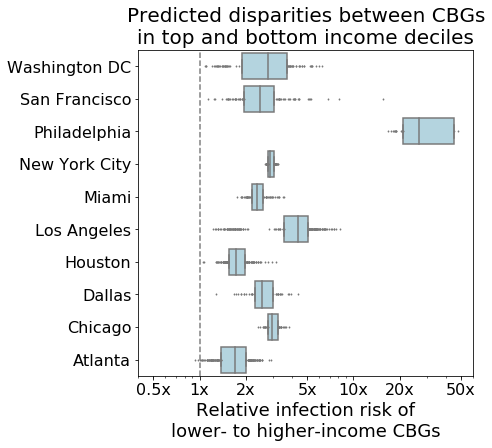

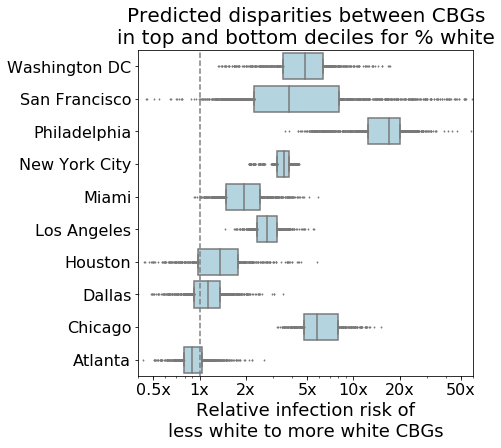

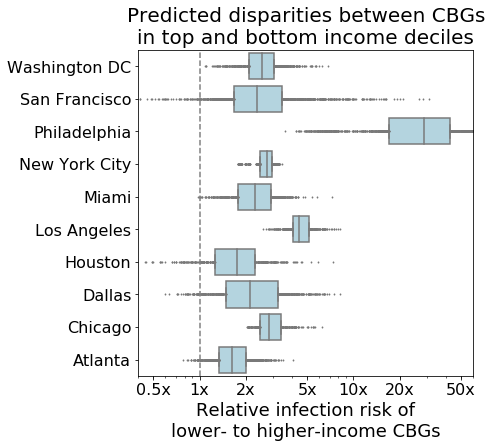

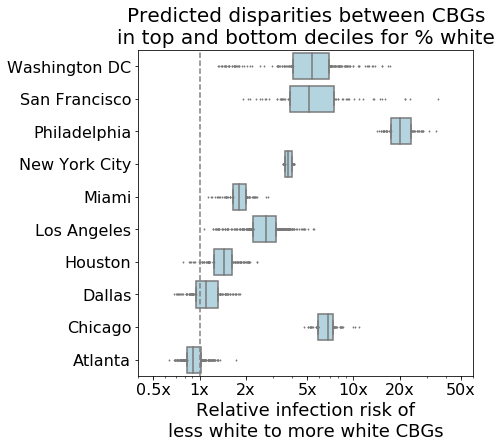

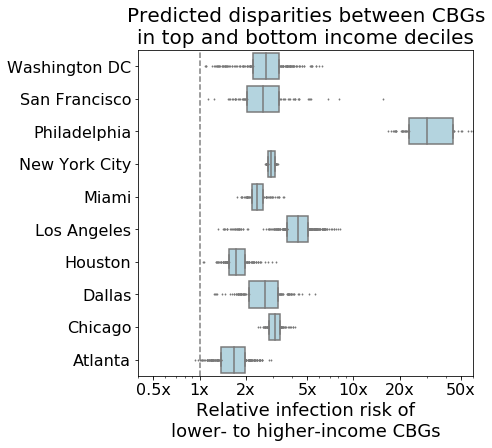

In [121]:
out = make_all_disparities_infection_ratio_plots(non_ablation_df, key_to_sort_by='loss_dict_daily_cases_RMSE',
                                           loss_tolerance=1.1)
out = make_all_disparities_infection_ratio_plots(non_ablation_df, key_to_sort_by='loss_dict_daily_deaths_RMSE',
                                           loss_tolerance=1.2)
out = make_all_disparities_infection_ratio_plots(non_ablation_df, key_to_sort_by='loss_dict_daily_cases_poisson_NLL_thres-10_sum',
                                           loss_tolerance=1.2)

## Figure 3c: disparate impact within POI categories for highlighted MSAs

Num params * seeds: 120


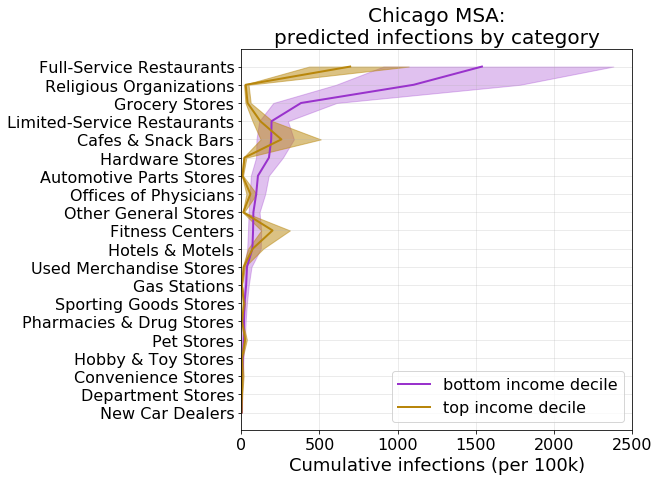

In [124]:
fig, ax = plt.subplots(figsize=(7, 7))
category_order = plot_frac_infected_per_category_for_multiple_models(superspreader_df_cases, poi_and_cbg_characteristics, 
                         HIGHLIGHT_MSA, ax, pretty_top_categories, sort_categories=True)
ax.legend(fontsize=16, loc='lower right')
ax.set_title('%s MSA:\npredicted infections by category' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA], fontsize=20)
plt.show()

## Supplement: disparate impact within POI categories for all MSAs

Atlanta_Sandy_Springs_Roswell_GA
Num params * seeds: 480
Chicago_Naperville_Elgin_IL_IN_WI
Num params * seeds: 120
Dallas_Fort_Worth_Arlington_TX
Num params * seeds: 150
Houston_The_Woodlands_Sugar_Land_TX
Num params * seeds: 240
Los_Angeles_Long_Beach_Anaheim_CA
Num params * seeds: 750
Miami_Fort_Lauderdale_West_Palm_Beach_FL
Num params * seeds: 210
New_York_Newark_Jersey_City_NY_NJ_PA
Num params * seeds: 210
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
Num params * seeds: 90
San_Francisco_Oakland_Hayward_CA
Num params * seeds: 150
Washington_Arlington_Alexandria_DC_VA_MD_WV
Num params * seeds: 510


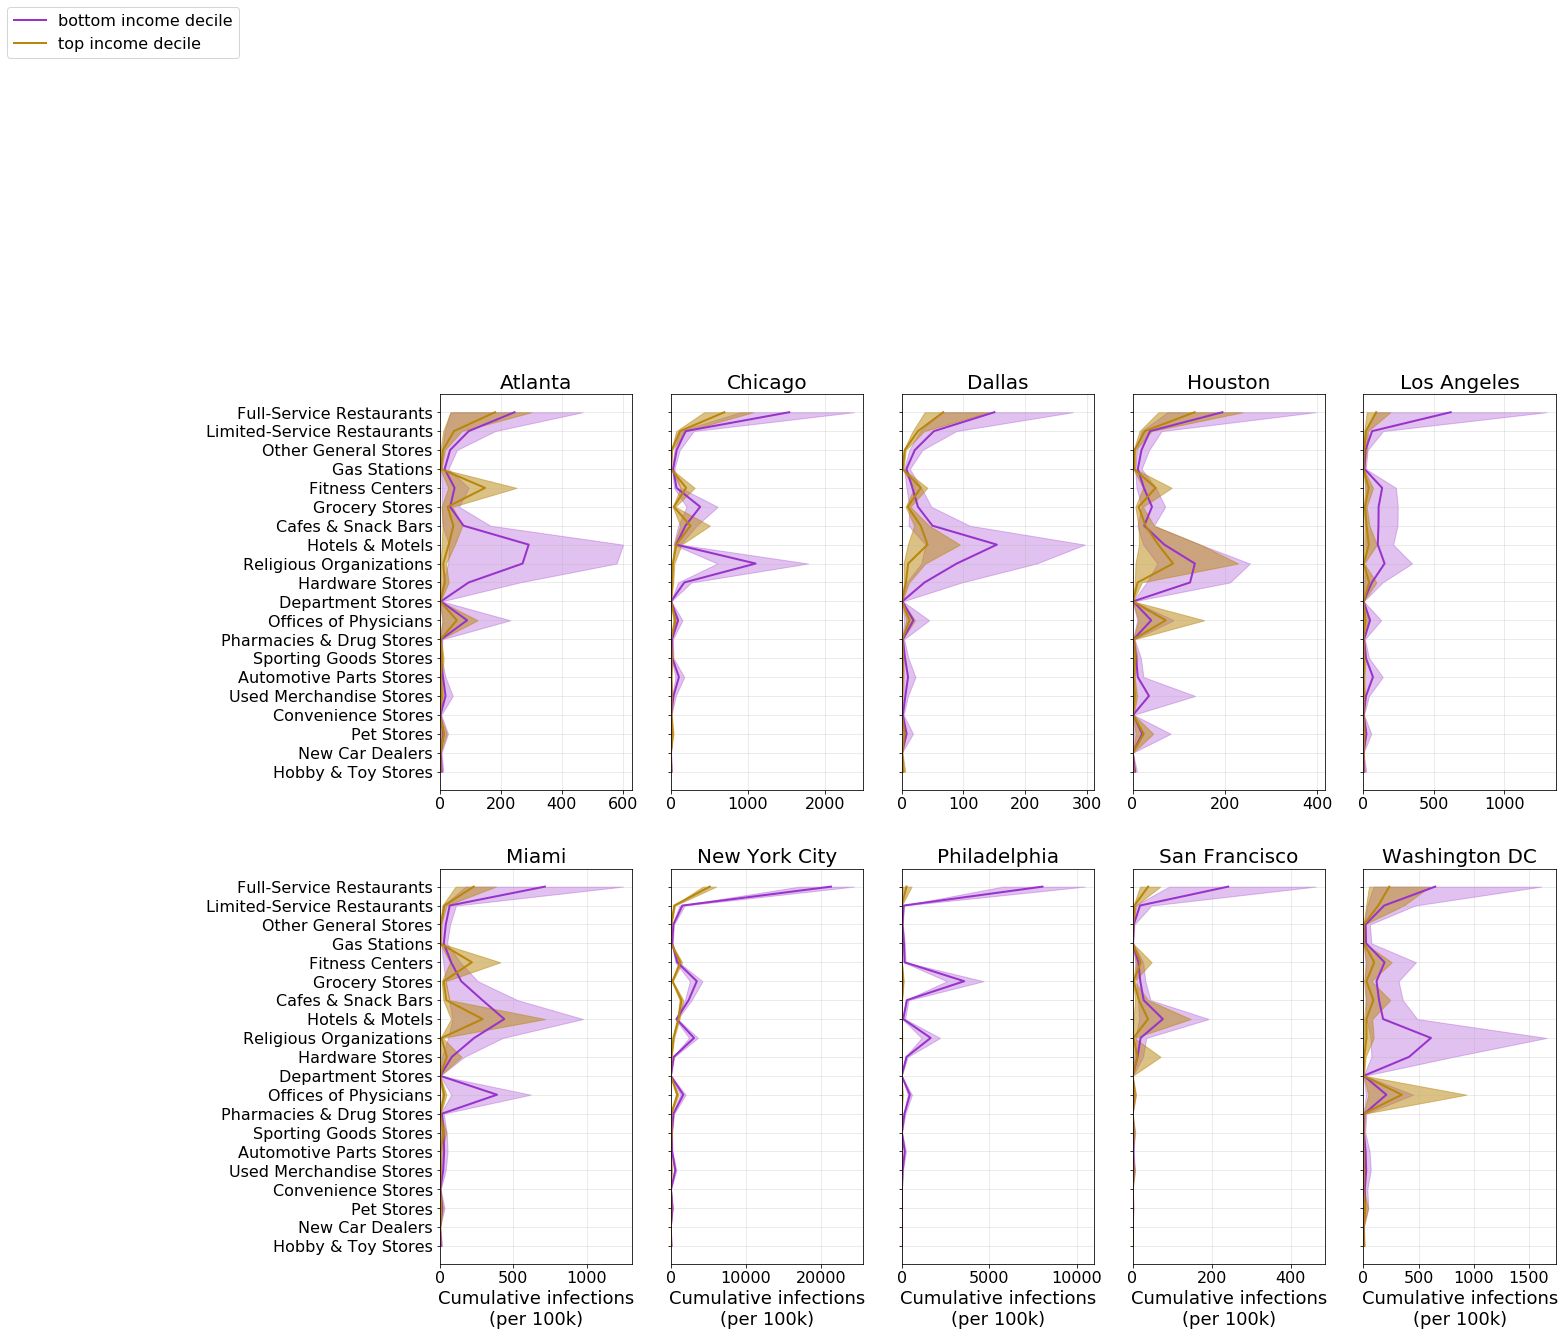

In [206]:
fig, axes = plt.subplots(2, 5, figsize=(20, 16), sharey=True)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    plot_frac_infected_per_category_for_multiple_models(superspreader_df_cases, poi_and_cbg_characteristics, 
                                                        msa_name, ax, pretty_top_categories)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=20)
    if i < 5:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Cumulative infections\n(per 100k)', fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-1, 2), fontsize=16)
plt.show()

## Figure 3d: mobility over time

Text(0.5, 1.0, 'Chicago MSA:\nper capita mobility over time')

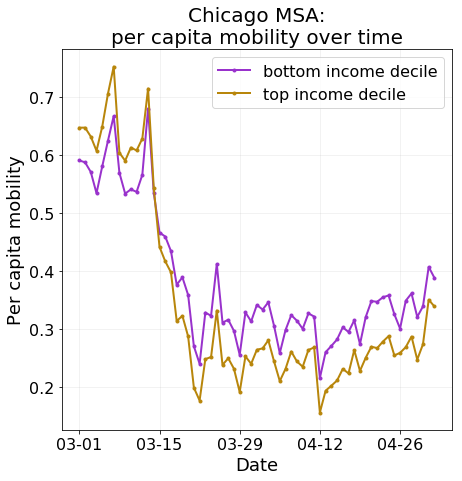

In [40]:
fig, ax = plt.subplots(figsize=(7, 7))
hours, Y1, Y2 = make_mobility_comparison_line_plot(poi_and_cbg_characteristics, HIGHLIGHT_MSA, MIN_DATETIME, MAX_DATETIME, 
                                   LOWINCOME, 'bottom income decile', 'darkorchid',
                                   HIGHINCOME, 'top income decile', 'darkgoldenrod', ax)
ax.set_title('%s MSA:\nper capita mobility over time' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA], fontsize=20)

In [42]:
april_start = hours.index(datetime.datetime(2020, 4, 1, 0))
april_end = hours.index(datetime.datetime(2020, 5, 1, 0))
Y1_sum = np.sum(Y1[april_start:april_end])
Y2_sum = np.sum(Y2[april_start:april_end])
diff = (Y1_sum - Y2_sum) / Y2_sum
print('bottom income decile has %.3f%% more POIs visits in April than top income decile' % (diff * 100))

bottom income decile has 26.753% more POIs visits in April than top income decile


## Supplement: mobility over time, all MSAs, SES and race

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


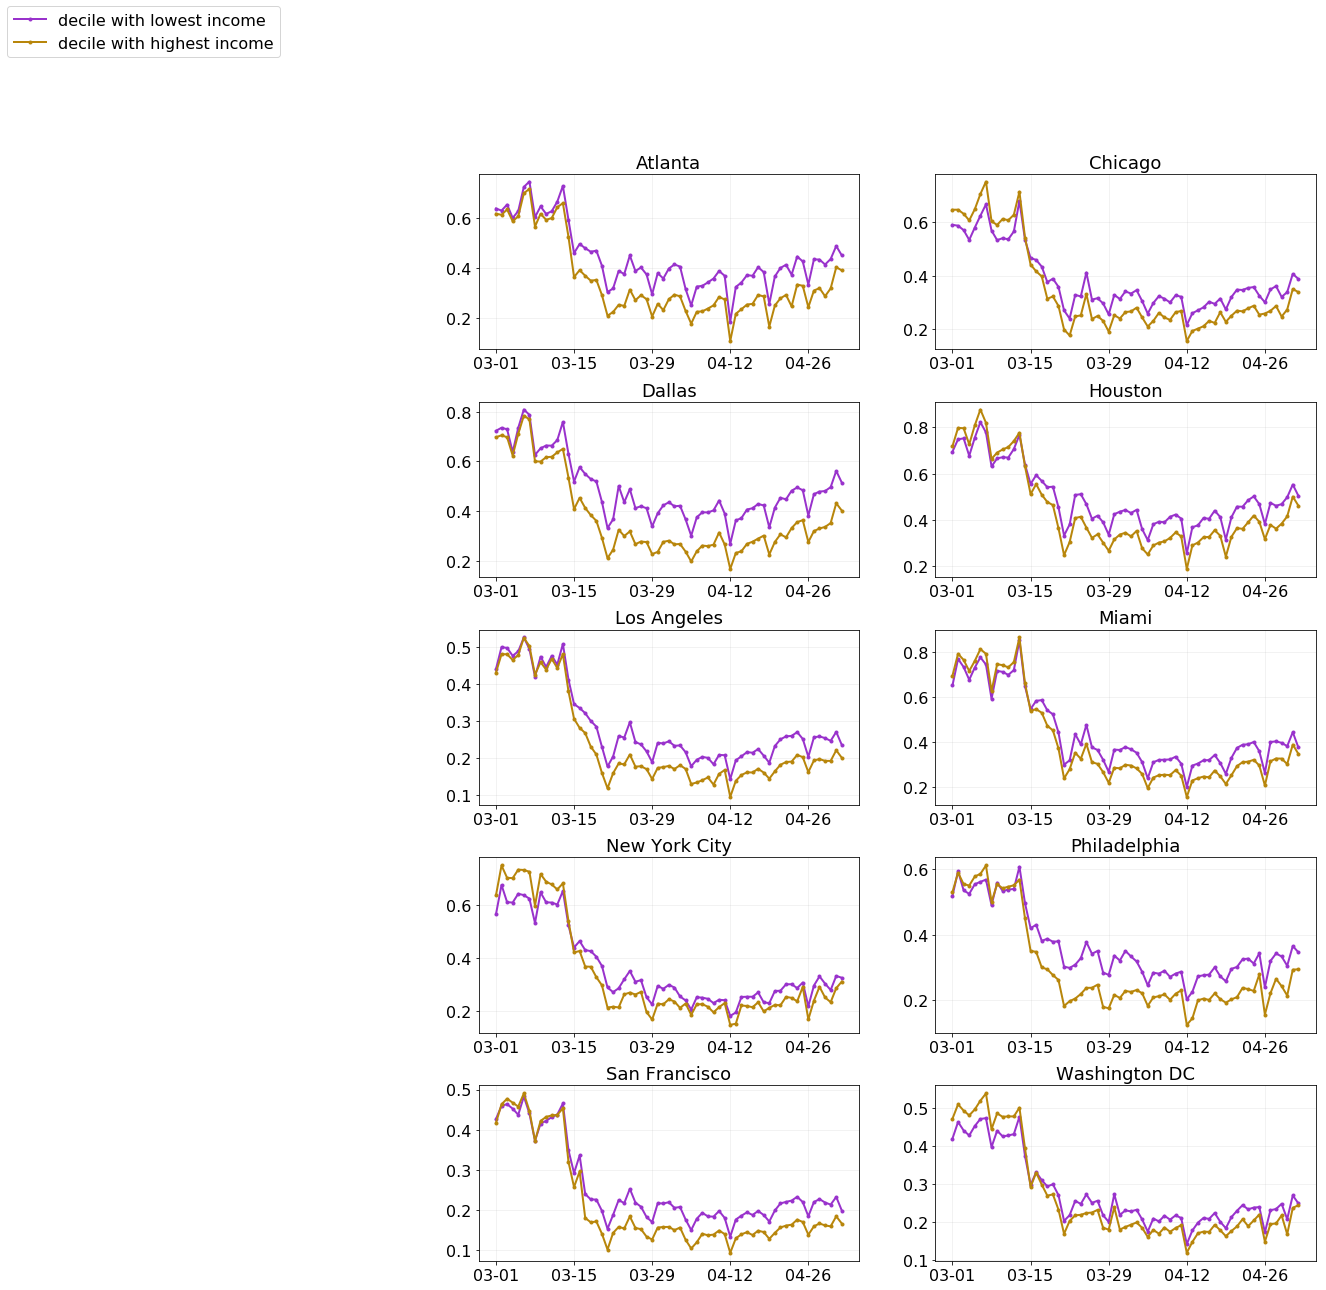

In [131]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.3)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=14)
    make_mobility_comparison_line_plot(poi_and_cbg_characteristics, msa_name, MIN_DATETIME, MAX_DATETIME, 
                                       LOWINCOME, 'decile with lowest income', 'darkorchid',
                                       HIGHINCOME, 'decile with highest income', 'darkgoldenrod', 
                                       ax, set_labels=False)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.5, 2), fontsize=16)
plt.show()

Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV


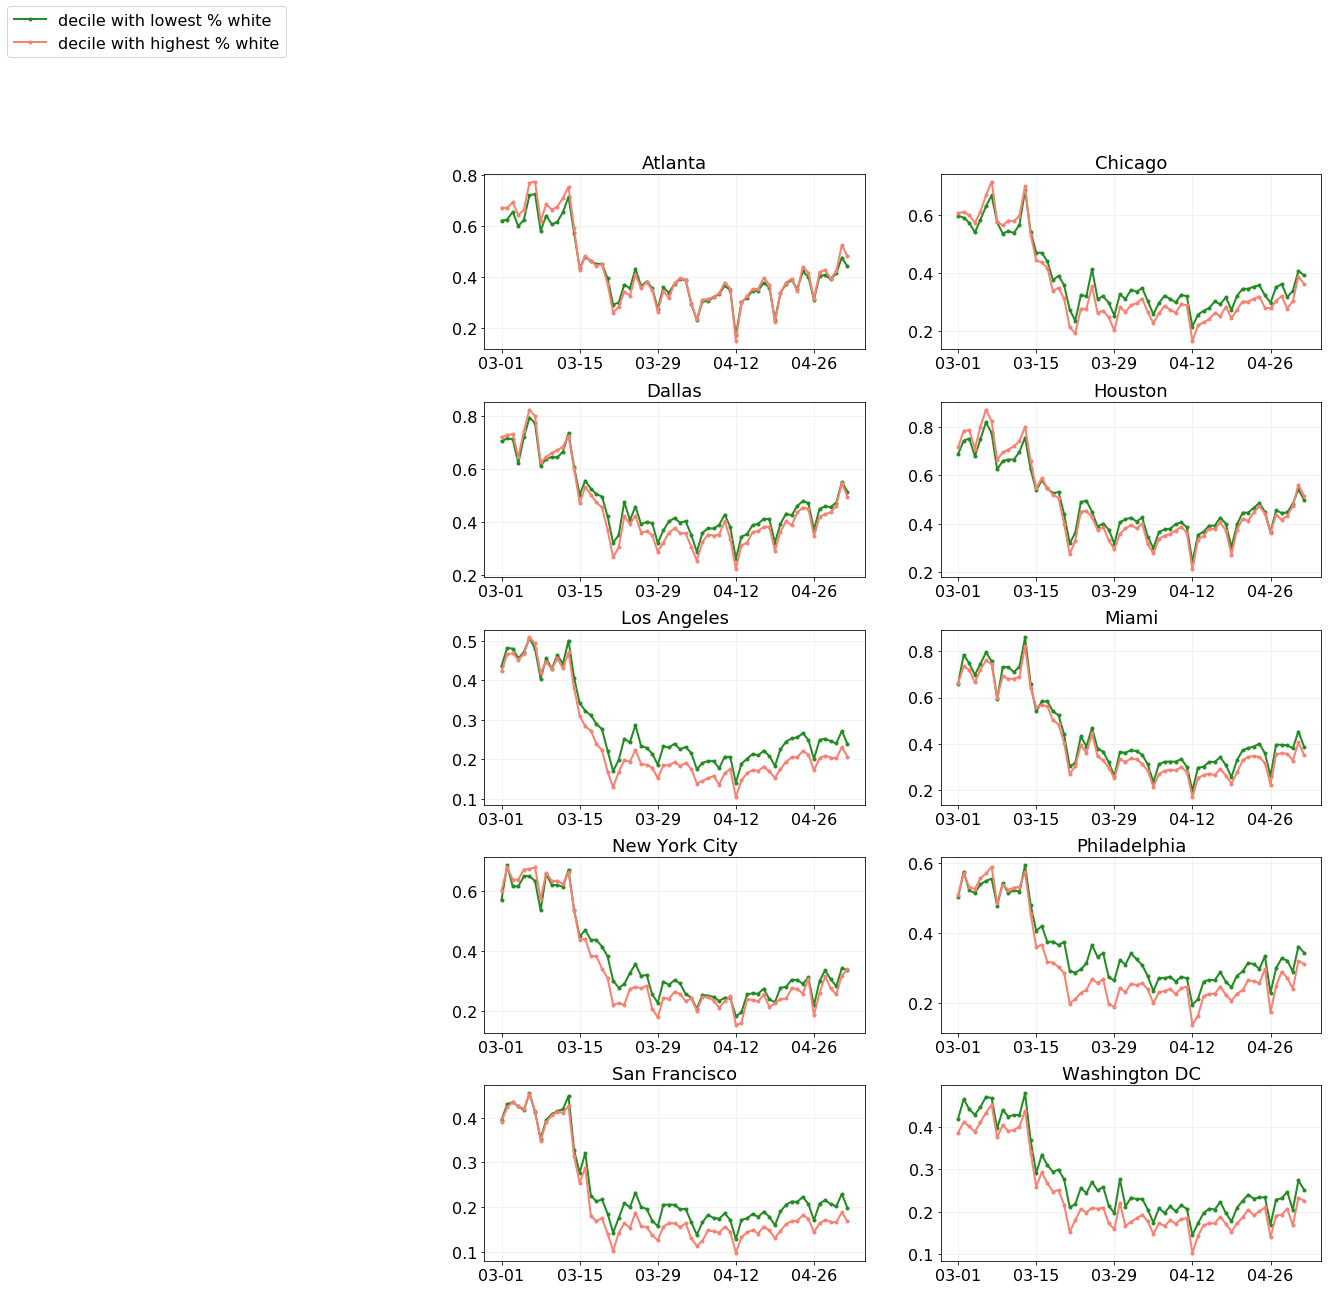

In [130]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.3)
axes = [ax for axes_row in axes for ax in axes_row]
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=14)
    make_mobility_comparison_line_plot(poi_and_cbg_characteristics, msa_name, MIN_DATETIME, MAX_DATETIME, 
                                       NONWHITE, 'decile with lowest % white', 'forestgreen',
                                       WHITE, 'decile with highest % white', 'salmon', 
                                       ax, set_labels=False)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.5, 2), fontsize=16)
plt.show()

## Fig 3e: transmission rates per category

In [136]:
categories_to_plot = pretty_top_categories
categories_to_label = categories_to_plot
msa_characteristics = poi_and_cbg_characteristics[HIGHLIGHT_MSA]
cbg_idx_groups_to_track = msa_characteristics['cbg_idx_groups_to_track']
cbg_sizes = msa_characteristics['cbg_sizes']

li_poi_attr = get_poi_attributes_for_msa(poi_and_cbg_characteristics, HIGHLIGHT_MSA, group_to_track=LOWINCOME)
li_pop_size = np.sum(cbg_sizes[cbg_idx_groups_to_track[LOWINCOME]])
li_cat_attr = get_category_attributes_from_poi_attributes(li_poi_attr, categories_to_plot, pop_size=li_pop_size)
hi_poi_attr = get_poi_attributes_for_msa(poi_and_cbg_characteristics, HIGHLIGHT_MSA, group_to_track=HIGHINCOME)
hi_pop_size = np.sum(cbg_sizes[cbg_idx_groups_to_track[HIGHINCOME]])
hi_cat_attr = get_category_attributes_from_poi_attributes(hi_poi_attr, categories_to_plot, pop_size=hi_pop_size)

Aggregating data from 1512 hours
Dropped 48369/62420 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 40009/62420 POIs with 0 visits in this time period.


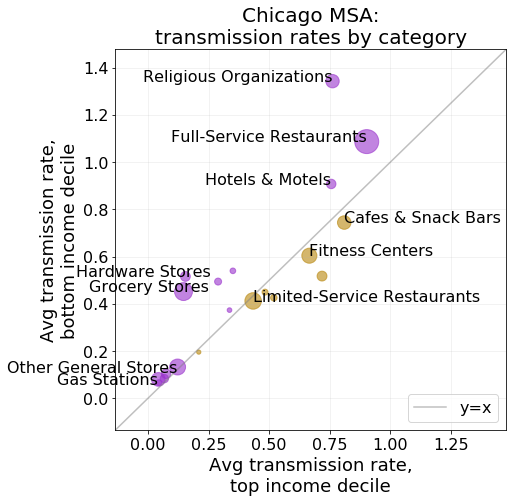

In [176]:
fig, ax = plt.subplots(figsize=(7, 7))
attribute = 'avg_transmission_rate'
title = '%s MSA:\ntransmission rates by category' % MSAS_TO_PRETTY_NAMES[HIGHLIGHT_MSA]
xlabel = 'Avg transmission rate,\ntop income decile'
ylabel = 'Avg transmission rate,\nbottom income decile'
X, Y, cats = make_category_comparison_scatter_plot(hi_cat_attr, li_cat_attr, 
                                                   attribute, ax, 'darkgoldenrod', 'darkorchid', title,
                                                   xlabel, ylabel, psi=1764)
for x_pt, y_pt, cat in zip(X, Y, cats):
    if cat in pretty_top_categories[:10]:
        if cat in {'Gas Stations', 'Other General Stores'}:
            ax.annotate(cat, xy=(x_pt, y_pt), ha='right', 
                        xytext=(0, -5), textcoords='offset pixels', fontsize=14)
        elif cat in {'Grocery Stores', 'Hardware Stores'}:
            ax.annotate(cat, xy=(x_pt, y_pt), ha='right', 
                        xytext=(15, 0), textcoords='offset pixels', fontsize=14)
        elif x_pt < y_pt:
            ax.annotate(cat, xy=(x_pt, y_pt), ha='right', fontsize=14)
        else:
            ax.annotate(cat, xy=(x_pt, y_pt), ha='left', fontsize=14)
            

## Supplement: transmission rate ratio tables

In [46]:
all_ses_results = get_attribute_ratios_for_all_msas(LOWINCOME, HIGHINCOME, 
                                                    poi_and_cbg_characteristics, pretty_top_categories)

Getting results for Atlanta_Sandy_Springs_Roswell_GA
Aggregating data from 1512 hours
Dropped 26945/39411 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24276/39411 POIs with 0 visits in this time period.
Getting results for Chicago_Naperville_Elgin_IL_IN_WI
Aggregating data from 1512 hours
Dropped 48369/62420 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 40009/62420 POIs with 0 visits in this time period.
Getting results for Dallas_Fort_Worth_Arlington_TX
Aggregating data from 1512 hours
Dropped 36094/52999 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 31390/52999 POIs with 0 visits in this time period.
Getting results for Houston_The_Woodlands_Sugar_Land_TX
Aggregating data from 1512 hours
Dropped 35974/49622 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24895/49622 POIs with 0 visits in this time period.
Getting results for Los_Angeles_Long_Beach

In [47]:
# make summary dataframe of avg_transmission_rate ratios for MSA x category
mat = np.zeros((len(pretty_top_categories), len(MSAS)))
for i, cat in enumerate(pretty_top_categories):
    subdf = all_ses_results[all_ses_results['category'] == cat]
    for j, msa_name in enumerate(MSAS):
        results = subdf[subdf['MSA_name'] == msa_name]
        assert len(results) == 1
        mat[i, j] = round(results['avg_transmission_rate_ratio'], 3)

# median ratio per msa, aggregated over categories
msa_medians = np.round(np.median(mat, axis=0), 3)
for msa, median in zip(MSAS, msa_medians):
    print(msa, median)

cols = [MSAS_TO_PRETTY_NAMES[m] for m in MSAS]
summary_df = pd.DataFrame(mat, columns=cols, index=pretty_top_categories)
summary_df['Med'] = np.round(np.median(summary_df.values, axis=1), 3)
summary_df

Atlanta_Sandy_Springs_Roswell_GA 1.188
Chicago_Naperville_Elgin_IL_IN_WI 1.202
Dallas_Fort_Worth_Arlington_TX 0.968
Houston_The_Woodlands_Sugar_Land_TX 0.915
Los_Angeles_Long_Beach_Anaheim_CA 1.33
Miami_Fort_Lauderdale_West_Palm_Beach_FL 1.304
New_York_Newark_Jersey_City_NY_NJ_PA 1.746
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 1.702
San_Francisco_Oakland_Hayward_CA 1.196
Washington_Arlington_Alexandria_DC_VA_MD_WV 1.166


Atlanta  Chicago  Dallas  Houston  Los Angeles  \
Full-Service Restaurants       0.764    1.204   0.956    1.000        1.445   
Limited-Service Restaurants    0.940    0.950   1.002    0.906        1.067   
Other General Stores           0.782    1.083   0.957    0.729        0.760   
Gas Stations                   1.326    1.865   1.310    1.515        2.254   
Fitness Centers                0.536    0.907   0.708    0.670        1.461   
Grocery Stores                 0.948    3.080   0.838    1.333        2.408   
Cafes & Snack Bars             1.385    0.919   0.716    1.120        1.327   
Hotels & Motels                1.228    1.200   0.814    0.804        1.229   
Religious Organizations        1.546    1.763   0.956    0.919        1.746   
Hardware Stores                3.938    3.340   1.575    2.111        1.333   
Department Stores              1.132    1.230   0.978    0.911        1.083   
Offices of Physicians          1.235    0.721   0.667    1.036        1.141   
Pharmacies & Drug Stores       1.636    1.389   1.176    0.854        1.718   
Sporting Goods Stores          0.936    1.540   1.129    0.812        1.168   
Automotive Parts Stores        0.890    1.707   0.862    1.086        1.990   
Used Merchandise Stores        0.993    0.931   1.000    1.315        1.017   
Convenience Stores             1.208    0.932   1.613    0.647        0.838   
Pet Stores                     1.260    0.820   1.192    1.487        1.536   
New Car Dealers                2.036    1.471   0.741    0.809        1.180   
Hobby & Toy Stores             1.168    1.110   1.165    0.853        1.771   

                             Miami  New York City  Philadelphia  \
Full-Service Restaurants     1.232          2.035         2.883   
Limited-Service Restaurants  0.872          1.901         1.614   
Other General Stores         0.894          1.218         1.312   
Gas Stations                 2.195          1.899         6.461   
Fitness Centers              0.789          1.151         1.516   
Grocery Stores               1.498          4.984        10.437   
Cafes & Snack Bars           2.168          1.943         1.757   
Hotels & Motels              1.134          1.260         1.993   
Religious Organizations      1.464          1.756         1.736   
Hardware Stores              0.939          3.553         6.716   
Department Stores            1.431          1.667         0.976   
Offices of Physicians        1.687          1.307         1.319   
Pharmacies & Drug Stores     1.555          2.577         5.624   
Sporting Goods Stores        0.700          1.253         1.161   
Automotive Parts Stores      1.414          1.524         2.697   
Used Merchandise Stores      1.074          1.352         1.668   
Convenience Stores           0.824          1.736         2.322   
Pet Stores                   0.776          3.558         1.652   
New Car Dealers              1.377          2.022         1.129   
Hobby & Toy Stores           1.520          1.525         1.088   

                             San Francisco  Washington DC    Med  
Full-Service Restaurants             1.758          1.171  1.218  
Limited-Service Restaurants          0.994          0.962  0.978  
Other General Stores                 1.045          0.950  0.954  
Gas Stations                         1.357          1.870  1.868  
Fitness Centers                      0.995          1.160  0.951  
Grocery Stores                       2.478          1.977  2.192  
Cafes & Snack Bars                   0.982          0.932  1.224  
Hotels & Motels                      1.199          1.346  1.214  
Religious Organizations              1.515          1.852  1.641  
Hardware Stores                      4.202         13.560  3.446  
Department Stores                    0.867          1.042  1.062  
Offices of Physicians                1.193          0.445  1.167  
Pharmacies & Drug Stores             1.200          1.699  1.596  
Sporting Goods Stores  

In [80]:
summary_df.median()

Atlanta          1.1880
Chicago          1.2020
Dallas           0.9675
Houston          0.9150
Los Angeles      1.3300
Miami            1.3045
New York City    1.7460
Philadelphia     1.7020
San Francisco    1.1960
Washington DC    1.1655
Med              1.1905
dtype: float64

In [79]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n{} &  Atlanta &  Chicago &  Dallas &  Houston &  Los Angeles &  Miami &  New York City &  Philadelphia &  San Francisco &  Washington DC &    Med \\\\\n\\midrule\nFull-Service Restaurants    &    0.764 &    1.204 &   0.956 &    1.000 &        1.445 &  1.232 &          2.035 &         2.883 &          1.758 &          1.171 &  1.218 \\\\\nLimited-Service Restaurants &    0.940 &    0.950 &   1.002 &    0.906 &        1.067 &  0.872 &          1.901 &         1.614 &          0.994 &          0.962 &  0.978 \\\\\nOther General Stores        &    0.782 &    1.083 &   0.957 &    0.729 &        0.760 &  0.894 &          1.218 &         1.312 &          1.045 &          0.950 &  0.954 \\\\\nGas Stations                &    1.326 &    1.865 &   1.310 &    1.515 &        2.254 &  2.195 &          1.899 &         6.461 &          1.357 &          1.870 &  1.868 \\\\\nFitness Centers             &    0.536 &    0.907 &   0.708 &    0.670 &        1.461

In [88]:
subdf = all_ses_results[all_ses_results['category'] == 'Grocery Stores']
subdf.median()[['avg_dwell_time_ratio', 'avg_people_per_sq_ft_ratio', 'avg_transmission_rate_ratio']]

avg_dwell_time_ratio           1.167091
avg_people_per_sq_ft_ratio     1.587962
avg_transmission_rate_ratio    2.192200
dtype: float64

In [90]:
all_ses_results[(all_ses_results['category'] == 'Grocery Stores') & (all_ses_results['MSA_name'] == 'Philadelphia_Camden_Wilmington_PA_NJ_DE_MD')]

avg_dwell_time_ratio  avg_people_per_sq_ft_ratio  avg_transmission_rate_ratio        category                                    MSA_name
5              1.856997                    5.351303                    10.436994  Grocery Stores  Philadelphia_Camden_Wilmington_PA_NJ_DE_MD

In [83]:
all_race_results = get_attribute_ratios_for_all_msas(NONWHITE, WHITE,
                                                     poi_and_cbg_characteristics, pretty_top_categories)

Getting results for Atlanta_Sandy_Springs_Roswell_GA
Aggregating data from 1512 hours
Dropped 31635/39411 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24848/39411 POIs with 0 visits in this time period.
Getting results for Chicago_Naperville_Elgin_IL_IN_WI
Aggregating data from 1512 hours
Dropped 53759/62420 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 41785/62420 POIs with 0 visits in this time period.
Getting results for Dallas_Fort_Worth_Arlington_TX
Aggregating data from 1512 hours
Dropped 41348/52999 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 32715/52999 POIs with 0 visits in this time period.
Getting results for Houston_The_Woodlands_Sugar_Land_TX
Aggregating data from 1512 hours
Dropped 39053/49622 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 33621/49622 POIs with 0 visits in this time period.
Getting results for Los_Angeles_Long_Beach

In [84]:
# make summary dataframe of avg_transmission_rate ratios for MSA x category
mat = np.zeros((len(pretty_top_categories), len(MSAS)))
for i, cat in enumerate(pretty_top_categories):
    subdf = all_race_results[all_race_results['category'] == cat]
    for j, msa_name in enumerate(MSAS):
        results = subdf[subdf['MSA_name'] == msa_name]
        assert len(results) == 1
        mat[i, j] = round(results['avg_transmission_rate_ratio'], 3)

# median ratio per msa, aggregated over categories
msa_medians = np.round(np.median(mat, axis=0), 3)
for msa, median in zip(MSAS, msa_medians):
    print(msa, median)

cols = [MSAS_TO_PRETTY_NAMES[m] for m in MSAS]
summary_df = pd.DataFrame(mat, columns=cols, index=pretty_top_categories)
summary_df['Med'] = np.round(np.median(summary_df.values, axis=1), 3)
summary_df

Atlanta_Sandy_Springs_Roswell_GA 0.932
Chicago_Naperville_Elgin_IL_IN_WI 1.338
Dallas_Fort_Worth_Arlington_TX 0.888
Houston_The_Woodlands_Sugar_Land_TX 0.959
Los_Angeles_Long_Beach_Anaheim_CA 1.303
Miami_Fort_Lauderdale_West_Palm_Beach_FL 1.092
New_York_Newark_Jersey_City_NY_NJ_PA 1.955
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD 2.281
San_Francisco_Oakland_Hayward_CA 1.119
Washington_Arlington_Alexandria_DC_VA_MD_WV 1.314


Atlanta  Chicago  Dallas  Houston  Los Angeles  Miami  New York City  Philadelphia  San Francisco  Washington DC    Med
Full-Service Restaurants       0.802    1.354   0.981    0.965        1.065  1.167          2.418         2.661          1.223          1.013  1.116
Limited-Service Restaurants    0.940    1.144   1.028    0.940        0.820  0.919          2.136         1.523          0.799          1.346  0.984
Other General Stores           0.776    1.277   0.838    0.841        1.527  1.132          2.158         1.313          0.925          1.312  1.204
Gas Stations                   1.402    1.891   1.389    1.190        1.336  1.857          1.818         2.286          2.321          1.316  1.610
Fitness Centers                0.607    1.167   0.670    0.831        0.780  1.066          1.447         1.977          1.103          1.205  1.084
Grocery Stores                 0.589    3.664   0.613    1.195        2.386  0.950          5.864        13.705          2.243          2.262  2.252
Cafes & Snack Bars             1.308    1.104   0.845    0.840        0.976  2.619          1.767         2.456          1.045          0.867  1.074
Hotels & Motels                0.977    1.007   1.366    0.718        1.112  1.024          1.449         2.494          0.654          0.899  1.015
Religious Organizations        0.938    1.606   1.060    0.953        2.096  1.795          1.933         2.040          1.674          1.188  1.640
Hardware Stores                0.909    3.900   1.523    1.461        1.952  0.586          5.032         3.898         11.103         13.432  2.925
Department Stores              1.081    1.301   0.805    0.777        0.992  2.337          2.479         1.357          1.089          1.402  1.195
Offices of Physicians          0.894    1.323   1.006    1.415        0.898  1.117          1.652         2.073          0.694          1.911  1.220
Pharmacies & Drug Stores       0.888    1.376   0.930    0.732        1.538  1.674          3.315         3.366          1.135          1.715  1.457
Sporting Goods Stores          0.767    0.674   0.650    0.506        1.946  0.818          1.532         2.152          0.880          1.715  0.849
Automotive Parts Stores        1.049    1.479   1.010    1.353        2.998  2.657          1.740         3.387          1.646          0.601  1.562
Used Merchandise Stores        0.858    1.195   0.699    1.060        1.270  0.593          1.500         3.024          1.425          0.799  1.128
Convenience Stores             2.016    5.055   1.272    2.188        0.761  0.902          1.911         2.276          1.239          1.844  1.878
Pet Stores                     0.925    1.624   0.724    1.465        1.506  0.881          2.715        10.182          1.568          2.408  1.537
New Car Dealers                1.008    1.398   0.812    0.736        0.942  0.998          1.977         0.866          0.772          0.383  0.904
Hobby & Toy Stores             2.569    0.853   0.628    0.979        1.373  1.388          2.237         0.825          0.864          1.286  1.132

In [85]:
summary_df.median()

Atlanta          0.9315
Chicago          1.3385
Dallas           0.8875
Houston          0.9590
Los Angeles      1.3030
Miami            1.0915
New York City    1.9550
Philadelphia     2.2810
San Francisco    1.1190
Washington DC    1.3140
Med              1.1995
dtype: float64

In [86]:
summary_df.to_latex()

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n{} &  Atlanta &  Chicago &  Dallas &  Houston &  Los Angeles &  Miami &  New York City &  Philadelphia &  San Francisco &  Washington DC &    Med \\\\\n\\midrule\nFull-Service Restaurants    &    0.802 &    1.354 &   0.981 &    0.965 &        1.065 &  1.167 &          2.418 &         2.661 &          1.223 &          1.013 &  1.116 \\\\\nLimited-Service Restaurants &    0.940 &    1.144 &   1.028 &    0.940 &        0.820 &  0.919 &          2.136 &         1.523 &          0.799 &          1.346 &  0.984 \\\\\nOther General Stores        &    0.776 &    1.277 &   0.838 &    0.841 &        1.527 &  1.132 &          2.158 &         1.313 &          0.925 &          1.312 &  1.204 \\\\\nGas Stations                &    1.402 &    1.891 &   1.389 &    1.190 &        1.336 &  1.857 &          1.818 &         2.286 &          2.321 &          1.316 &  1.610 \\\\\nFitness Centers             &    0.607 &    1.167 &   0.670 &    0.831 &        0.780

## Supplement: num visits per capita to POI categories

Atlanta_Sandy_Springs_Roswell_GA
Aggregating data from 1512 hours
Dropped 26945/39411 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24276/39411 POIs with 0 visits in this time period.
Chicago_Naperville_Elgin_IL_IN_WI
Aggregating data from 1512 hours
Dropped 48369/62420 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 40009/62420 POIs with 0 visits in this time period.
Dallas_Fort_Worth_Arlington_TX
Aggregating data from 1512 hours
Dropped 36094/52999 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 31390/52999 POIs with 0 visits in this time period.
Houston_The_Woodlands_Sugar_Land_TX
Aggregating data from 1512 hours
Dropped 35974/49622 POIs with 0 visits in this time period.
Aggregating data from 1512 hours
Dropped 24895/49622 POIs with 0 visits in this time period.
Los_Angeles_Long_Beach_Anaheim_CA
Aggregating data from 1512 hours
Dropped 57729/83954 POIs with 0 visits in this time per

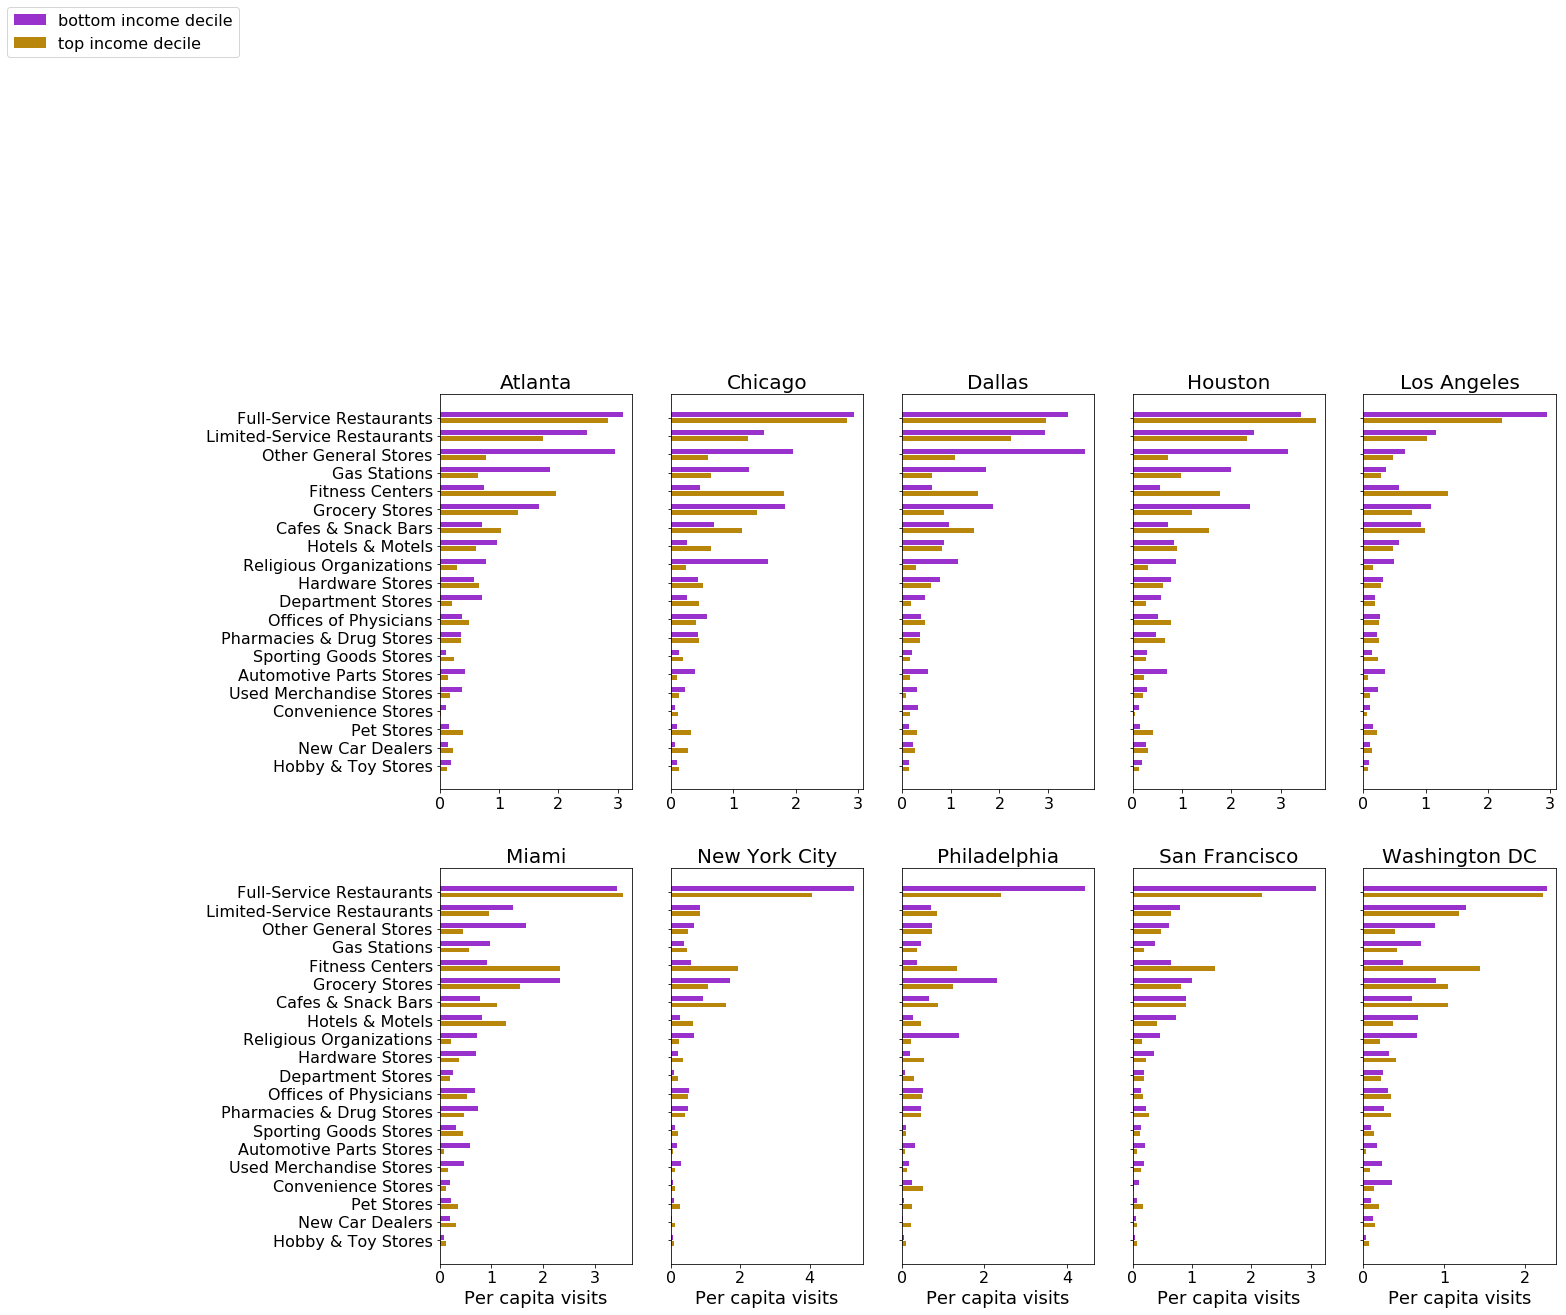

In [204]:
fig, axes = plt.subplots(2, 5, figsize=(20, 16), sharey=True)
axes = [ax for axes_row in axes for ax in axes_row]
reverse_categories = pretty_top_categories.copy()
reverse_categories.reverse()  # reverse so that most popular category is on top
for i, (ax, msa_name) in enumerate(list(zip(axes, MSAS))):
    print(msa_name)
    plot_per_capita_category_visits(poi_and_cbg_characteristics, msa_name, 
                                LOWINCOME, 'bottom income decile', 'darkorchid',
                                HIGHINCOME, 'top income decile', 'darkgoldenrod', 
                                reverse_categories, ax, set_axis_labels=False)
    ax.set_title(MSAS_TO_PRETTY_NAMES[msa_name], fontsize=20)
    if i >= 5:
        ax.set_xlabel('Per capita visits', fontsize=18)
    if i == 0:
        ax.legend(bbox_to_anchor=(-1, 2), fontsize=16)
plt.show()

# Data summary table

In [53]:
min_timestring_for_msa_stats = '2020_05_30' # doesn't really matter, take something reasonably recent

# pull stats
min_timestring = '2020_07_22'
best_models_df = evaluate_all_fitted_models_for_experiment('rerun_best_models_and_save_cases_per_poi', 
                                                              min_timestring=min_timestring)
best_models_df['MSA_name'] = best_models_df['data_kwargs'].map(lambda x:x['MSA_name'])

msa_stats = []
for msa in MSAS:
    print(msa)
    msa_df = best_models_df[best_models_df['MSA_name'] == msa]
    mdl, data_and_model_kwargs, _, _, _ = load_model_and_data_from_timestring(
                msa_df.iloc[0]['timestring'],
                load_fast_results_only=False, 
                load_full_model=True)    
    nyt_outcomes, nyt_counties, nyt_cbgs, msa_counties, msa_cbgs = get_variables_for_evaluating_msa_model(msa)
    msa_cbgs = set(msa_cbgs)
    cbgs_in_msa = np.array([a in msa_cbgs for a in mdl.ALL_UNIQUE_CBGS])

    poi_cbg_list = pickle.load(open(data_and_model_kwargs['model_kwargs']['preload_poi_visits_list_filename'], 'rb'))
    n_pois, n_cbgs = poi_cbg_list[0].shape
    total_nnzs = 0
    total_visits = 0
    correction_factor = 322903030/46554310. # don't try this at home, kids
    for i in range(len(poi_cbg_list)):
        total_nnzs += poi_cbg_list[i].nnz 
        total_visits += poi_cbg_list[i].sum() / correction_factor
    msa_stats.append({'msa':MSAS_TO_PRETTY_NAMES[msa],
                     'n_pois':n_pois, 
                     'n_cbgs':n_cbgs, 
                      'total_hourly_edges':total_nnzs, 
                      'total_visits':np.round(total_visits).astype(int), 
                      'total_modelled_pop':mdl.CBG_SIZES.sum(), 
                      'total_modelled_pop_in_cbg':mdl.CBG_SIZES[cbgs_in_msa].sum()})
msa_stats = pd.DataFrame(msa_stats)
full_table = pd.concat([msa_stats, pd.DataFrame(msa_stats.sum()).transpose()])
full_table['msa'].iloc[-1] = 'All MSAs combined'
def millify(n):
    # https://stackoverflow.com/questions/3154460/python-human-readable-large-numbers
    millnames = ['',' thousand',' million',' billion',' trillion']
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

print("""We model hourly mobility networks in %i of the largest American metropolitan statistical areas (containing %s people), connecting %s Census Block Groups to %s points of interest, a total of %s hourly edges.""" % 
      (len(full_table) - 1, 
       millify(full_table['total_modelled_pop'].iloc[-1]), 
       "{:,}".format(full_table['n_cbgs'].iloc[-1]), 
       "{:,}".format(full_table['n_pois'].iloc[-1]), 
       millify(full_table['total_hourly_edges'].iloc[-1])))
       
full_table
       
      
             

Loading models with timestrings between 2020_07_22 and 2020_07_29_14_46_52_630274
83235 files in directory /dfs/scratch2/extra_safegraph_aggregate_models/data_and_model_configs
Found 400 fitted models for rerun_best_models_and_save_cases_per_poi
Loaded 1 models so far: 0.004s -> 0.004s per model
Time to load and score all models: 1.232s -> 0.003s per model
Atlanta_Sandy_Springs_Roswell_GA
Chicago_Naperville_Elgin_IL_IN_WI
Dallas_Fort_Worth_Arlington_TX
Houston_The_Woodlands_Sugar_Land_TX
Los_Angeles_Long_Beach_Anaheim_CA
Miami_Fort_Lauderdale_West_Palm_Beach_FL
New_York_Newark_Jersey_City_NY_NJ_PA
Philadelphia_Camden_Wilmington_PA_NJ_DE_MD
San_Francisco_Oakland_Hayward_CA
Washington_Arlington_Alexandria_DC_VA_MD_WV
We model hourly mobility networks in 10 of the largest American metropolitan statistical areas (containing 97.9 million people), connecting 56,945 Census Block Groups to 552,758 points of interest, a total of 5.4 billion hourly edges.


msa n_cbgs  n_pois total_hourly_edges total_modelled_pop total_modelled_pop_in_cbg total_visits
0            Atlanta   3130   39411          540166727            7455619                   5769705     27669692
1            Chicago   6812   62420          540112026           10169539                   9516306     33785702
2             Dallas   4877   52999          752998455            9353561                   7253213     37298053
3            Houston   3345   49622          609766288            7621541                   6771951     32943613
4        Los Angeles   8904   83954          643758979           16101274                  13206546     38101674
5              Miami   3555   40964          487544190            6833129                   6064648     26347947
6      New York City  14763  122428         1057789207           20729481                  19805272     66581080
7       Philadelphia   4565   37951          304697220            6759058                   6045293     19551138
8      San Francisco   2943   28713          161575167            5137800                   4595143     10728090
9      Washington DC   4051   34296          312620619            7740276                   6120026     17898324
0  All MSAs combined  56945  552758         5411028878           97901278                  85148103    310905313

In [66]:
full_table.to_latex()

'\\begin{tabular}{llllllll}\n\\toprule\n{} &                msa & n\\_cbgs &  n\\_pois & total\\_hourly\\_edges & total\\_modelled\\_pop & total\\_modelled\\_pop\\_in\\_cbg & total\\_visits \\\\\n\\midrule\n0 &            Atlanta &   3130 &   39411 &          540166727 &            7455619 &                   5769705 &     27669692 \\\\\n1 &            Chicago &   6812 &   62420 &          540112026 &           10169539 &                   9516306 &     33785702 \\\\\n2 &             Dallas &   4877 &   52999 &          752998455 &            9353561 &                   7253213 &     37298053 \\\\\n3 &            Houston &   3345 &   49622 &          609766288 &            7621541 &                   6771951 &     32943613 \\\\\n4 &        Los Angeles &   8904 &   83954 &          643758979 &           16101274 &                  13206546 &     38101674 \\\\\n5 &              Miami &   3555 &   40964 &          487544190 &            6833129 &                   6064648 &     26347947 \